# COGS 108 - EDA Checkpoint

# Names

- Kyle Moore
- Harshini Ramaswamy
- Christina Ryder
- Jennifer Vo

<a id='research_question'></a>
# Research Question

Is there a relationship between rates of rape and transportation, public safety, and environment & housing spending by large cities with populations over 250,000 in the U.S from 1977-2015?

# Setup

In [78]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(style="white", font_scale=1.5)

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# make sure pandas & numpy are imported
import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

# Data Cleaning

**How 'clean' is the data?**
- The data is in a usable, tabular format (i.e. observations in rows, variables in columns). Observations have been reported in a standardized way and column headings are informative and appropriate. 

**What did you have to do to get the data into a usable format? (If you did nothing, how did you determine there was nothing to do?)**
- We did not have to get the data into a usable format. Both datasets already had observations organized in rows and variables in columns in a tabular format. The column names were also relatively short and readable, and appropriate for understanding the data organized under each column so no changes had to be made to the column names. We also checked the type of observations within the same column(e.g. Int, boolean) and they were all consistent. Additionally, the information within each column was already reported in a standardized way with no varying units(e.g. as a total or as a proportion). 

**What pre-processing steps that were required for your methods (for example, checking data distributions and performing any transformations that may be required)**
- We filtered observations related to the variables of interest(city names, years, spending allocated for department of transportation, rape rates, population) from both datasets. Both datasets also included data from different time periods, so we excluded any data before 1977 and after 2015 in both datasets. Additionally, the datasets stored the city names differently(e.g. Anchorage, AK for the crime dataset vs. AK: Anchorage for the fiscal data set) so we standardized the city names to follow the same format (City, State), before merging the two datasets. We also selectively kept the cities that were reported about in both datasets. We checked for any missing values related to the current variables we are studying and excluded cities where there was no data for population totals, rape case totals, and transportation spending. We kept variables such as crimes per capita, rapes per capita, general and direct spending, public safety spending, and environmental and housing spending to potentially include in our analysis later on. 

In [79]:
# Read in Crime data
crime = pd.read_csv('report.csv')
crime.shape

(2829, 15)

In [80]:
# Read in Fiscal data
fiscal = pd.read_csv('Data-Table 1.csv')
fiscal.shape

(8938, 663)

In [81]:
# Crime table
crime.head()

report_year agency_code agency_jurisdiction  population  violent_crimes  \
0         1975     NM00101     Albuquerque, NM    286238.0          2383.0   
1         1975     TX22001       Arlington, TX    112478.0           278.0   
2         1975     GAAPD00         Atlanta, GA    490584.0          8033.0   
3         1975     CO00101          Aurora, CO    116656.0           611.0   
4         1975     TX22701          Austin, TX    300400.0          1215.0   

   homicides  rapes  assaults  robberies  months_reported  crimes_percapita  \
0       30.0  181.0    1353.0      819.0             12.0            832.52   
1        5.0   28.0     132.0      113.0             12.0            247.16   
2      185.0  443.0    3518.0     3887.0             12.0           1637.44   
3        7.0   44.0     389.0      171.0             12.0            523.76   
4       33.0  190.0     463.0      529.0             12.0            404.46   

   homicides_percapita  rapes_percapita  assaults_percapita  \
0                10.48            63.23              472.68   
1                 4.45            24.89              117.36   
2                37.71            90.30              717.10   
3                 6.00            37.72              333.46   
4                10.99            63.25              154.13   

   robberies_percapita  
0               286.13  
1               100.46  
2               792.32  
3               146.58  
4               176.10

In [82]:
# Fiscal table
fiscal.head()

year      city_name city_types   id_city  city_population       cpi  \
0  1977  AK: Anchorage       core  22002001           174500  4.044885   
1  1978  AK: Anchorage       core  22002001           177000  3.759509   
2  1979  AK: Anchorage       core  22002001           179600  3.376308   
3  1980  AK: Anchorage       core  22002001           178800  2.974757   
4  1981  AK: Anchorage       core  22002001           174431  2.696590   

   rev_total_city  rev_general_city  intergovt_rev_city  igr_federal_city  \
0         5342.24           4956.92             2148.77            279.32   
1         5948.99           5490.05             2468.11            403.24   
2         6158.68           5746.64             2573.34            496.97   
3         5654.93           5210.77             2313.62            371.46   
4         6192.83           5736.81             2771.43            338.76   

         ...          cash_other_offsets  cash_other_bonds  cash_other_other  \
0        ...                      178.51            787.93            691.32   
1        ...                      187.53           1395.82           1158.01   
2        ...                      249.03           1812.04           1314.62   
3        ...                      986.73           1330.72           1572.66   
4        ...                      977.32           1549.51           1669.55   

   county_name  id_county  county_population  relationship_city_school  \
0          NaN        NaN                NaN                       4.0   
1          NaN        NaN                NaN                       4.0   
2          NaN        NaN                NaN                       4.0   
3          NaN        NaN                NaN                       4.0   
4          NaN        NaN                NaN                       4.0   

   enrollment  districts_in_city  consolidated_govt  
0     36855.0                NaN                1.0  
1     36804.0                NaN                1.0  
2     36757.0                NaN                1.0  
3     36008.0                NaN                1.0  
4     34557.0                NaN                1.0  

[5 rows x 663 columns]

In [83]:
# Select the relevant columns to analyze
crime = crime[['report_year','agency_jurisdiction', 'population', 'violent_crimes', 'rapes','crimes_percapita','rapes_percapita']]
crime.head()

report_year agency_jurisdiction  population  violent_crimes  rapes  \
0         1975     Albuquerque, NM    286238.0          2383.0  181.0   
1         1975       Arlington, TX    112478.0           278.0   28.0   
2         1975         Atlanta, GA    490584.0          8033.0  443.0   
3         1975          Aurora, CO    116656.0           611.0   44.0   
4         1975          Austin, TX    300400.0          1215.0  190.0   

   crimes_percapita  rapes_percapita  
0            832.52            63.23  
1            247.16            24.89  
2           1637.44            90.30  
3            523.76            37.72  
4            404.46            63.25

In [84]:
# Check for columns with missing values
crime.isna().any()

report_year            False
agency_jurisdiction    False
population              True
violent_crimes          True
rapes                   True
crimes_percapita        True
rapes_percapita         True
dtype: bool

In [85]:
# Check which observations have missing values for the 'rapes' variable
crime[crime['rapes'].isnull()]

report_year   agency_jurisdiction  population  violent_crimes  rapes  \
30           1975        Louisville, KY         NaN             NaN    NaN   
68           1975         United States         NaN       1039710.0    NaN   
99           1976        Louisville, KY         NaN             NaN    NaN   
137          1976         United States         NaN       1004210.0    NaN   
168          1977        Louisville, KY         NaN             NaN    NaN   
206          1977         United States         NaN       1029580.0    NaN   
237          1978        Louisville, KY         NaN             NaN    NaN   
275          1978         United States         NaN       1085550.0    NaN   
306          1979        Louisville, KY         NaN             NaN    NaN   
344          1979         United States         NaN       1208030.0    NaN   
375          1980        Louisville, KY         NaN             NaN    NaN   
413          1980         United States         NaN       1344520.0    NaN   
444          1981        Louisville, KY         NaN             NaN    NaN   
482          1981         United States         NaN       1361820.0    NaN   
513          1982        Louisville, KY         NaN             NaN    NaN   
551          1982         United States         NaN       1322390.0    NaN   
582          1983        Louisville, KY         NaN             NaN    NaN   
620          1983         United States         NaN       1258087.0    NaN   
651          1984        Louisville, KY         NaN             NaN    NaN   
689          1984         United States         NaN       1273282.0    NaN   
720          1985        Louisville, KY         NaN             NaN    NaN   
758          1985         United States         NaN       1327767.0    NaN   
789          1986        Louisville, KY         NaN             NaN    NaN   
827          1986         United States         NaN       1489169.0    NaN   
858          1987        Louisville, KY         NaN             NaN    NaN   
896          1987         United States         NaN       1483999.0    NaN   
927          1988        Louisville, KY         NaN             NaN    NaN   
959          1988             Tampa, FL    293732.0             NaN    NaN   
965          1988         United States         NaN       1566221.0    NaN   
996          1989        Louisville, KY         NaN             NaN    NaN   
...           ...                   ...         ...             ...    ...   
1529         1997        Cincinnati, OH    360875.0             NaN    NaN   
1548         1997        Louisville, KY         NaN             NaN    NaN   
1586         1997         United States         NaN       1636096.0    NaN   
1598         1998        Cincinnati, OH    344828.0             NaN    NaN   
1617         1998        Louisville, KY         NaN             NaN    NaN   
1655         1998         United States         NaN       1533887.0    NaN   
1686         1999        Louisville, KY         NaN             NaN    NaN   
1724         1999         United States         NaN       1426044.0    NaN   
1755         2000        Louisville, KY         NaN             NaN    NaN   
1793         2000         United States         NaN       1425486.0    NaN   
1824         2001        Louisville, KY         NaN             NaN    NaN   
1862         2001         United States         NaN       1439480.0    NaN   
1893         2002        Louisville, KY         NaN             NaN    NaN   
1931         2002         United States         NaN       1423677.0    NaN   
2000         2003         United States         NaN       1383676.0    NaN   
2069         2004         United States         NaN       1360088.0    NaN   
2138         2005         United States         NaN       1390745.0    NaN   
2207         2006         United States         NaN       1435123.0    NaN   
2276         2007         United States         NaN       1422970.0    NaN   
2345         2008         Un

In [86]:
# Drop observations with missing data for 'population', 'rapes', 'rapes_percapita'
crime = crime.dropna(subset = ['population', 'rapes', 'rapes_percapita'])
crime

report_year         agency_jurisdiction  population  violent_crimes  \
0            1975             Albuquerque, NM    286238.0          2383.0   
1            1975               Arlington, TX    112478.0           278.0   
2            1975                 Atlanta, GA    490584.0          8033.0   
3            1975                  Aurora, CO    116656.0           611.0   
4            1975                  Austin, TX    300400.0          1215.0   
5            1975        Baltimore County, MD    642154.0          1259.0   
6            1975               Baltimore, MD    864100.0         16086.0   
7            1975                  Boston, MA    616120.0         11386.0   
8            1975                 Buffalo, NY    422276.0          3350.0   
9            1975               Charlotte, NC    262103.0          1937.0   
10           1975                 Chicago, IL   3150000.0         37160.0   
11           1975              Cincinnati, OH    433367.0          3578.0   
12           1975               Cleveland, OH    659931.0         10403.0   
13           1975                Columbus, OH    572797.0          3980.0   
14           1975                  Dallas, TX    864665.0          7655.0   
15           1975                  Denver, CO    508140.0          4960.0   
16           1975                 Detroit, MI   1432444.0         30387.0   
17           1975                 El Paso, TX    369000.0          1618.0   
18           1975          Fairfax County, VA    487905.0           805.0   
19           1975              Fort Worth, TX    381275.0          1939.0   
20           1975                  Fresno, CA    176500.0          1141.0   
21           1975                Honolulu, HI    705262.0          1596.0   
22           1975                 Houston, TX   1372342.0          8924.0   
23           1975            Indianapolis, IN    503411.0          4655.0   
24           1975            Jacksonville, FL    542792.0          4579.0   
25           1975             Kansas City, MO    489094.0          6072.0   
26           1975               Las Vegas, NV    249186.0          2594.0   
27           1975              Long Beach, CA    340758.0          3189.0   
28           1975      Los Angeles County, CA   1022888.0          9792.0   
29           1975             Los Angeles, CA   2729878.0         30405.0   
...           ...                         ...         ...             ...   
2797         2015       Montgomery County, MD   1009176.0          1964.0   
2798         2015               Nashville, TN    658029.0          7245.0   
2799         2015           Nassau County, NY   1061175.0          1318.0   
2800         2015             New Orleans, LA    393447.0          3736.0   
2801         2015           New York City, NY   8550861.0         50088.0   
2802         2015                  Newark, NJ    279110.0          3072.0   
2803         2015                 Oakland, CA    419481.0          6051.0   
2804         2015           Oklahoma City, OK    630621.0          4828.0   
2805         2015                   Omaha, NE    452252.0          2329.0   
2806         2015                 Orlando, FL    268438.0          2525.0   
2807         2015            Philadelphia, PA   1567810.0         16132.0   
2808         2015                 Phoenix, AZ   1559744.0          9261.0   
2809         2015              Pittsburgh, PA    306870.0          2167.0   
2811         2015  Prince George's County, MD    685191.0          3256.0   
2812         2015                 Raleigh, NC    438363.0          1676.0   
2813         2015              Sacramento, CA    489717.0          3611.0   
2814         2015          Salt Lake City, UT    191992.0          1642.0   
2815         2015             San Antonio, TX   1463586.0          8594.0   
2816         2015               San Diego, CA   1400467.0          5582.0   
2817         2015           San Francisco, CA    863782.0          6710.0   
28

In [87]:
# Check for columns with missing values
crime.isna().any()

report_year            False
agency_jurisdiction    False
population             False
violent_crimes          True
rapes                  False
crimes_percapita        True
rapes_percapita        False
dtype: bool

In [88]:
# Remove "county" data
crime = crime[crime['agency_jurisdiction'].str.contains("County")==False]
crime

report_year agency_jurisdiction  population  violent_crimes   rapes  \
0            1975     Albuquerque, NM    286238.0          2383.0   181.0   
1            1975       Arlington, TX    112478.0           278.0    28.0   
2            1975         Atlanta, GA    490584.0          8033.0   443.0   
3            1975          Aurora, CO    116656.0           611.0    44.0   
4            1975          Austin, TX    300400.0          1215.0   190.0   
6            1975       Baltimore, MD    864100.0         16086.0   463.0   
7            1975          Boston, MA    616120.0         11386.0   453.0   
8            1975         Buffalo, NY    422276.0          3350.0   192.0   
9            1975       Charlotte, NC    262103.0          1937.0    71.0   
10           1975         Chicago, IL   3150000.0         37160.0  1657.0   
11           1975      Cincinnati, OH    433367.0          3578.0   261.0   
12           1975       Cleveland, OH    659931.0         10403.0   491.0   
13           1975        Columbus, OH    572797.0          3980.0   416.0   
14           1975          Dallas, TX    864665.0          7655.0   547.0   
15           1975          Denver, CO    508140.0          4960.0   480.0   
16           1975         Detroit, MI   1432444.0         30387.0  1424.0   
17           1975         El Paso, TX    369000.0          1618.0   122.0   
19           1975      Fort Worth, TX    381275.0          1939.0   169.0   
20           1975          Fresno, CA    176500.0          1141.0    84.0   
21           1975        Honolulu, HI    705262.0          1596.0   169.0   
22           1975         Houston, TX   1372342.0          8924.0   588.0   
23           1975    Indianapolis, IN    503411.0          4655.0   351.0   
24           1975    Jacksonville, FL    542792.0          4579.0   316.0   
25           1975     Kansas City, MO    489094.0          6072.0   302.0   
26           1975       Las Vegas, NV    249186.0          2594.0   169.0   
27           1975      Long Beach, CA    340758.0          3189.0   169.0   
29           1975     Los Angeles, CA   2729878.0         30405.0  1768.0   
31           1975         Memphis, TN    646483.0          5429.0   521.0   
32           1975            Mesa, AZ    113176.0           267.0    22.0   
34           1975           Miami, FL    350742.0          6213.0   178.0   
...           ...                 ...         ...             ...     ...   
2792         2015            Mesa, AZ    471034.0          1972.0   241.0   
2794         2015           Miami, FL    437969.0          4473.0    80.0   
2795         2015       Milwaukee, WI    600400.0          9583.0   436.0   
2796         2015     Minneapolis, MN    413479.0          4395.0   407.0   
2798         2015       Nashville, TN    658029.0          7245.0   507.0   
2800         2015     New Orleans, LA    393447.0          3736.0   409.0   
2801         2015   New York City, NY   8550861.0         50088.0  2244.0   
2802         2015          Newark, NJ    279110.0          3072.0   104.0   
2803         2015         Oakland, CA    419481.0          6051.0   285.0   
2804         2015   Oklahoma City, OK    630621.0          4828.0   480.0   
2805         2015           Omaha, NE    452252.0          2329.0   174.0   
2806         2015         Orlando, FL    268438.0          2525.0   182.0   
2807         2015    Philadelphia, PA   1567810.0         16132.0  1322.0   
2808         2015         Phoenix, AZ   1559744.0          9261.0  1016.0   
2809         2015      Pittsburgh, PA    306870.0          2167.0    82.0   
2812         2015         Raleigh, NC    438363.0          1676.0   108.0   
2813         2015      Sacramento, CA    489717.0          3611.0   105.0   
2814         2015  Salt Lake City, UT    191992.0          1642.0   291.0   
2815         2015     San Antonio, TX   1463586.0          8594.0  1049.0   
2816         2015       San Diego, CA   1400467.0          5582.0   566.0   
28

In [89]:
# Remove irrelevant years, 1975 & 1976
crime = crime[crime['report_year'] > 1976]
crime

report_year agency_jurisdiction  population  violent_crimes   rapes  \
138          1977     Albuquerque, NM    292341.0          2390.0   207.0   
139          1977       Arlington, TX    112994.0           389.0    34.0   
140          1977         Atlanta, GA    440300.0          7595.0   510.0   
141          1977          Aurora, CO    137200.0           585.0    42.0   
142          1977          Austin, TX    321900.0          1260.0   187.0   
144          1977       Baltimore, MD    827494.0         14283.0   499.0   
145          1977          Boston, MA    619321.0          9422.0   408.0   
146          1977         Buffalo, NY    415352.0          3945.0   236.0   
147          1977       Charlotte, NC    262314.0          2245.0   119.0   
148          1977         Chicago, IL   3086806.0         28873.0  1227.0   
149          1977      Cincinnati, OH    423671.0          3439.0   291.0   
150          1977       Cleveland, OH    638793.0          9421.0   508.0   
151          1977        Columbus, OH    568800.0          3238.0   331.0   
152          1977          Dallas, TX    873700.0          8899.0   637.0   
153          1977          Denver, CO    520200.0          5032.0   466.0   
154          1977         Detroit, MI   1316352.0         24070.0  1277.0   
155          1977         El Paso, TX    386000.0          1560.0   107.0   
157          1977      Fort Worth, TX    383028.0          2561.0   208.0   
158          1977          Fresno, CA    182629.0          1673.0    71.0   
159          1977        Honolulu, HI    721983.0          1660.0   176.0   
160          1977         Houston, TX   1613303.0          9304.0   965.0   
161          1977    Indianapolis, IN    509000.0          3785.0   346.0   
162          1977    Jacksonville, FL    528698.0          4171.0   299.0   
163          1977     Kansas City, MO    492055.0          5616.0   325.0   
164          1977       Las Vegas, NV    279791.0          2729.0   183.0   
165          1977      Long Beach, CA    346662.0          3391.0   226.0   
167          1977     Los Angeles, CA   2785393.0         33676.0  2339.0   
169          1977         Memphis, TN    667150.0          5231.0   581.0   
170          1977            Mesa, AZ    116400.0           385.0    34.0   
172          1977           Miami, FL    333713.0          5346.0   178.0   
...           ...                 ...         ...             ...     ...   
2792         2015            Mesa, AZ    471034.0          1972.0   241.0   
2794         2015           Miami, FL    437969.0          4473.0    80.0   
2795         2015       Milwaukee, WI    600400.0          9583.0   436.0   
2796         2015     Minneapolis, MN    413479.0          4395.0   407.0   
2798         2015       Nashville, TN    658029.0          7245.0   507.0   
2800         2015     New Orleans, LA    393447.0          3736.0   409.0   
2801         2015   New York City, NY   8550861.0         50088.0  2244.0   
2802         2015          Newark, NJ    279110.0          3072.0   104.0   
2803         2015         Oakland, CA    419481.0          6051.0   285.0   
2804         2015   Oklahoma City, OK    630621.0          4828.0   480.0   
2805         2015           Omaha, NE    452252.0          2329.0   174.0   
2806         2015         Orlando, FL    268438.0          2525.0   182.0   
2807         2015    Philadelphia, PA   1567810.0         16132.0  1322.0   
2808         2015         Phoenix, AZ   1559744.0          9261.0  1016.0   
2809         2015      Pittsburgh, PA    306870.0          2167.0    82.0   
2812         2015         Raleigh, NC    438363.0          1676.0   108.0   
2813         2015      Sacramento, CA    489717.0          3611.0   105.0   
2814         2015  Salt Lake City, UT    191992.0          1642.0   291.0   
2815         2015     San Antonio, TX   1463586.0          8594.0  1049.0   
2816         2015       San Diego, CA   1400467.0          5582.0   566.0   
28

In [90]:
# Rename columns
crime = crime.rename(columns={'report_year': 'year', 'agency_jurisdiction' : 'city_name'}).reset_index(drop=True)
crime

year           city_name  population  violent_crimes   rapes  \
0     1977     Albuquerque, NM    292341.0          2390.0   207.0   
1     1977       Arlington, TX    112994.0           389.0    34.0   
2     1977         Atlanta, GA    440300.0          7595.0   510.0   
3     1977          Aurora, CO    137200.0           585.0    42.0   
4     1977          Austin, TX    321900.0          1260.0   187.0   
5     1977       Baltimore, MD    827494.0         14283.0   499.0   
6     1977          Boston, MA    619321.0          9422.0   408.0   
7     1977         Buffalo, NY    415352.0          3945.0   236.0   
8     1977       Charlotte, NC    262314.0          2245.0   119.0   
9     1977         Chicago, IL   3086806.0         28873.0  1227.0   
10    1977      Cincinnati, OH    423671.0          3439.0   291.0   
11    1977       Cleveland, OH    638793.0          9421.0   508.0   
12    1977        Columbus, OH    568800.0          3238.0   331.0   
13    1977          Dallas, TX    873700.0          8899.0   637.0   
14    1977          Denver, CO    520200.0          5032.0   466.0   
15    1977         Detroit, MI   1316352.0         24070.0  1277.0   
16    1977         El Paso, TX    386000.0          1560.0   107.0   
17    1977      Fort Worth, TX    383028.0          2561.0   208.0   
18    1977          Fresno, CA    182629.0          1673.0    71.0   
19    1977        Honolulu, HI    721983.0          1660.0   176.0   
20    1977         Houston, TX   1613303.0          9304.0   965.0   
21    1977    Indianapolis, IN    509000.0          3785.0   346.0   
22    1977    Jacksonville, FL    528698.0          4171.0   299.0   
23    1977     Kansas City, MO    492055.0          5616.0   325.0   
24    1977       Las Vegas, NV    279791.0          2729.0   183.0   
25    1977      Long Beach, CA    346662.0          3391.0   226.0   
26    1977     Los Angeles, CA   2785393.0         33676.0  2339.0   
27    1977         Memphis, TN    667150.0          5231.0   581.0   
28    1977            Mesa, AZ    116400.0           385.0    34.0   
29    1977           Miami, FL    333713.0          5346.0   178.0   
...    ...                 ...         ...             ...     ...   
2279  2015            Mesa, AZ    471034.0          1972.0   241.0   
2280  2015           Miami, FL    437969.0          4473.0    80.0   
2281  2015       Milwaukee, WI    600400.0          9583.0   436.0   
2282  2015     Minneapolis, MN    413479.0          4395.0   407.0   
2283  2015       Nashville, TN    658029.0          7245.0   507.0   
2284  2015     New Orleans, LA    393447.0          3736.0   409.0   
2285  2015   New York City, NY   8550861.0         50088.0  2244.0   
2286  2015          Newark, NJ    279110.0          3072.0   104.0   
2287  2015         Oakland, CA    419481.0          6051.0   285.0   
2288  2015   Oklahoma City, OK    630621.0          4828.0   480.0   
2289  2015           Omaha, NE    452252.0          2329.0   174.0   
2290  2015         Orlando, FL    268438.0          2525.0   182.0   
2291  2015    Philadelphia, PA   1567810.0         16132.0  1322.0   
2292  2015         Phoenix, AZ   1559744.0          9261.0  1016.0   
2293  2015      Pittsburgh, PA    306870.0          2167.0    82.0   
2294  2015         Raleigh, NC    438363.0          1676.0   108.0   
2295  2015      Sacramento, CA    489717.0          3611.0   105.0   
2296  2015  Salt Lake City, UT    191992.0          1642.0   291.0   
2297  2015     San Antonio, TX   1463586.0          8594.0  1049.0   
2298  2015       San Diego, CA   1400467.0          5582.0   566.0   
2299  2015   San Francisco, CA    863782.0          6710.0   344.0   
2300  2015        San Jose, CA   1031458.0          3400.0   375.0   
2301  2015         Seattle, WA    683700.0          4093.0   144.0   
2302  2015       St. Louis, MO    317095.0          5762.0   263.0   
2303  2015           Tampa, FL    364383.0          2298.0    77.0   
2304  2015      

In [91]:
# Select the relevant columns to analyze
fiscal = fiscal[['year','city_name', 'city_population', 'spending_direct_city', 'spending_general_city', 'transportation_city', 'public_safety_city', 'envir_housing_city']]
fiscal.head()

year      city_name  city_population  spending_direct_city  \
0  1977  AK: Anchorage           174500               5793.87   
1  1978  AK: Anchorage           177000               6350.79   
2  1979  AK: Anchorage           179600               6107.41   
3  1980  AK: Anchorage           178800               5874.90   
4  1981  AK: Anchorage           174431               5807.52   

   spending_general_city  transportation_city  public_safety_city  \
0                5224.23               570.43              495.14   
1                5702.88               334.91              473.27   
2                5371.24               380.14              469.54   
3                5088.42               292.07              551.01   
4                5029.16               365.58              525.90   

   envir_housing_city  
0              528.15  
1              769.76  
2              452.89  
3              442.04  
4              433.31

In [92]:
fiscal.shape

(8938, 8)

In [93]:
# Check for columns with missing values
fiscal.isna().any()

year                     False
city_name                False
city_population          False
spending_direct_city     False
spending_general_city    False
transportation_city      False
public_safety_city       False
envir_housing_city       False
dtype: bool

In [94]:
# Remove irrelevant years, 2016 & 2017
fiscal = fiscal[fiscal['year'] < 2016]
fiscal

year      city_name  city_population  spending_direct_city  \
0     1977  AK: Anchorage           174500               5793.87   
1     1978  AK: Anchorage           177000               6350.79   
2     1979  AK: Anchorage           179600               6107.41   
3     1980  AK: Anchorage           178800               5874.90   
4     1981  AK: Anchorage           174431               5807.52   
5     1982  AK: Anchorage           180969               6278.79   
6     1983  AK: Anchorage           195216               9109.81   
7     1984  AK: Anchorage           211028               8988.22   
8     1985  AK: Anchorage           220254               8865.82   
9     1986  AK: Anchorage           226848               8079.12   
10    1987  AK: Anchorage           229965               8739.25   
11    1988  AK: Anchorage           225170               7145.01   
12    1989  AK: Anchorage           224371               6616.15   
13    1990  AK: Anchorage           225374               6115.69   
14    1991  AK: Anchorage           227614               6117.73   
15    1992  AK: Anchorage           235137               6451.86   
16    1993  AK: Anchorage           245623               6605.47   
17    1994  AK: Anchorage           250163               5826.95   
18    1995  AK: Anchorage           252278               5820.67   
19    1996  AK: Anchorage           251981               5475.58   
20    1997  AK: Anchorage           250710               5463.31   
21    1998  AK: Anchorage           252700               5474.16   
22    1999  AK: Anchorage           257232               6144.91   
23    2000  AK: Anchorage           259348               5933.36   
24    2001  AK: Anchorage           260816               5849.90   
25    2002  AK: Anchorage           264274               6047.58   
26    2003  AK: Anchorage           268229               4954.25   
27    2004  AK: Anchorage           270568               5387.61   
28    2005  AK: Anchorage           274484               5192.27   
29    2006  AK: Anchorage           276494               5399.68   
...    ...            ...              ...                   ...   
8906  1986   WY: Cheyenne            50248               2556.70   
8907  1987   WY: Cheyenne            51128               2406.66   
8908  1988   WY: Cheyenne            51581               2957.49   
8909  1989   WY: Cheyenne            51163               2047.75   
8910  1990   WY: Cheyenne            50555               1560.71   
8911  1991   WY: Cheyenne            50175               1580.48   
8912  1992   WY: Cheyenne            50495               2627.37   
8913  1993   WY: Cheyenne            51551               1247.79   
8914  1994   WY: Cheyenne            52336               1302.52   
8915  1995   WY: Cheyenne            52947               1293.84   
8916  1996   WY: Cheyenne            53000               1629.51   
8917  1997   WY: Cheyenne            53130               1509.84   
8918  1998   WY: Cheyenne            52974               1605.30   
8919  1999   WY: Cheyenne            53038               1484.98   
8920  2000   WY: Cheyenne            53093               1694.87   
8921  2001   WY: Cheyenne            53474               1693.82   
8922  2002   WY: Cheyenne            53934               1709.45   
8923  2003   WY: Cheyenne            54332               1941.23   
8924  2004   WY: Cheyenne            54852               2145.14   
8925  2005   WY: Cheyenne            55693               1859.15   
8926  2006   WY: Cheyenne            55845               1858.70   
8927  2007   WY: Cheyenne            56468               2191.37   
8928  2008   WY: Cheyenne            56958               2046.27   
8929  2009   WY: Cheyenne            57829               2583.35   
8930  2010   WY: Cheyenne            58658               2029.76   
8931  2011   WY: Cheyenne            59772               1604.49   
8932  2012   WY: Cheyenne            60159               1729.

In [95]:
# Standardize city_name of fiscal dataset to match formatting in crime dataset
def standardize_fiscal_city(string):
    
    # Store first 2 chars in a variable (state abbreviation e.g. "AK")
    state = string[0:2]
    
    # Replace state (e.g. AK), with ""
    string = string.replace(state, '')
    
    # Replace ": " with ""
    string = string.replace(': ', '')
    
    # Add first 2 chars (state abbreviation) to end of string with ", " 
    out = string + ", " + state
    
    return out

In [96]:
# Apply standaridization of city_name to entire fiscal dataset
fiscal['city_name'] = fiscal['city_name'].apply(standardize_fiscal_city)
fiscal.head()

year      city_name  city_population  spending_direct_city  \
0  1977  Anchorage, AK           174500               5793.87   
1  1978  Anchorage, AK           177000               6350.79   
2  1979  Anchorage, AK           179600               6107.41   
3  1980  Anchorage, AK           178800               5874.90   
4  1981  Anchorage, AK           174431               5807.52   

   spending_general_city  transportation_city  public_safety_city  \
0                5224.23               570.43              495.14   
1                5702.88               334.91              473.27   
2                5371.24               380.14              469.54   
3                5088.42               292.07              551.01   
4                5029.16               365.58              525.90   

   envir_housing_city  
0              528.15  
1              769.76  
2              452.89  
3              442.04  
4              433.31

In [97]:
# Inner merge based on observations with matching year and city_name
merged_df = crime.merge(fiscal, how='inner', on=('year', 'city_name'))
merged_df

year           city_name  population  violent_crimes   rapes  \
0     1977     Albuquerque, NM    292341.0          2390.0   207.0   
1     1977       Arlington, TX    112994.0           389.0    34.0   
2     1977         Atlanta, GA    440300.0          7595.0   510.0   
3     1977          Aurora, CO    137200.0           585.0    42.0   
4     1977          Austin, TX    321900.0          1260.0   187.0   
5     1977       Baltimore, MD    827494.0         14283.0   499.0   
6     1977          Boston, MA    619321.0          9422.0   408.0   
7     1977         Buffalo, NY    415352.0          3945.0   236.0   
8     1977       Charlotte, NC    262314.0          2245.0   119.0   
9     1977         Chicago, IL   3086806.0         28873.0  1227.0   
10    1977      Cincinnati, OH    423671.0          3439.0   291.0   
11    1977       Cleveland, OH    638793.0          9421.0   508.0   
12    1977        Columbus, OH    568800.0          3238.0   331.0   
13    1977          Dallas, TX    873700.0          8899.0   637.0   
14    1977          Denver, CO    520200.0          5032.0   466.0   
15    1977         Detroit, MI   1316352.0         24070.0  1277.0   
16    1977         El Paso, TX    386000.0          1560.0   107.0   
17    1977          Fresno, CA    182629.0          1673.0    71.0   
18    1977         Houston, TX   1613303.0          9304.0   965.0   
19    1977    Indianapolis, IN    509000.0          3785.0   346.0   
20    1977    Jacksonville, FL    528698.0          4171.0   299.0   
21    1977     Kansas City, MO    492055.0          5616.0   325.0   
22    1977       Las Vegas, NV    279791.0          2729.0   183.0   
23    1977      Long Beach, CA    346662.0          3391.0   226.0   
24    1977     Los Angeles, CA   2785393.0         33676.0  2339.0   
25    1977         Memphis, TN    667150.0          5231.0   581.0   
26    1977            Mesa, AZ    116400.0           385.0    34.0   
27    1977           Miami, FL    333713.0          5346.0   178.0   
28    1977       Milwaukee, WI    640489.0          2535.0   213.0   
29    1977     Minneapolis, MN    390294.0          3130.0   324.0   
...    ...                 ...         ...             ...     ...   
2084  2015     Los Angeles, CA   3962726.0         25156.0  2209.0   
2085  2015      Louisville, KY    680550.0          4300.0   205.0   
2086  2015         Memphis, TN    657936.0         11449.0   530.0   
2087  2015            Mesa, AZ    471034.0          1972.0   241.0   
2088  2015           Miami, FL    437969.0          4473.0    80.0   
2089  2015       Milwaukee, WI    600400.0          9583.0   436.0   
2090  2015     Minneapolis, MN    413479.0          4395.0   407.0   
2091  2015       Nashville, TN    658029.0          7245.0   507.0   
2092  2015     New Orleans, LA    393447.0          3736.0   409.0   
2093  2015         Oakland, CA    419481.0          6051.0   285.0   
2094  2015           Omaha, NE    452252.0          2329.0   174.0   
2095  2015         Orlando, FL    268438.0          2525.0   182.0   
2096  2015    Philadelphia, PA   1567810.0         16132.0  1322.0   
2097  2015         Phoenix, AZ   1559744.0          9261.0  1016.0   
2098  2015      Pittsburgh, PA    306870.0          2167.0    82.0   
2099  2015         Raleigh, NC    438363.0          1676.0   108.0   
2100  2015      Sacramento, CA    489717.0          3611.0   105.0   
2101  2015  Salt Lake City, UT    191992.0          1642.0   291.0   
2102  2015     San Antonio, TX   1463586.0          8594.0  1049.0   
2103  2015       San Diego, CA   1400467.0          5582.0   566.0   
2104  2015   San Francisco, CA    863782.0          6710.0   344.0   
2105  2015        San Jose, CA   1031458.0          3400.0   375.0   
2106  2015         Seattle, WA    683700.0          4093.0   144.0   
2107  2015       St. Louis, MO    317095.0          5762.0   263.0   
2108  2015           Tampa, FL    364383.0          2298.0    77.0   
2109  2015      

In [98]:
# Rename population columns with respect to the dataset they originated from
merged_df = merged_df.rename(columns={'city_population':'fiscal_population', 'population':'crime_population'})
merged_df

year           city_name  crime_population  violent_crimes   rapes  \
0     1977     Albuquerque, NM          292341.0          2390.0   207.0   
1     1977       Arlington, TX          112994.0           389.0    34.0   
2     1977         Atlanta, GA          440300.0          7595.0   510.0   
3     1977          Aurora, CO          137200.0           585.0    42.0   
4     1977          Austin, TX          321900.0          1260.0   187.0   
5     1977       Baltimore, MD          827494.0         14283.0   499.0   
6     1977          Boston, MA          619321.0          9422.0   408.0   
7     1977         Buffalo, NY          415352.0          3945.0   236.0   
8     1977       Charlotte, NC          262314.0          2245.0   119.0   
9     1977         Chicago, IL         3086806.0         28873.0  1227.0   
10    1977      Cincinnati, OH          423671.0          3439.0   291.0   
11    1977       Cleveland, OH          638793.0          9421.0   508.0   
12    1977        Columbus, OH          568800.0          3238.0   331.0   
13    1977          Dallas, TX          873700.0          8899.0   637.0   
14    1977          Denver, CO          520200.0          5032.0   466.0   
15    1977         Detroit, MI         1316352.0         24070.0  1277.0   
16    1977         El Paso, TX          386000.0          1560.0   107.0   
17    1977          Fresno, CA          182629.0          1673.0    71.0   
18    1977         Houston, TX         1613303.0          9304.0   965.0   
19    1977    Indianapolis, IN          509000.0          3785.0   346.0   
20    1977    Jacksonville, FL          528698.0          4171.0   299.0   
21    1977     Kansas City, MO          492055.0          5616.0   325.0   
22    1977       Las Vegas, NV          279791.0          2729.0   183.0   
23    1977      Long Beach, CA          346662.0          3391.0   226.0   
24    1977     Los Angeles, CA         2785393.0         33676.0  2339.0   
25    1977         Memphis, TN          667150.0          5231.0   581.0   
26    1977            Mesa, AZ          116400.0           385.0    34.0   
27    1977           Miami, FL          333713.0          5346.0   178.0   
28    1977       Milwaukee, WI          640489.0          2535.0   213.0   
29    1977     Minneapolis, MN          390294.0          3130.0   324.0   
...    ...                 ...               ...             ...     ...   
2084  2015     Los Angeles, CA         3962726.0         25156.0  2209.0   
2085  2015      Louisville, KY          680550.0          4300.0   205.0   
2086  2015         Memphis, TN          657936.0         11449.0   530.0   
2087  2015            Mesa, AZ          471034.0          1972.0   241.0   
2088  2015           Miami, FL          437969.0          4473.0    80.0   
2089  2015       Milwaukee, WI          600400.0          9583.0   436.0   
2090  2015     Minneapolis, MN          413479.0          4395.0   407.0   
2091  2015       Nashville, TN          658029.0          7245.0   507.0   
2092  2015     New Orleans, LA          393447.0          3736.0   409.0   
2093  2015         Oakland, CA          419481.0          6051.0   285.0   
2094  2015           Omaha, NE          452252.0          2329.0   174.0   
2095  2015         Orlando, FL          268438.0          2525.0   182.0   
2096  2015    Philadelphia, PA         1567810.0         16132.0  1322.0   
2097  2015         Phoenix, AZ         1559744.0          9261.0  1016.0   
2098  2015      Pittsburgh, PA          306870.0          2167.0    82.0   
2099  2015         Raleigh, NC          438363.0          1676.0   108.0   
2100  2015      Sacramento, CA          489717.0          3611.0   105.0   
2101  2015  Salt Lake City, UT          191992.0          1642.0   291.0   
2102  2015     San Antonio, TX         1463586.0          8594.0  1049.0   
2103  2015       San Diego, CA         1400467.0          5582.0   566.0   
2104  2015   San Francisco, CA          863782.0      

In [99]:
# Create lists for highest and lowest crime rate cities

top5 = ['Memphis, TN', 'Milwaukee, WI', 'Detroit, MI', 'Baltimore, MD', 'St. Louis, MO']
bot5 = ['El Paso, TX', 'Virginia Beach, VA', 'San Jose, CA', 'Austin, TX', 'Raleigh, NC']

In [100]:
# Create filters to use as parameters

filter_top = merged_df['city_name'].isin(top5)
filter_bot = merged_df['city_name'].isin(bot5)

In [101]:
# Create dataframe containg only top/bottom ranked cities

ranked_df = merged_df[filter_top | filter_bot]

In [102]:
# Add a column that states whether a city is in the top or bottom 5

ranked_df['crime_ranking'] = None
ranked_df.loc[ranked_df.city_name.isin(top5),'crime_ranking']='Top 5'
ranked_df.loc[ranked_df.city_name.isin(bot5),'crime_ranking']='Bottom 5'

In [103]:
# Create an overall spending column for transportation/public safety/environment and housing
# Create a proportional spending column that takes the proportion of our trans_safety_envir_spending out of general spending
# Create a column that takes the proportion of rapes from all violent crimes

ranked_df = ranked_df.assign(trans_safety_envir_spending = 
            ranked_df['transportation_city'] + ranked_df['public_safety_city'] + ranked_df['envir_housing_city'])
ranked_df = ranked_df.assign(prop_spending = ranked_df['trans_safety_envir_spending'] / ranked_df['spending_general_city'])
ranked_df = ranked_df.assign(prop_rapes = ranked_df['rapes_percapita'] / ranked_df['crimes_percapita']).reset_index(drop=True)
ranked_df.head()

year      city_name  crime_population  violent_crimes   rapes  \
0  1977     Austin, TX          321900.0          1260.0   187.0   
1  1977  Baltimore, MD          827494.0         14283.0   499.0   
2  1977    Detroit, MI         1316352.0         24070.0  1277.0   
3  1977    El Paso, TX          386000.0          1560.0   107.0   
4  1977    Memphis, TN          667150.0          5231.0   581.0   

   crimes_percapita  rapes_percapita  fiscal_population  spending_direct_city  \
0            391.43            58.09             323480               3977.11   
1           1726.05            60.30             837600               5526.87   
2           1828.54            97.01            1318573               2684.87   
3            404.15            27.72             392070                825.44   
4            784.08            87.09             631132               3914.57   

   spending_general_city  transportation_city  public_safety_city  \
0                1634.83               114.04              239.83   
1                5268.75               679.73              612.27   
2                2062.11               149.02              537.44   
3                 720.13                81.86              175.20   
4                2210.69               131.24              392.53   

   envir_housing_city crime_ranking  trans_safety_envir_spending  \
0              455.32      Bottom 5                       809.19   
1              669.95         Top 5                      1961.95   
2              581.82         Top 5                      1268.28   
3              209.16      Bottom 5                       466.22   
4              411.11         Top 5                       934.88   

   prop_spending  prop_rapes  
0       0.494969    0.148405  
1       0.372375    0.034935  
2       0.615040    0.053053  
3       0.647411    0.068588  
4       0.422891    0.111073

# Data Analysis & Results (EDA)

**These questions will be addressed throughout this section.**
- What distributions do your variables take?
    - Skewed right, bimodal, or multimodal
- Are there any outliers?
- Relationship between variables?

In [104]:
ranked_df.dtypes

year                             int64
city_name                       object
crime_population               float64
violent_crimes                 float64
rapes                          float64
crimes_percapita               float64
rapes_percapita                float64
fiscal_population                int64
spending_direct_city           float64
spending_general_city          float64
transportation_city            float64
public_safety_city             float64
envir_housing_city             float64
crime_ranking                   object
trans_safety_envir_spending    float64
prop_spending                  float64
prop_rapes                     float64
dtype: object

In [105]:
ranked_df.describe()

year  crime_population  violent_crimes        rapes  \
count   390.000000      3.900000e+02      390.000000   390.000000   
mean   1996.000000      5.953142e+05     7470.048718   370.333333   
std      11.269085      2.299469e+05     6716.003420   301.195018   
min    1977.000000      1.402850e+05      463.000000    39.000000   
25%    1986.000000      4.290982e+05     2581.750000   178.250000   
50%    1996.000000      6.141535e+05     5146.500000   282.000000   
75%    2006.000000      7.045188e+05    10284.750000   448.750000   
max    2015.000000      1.316352e+06    28358.000000  1657.000000   

       crimes_percapita  rapes_percapita  fiscal_population  \
count        390.000000       390.000000       3.900000e+02   
mean        1166.885769        57.864256       5.908633e+05   
std          821.533834        29.919158       2.266127e+05   
min          138.250000        12.100000       1.400670e+05   
25%          482.752500        34.265000       4.214160e+05   
50%          857.865000        50.175000       6.195430e+05   
75%         1855.077500        73.077500       6.985930e+05   
max         3874.920000       161.190000       1.318573e+06   

       spending_direct_city  spending_general_city  transportation_city  \
count            390.000000             390.000000           390.000000   
mean            3246.608462            2397.192590           247.349103   
std             1684.547051            1255.660386           179.209029   
min              825.440000             698.740000            42.970000   
25%             1738.690000            1461.065000           141.310000   
50%             3072.610000            2133.105000           200.380000   
75%             4250.430000            3161.952500           292.755000   
max             9184.190000            7190.290000          1286.000000   

       public_safety_city  envir_housing_city  trans_safety_envir_spending  \
count          390.000000          390.000000                   390.000000   
mean           502.201205          469.605282                  1219.155590   
std            212.649291          221.931346                   457.548324   
min            175.200000          148.110000                   459.320000   
25%            332.515000          301.700000                   846.300000   
50%            455.005000          412.310000                  1127.505000   
75%            637.180000          594.640000                  1517.482500   
max           1194.470000         1353.320000                  2715.750000   

       prop_spending  prop_rapes  
count     390.000000  390.000000  
mean        0.569773    0.067665  
std         0.171503    0.038831  
min         0.189225    0.010913  
25%         0.400147    0.040476  
50%         0.625284    0.057194  
75%         0.713534    0.084602  
max         0.832024    0.206932

In [106]:
ranked_df['city_name'].unique()

array(['Austin, TX', 'Baltimore, MD', 'Detroit, MI', 'El Paso, TX',
       'Memphis, TN', 'Milwaukee, WI', 'Raleigh, NC', 'San Jose, CA',
       'St. Louis, MO', 'Virginia Beach, VA'], dtype=object)

In [107]:
ranked_df['city_name'].nunique()

10

In [108]:
ranked_df[ranked_df['year'] == 2015]

year           city_name  crime_population  violent_crimes  rapes  \
380  2015          Austin, TX          938728.0          3497.0  487.0   
381  2015       Baltimore, MD          621252.0          9542.0  287.0   
382  2015         Detroit, MI          673225.0         11846.0  530.0   
383  2015         El Paso, TX          686077.0          2515.0  322.0   
384  2015         Memphis, TN          657936.0         11449.0  530.0   
385  2015       Milwaukee, WI          600400.0          9583.0  436.0   
386  2015         Raleigh, NC          438363.0          1676.0  108.0   
387  2015        San Jose, CA         1031458.0          3400.0  375.0   
388  2015       St. Louis, MO          317095.0          5762.0  263.0   
389  2015  Virginia Beach, VA          452797.0           626.0  103.0   

     crimes_percapita  rapes_percapita  fiscal_population  \
380            372.53            51.88             901734   
381           1535.93            46.20             623165   
382           1759.59            78.73             682669   
383            366.58            46.93             677745   
384           1740.14            80.55             655936   
385           1596.10            72.62             600743   
386            382.33            24.64             439347   
387            329.63            36.36            1014418   
388           1817.12            82.94             317395   
389            138.25            22.75             448913   

     spending_direct_city  spending_general_city  transportation_city  \
380               4270.34                2153.27               363.92   
381               7176.53                6143.96               244.55   
382               4858.39                3271.60               267.97   
383               1850.03                1299.68               190.39   
384               4815.87                1598.23                46.54   
385               2675.32                1956.73               349.76   
386               1781.26                1341.24                77.32   
387               1876.38                1497.40               167.00   
388               3761.60                3137.09               493.65   
389               4404.94                4255.16               403.12   

     public_safety_city  envir_housing_city crime_ranking  \
380              504.56              721.74      Bottom 5   
381             1140.30             1156.18         Top 5   
382              609.83              949.47         Top 5   
383              345.61              408.31      Bottom 5   
384              626.90              390.43         Top 5   
385              686.92              199.93         Top 5   
386              463.33              485.36      Bottom 5   
387              423.00              477.69      Bottom 5   
388             1003.56              176.24         Top 5   
389              461.51              725.60      Bottom 5   

     trans_safety_envir_spending  prop_spending  prop_rapes  
380                      1590.22       0.738514    0.139264  
381                      2541.03       0.413582    0.030079  
382                      1827.27       0.558525    0.044743  
383                       944.31       0.726571    0.128021  
384                      1063.87       0.665655    0.046289  
385                      1236.61       0.631978    0.045498  
386                      1026.01       0.764971    0.064447  
387                      1067.69       0.713029    0.110305  
388                      1673.45       0.533440    0.045644  
389                      1590.23       0.373718    0.164557

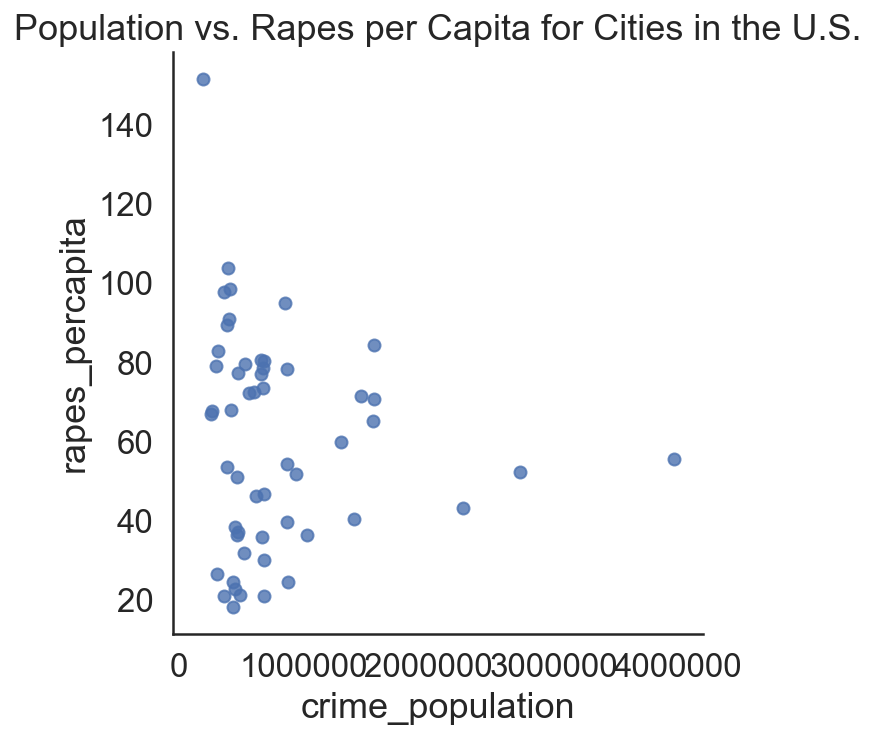

In [109]:
# scatterplot for year of 2015 to see relationship between population and rapes
sns.lmplot(x='crime_population', y='rapes_percapita', 
           data=merged_df[merged_df['year'] == 2015], fit_reg=False);
plt.title('Population vs. Rapes per Capita for Cities in the U.S.');

**We found two outliers: one with low population, but high rapes per capita; another one with really high population, but relatively low rapes per capita. Overall, doesn't seem to be a strong relationship between population and rapes per capita.**

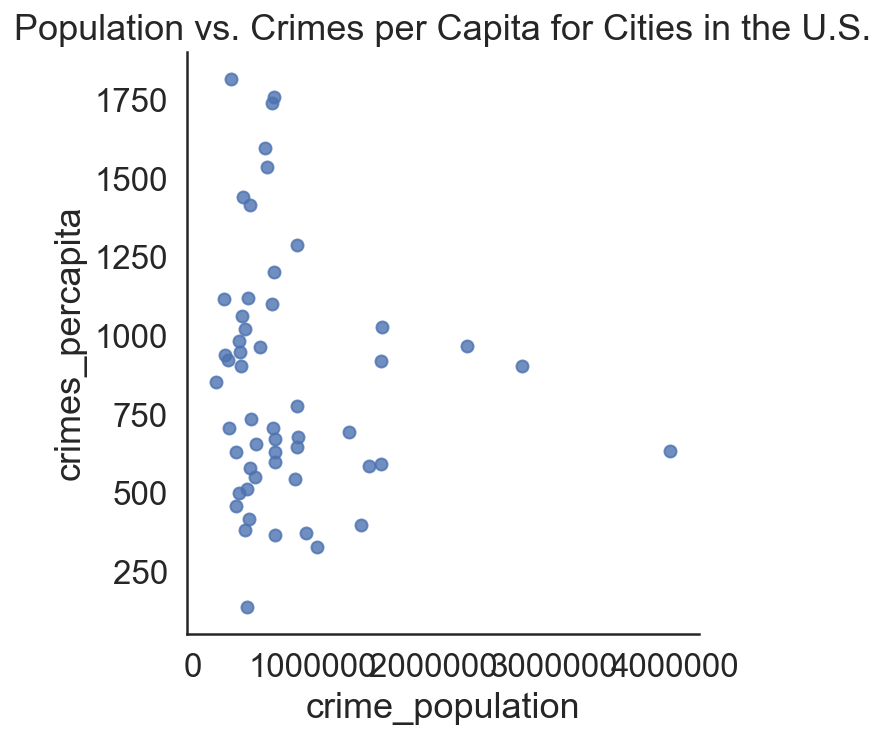

In [110]:
# scatterplot for year of 2015 to see relationship between population and crimes
sns.lmplot(x='crime_population', y='crimes_percapita', 
           data=merged_df[merged_df['year'] == 2015], fit_reg=False);
plt.title('Population vs. Crimes per Capita for Cities in the U.S.');

**We didn't seem to find a relationship between population and crimes per capita either.**

In [111]:
# From crime_population vs. rapes_percapita scatterplot, find city in 2015 that had low population but high rapes
merged_df[merged_df['year'] == 2015][merged_df['rapes_percapita'] > 120]

year           city_name  crime_population  violent_crimes  rapes  \
2101  2015  Salt Lake City, UT          191992.0          1642.0  291.0   

      crimes_percapita  rapes_percapita  fiscal_population  \
2101            855.24           151.57             191398   

      spending_direct_city  spending_general_city  transportation_city  \
2101                2678.6                2401.12              1134.23   

      public_safety_city  envir_housing_city  
2101               497.5              291.57

In [112]:
# From crime_population vs. rapes_percapita scatterplot, find city in 2015 that had high population but low rapes
merged_df[merged_df['year'] == 2015][merged_df['crime_population'] > 3500000]

year        city_name  crime_population  violent_crimes   rapes  \
2084  2015  Los Angeles, CA         3962726.0         25156.0  2209.0   

      crimes_percapita  rapes_percapita  fiscal_population  \
2084            634.82            55.74            3913260   

      spending_direct_city  spending_general_city  transportation_city  \
2084               4572.07                2536.47               753.44   

      public_safety_city  envir_housing_city  
2084              695.65              405.54

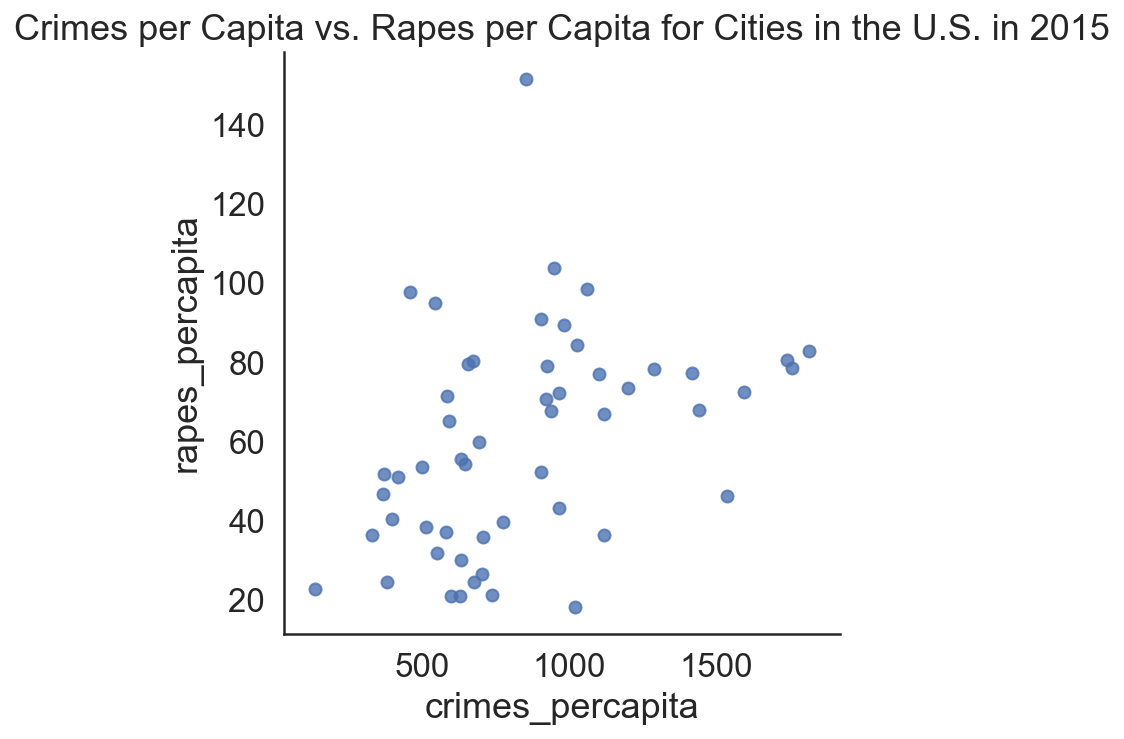

In [113]:
# scatterplot for year of 2015 to see relationship between crimes and rapes
sns.lmplot(x='crimes_percapita', y='rapes_percapita', 
           data=merged_df[merged_df['year'] == 2015], fit_reg=False);
plt.title('Crimes per Capita vs. Rapes per Capita for Cities in the U.S. in 2015');

**There seems to be somewhat of a positive linear relationship between crimes per capita and rapes per capita.**

In [114]:
merged_df[merged_df['crimes_percapita'] > 1200]

year          city_name  crime_population  violent_crimes   rapes  \
2     1977        Atlanta, GA          440300.0          7595.0   510.0   
5     1977      Baltimore, MD          827494.0         14283.0   499.0   
6     1977         Boston, MA          619321.0          9422.0   408.0   
11    1977      Cleveland, OH          638793.0          9421.0   508.0   
15    1977        Detroit, MI         1316352.0         24070.0  1277.0   
24    1977    Los Angeles, CA         2785393.0         33676.0  2339.0   
27    1977          Miami, FL          333713.0          5346.0   178.0   
32    1977        Oakland, CA          339264.0          5764.0   366.0   
44    1977  San Francisco, CA          676625.0          9367.0   595.0   
47    1977      St. Louis, MO          512059.0          9726.0   473.0   
48    1977          Tampa, FL          264848.0          3194.0   195.0   
52    1977     Washington, DC          690000.0          9843.0   402.0   
56    1978        Atlanta, GA          456000.0          8845.0   592.0   
59    1978      Baltimore, MD          781730.0         14659.0   554.0   
60    1978         Boston, MA          616225.0         10035.0   475.0   
65    1978      Cleveland, OH          614512.0          9697.0   507.0   
69    1978        Detroit, MI         1294359.0         21602.0  1288.0   
78    1978    Los Angeles, CA         2787525.0         36797.0  2467.0   
81    1978          Miami, FL          330060.0          6272.0   207.0   
85    1978    New Orleans, LA          559160.0          7635.0   406.0   
86    1978        Oakland, CA          327756.0          5374.0   351.0   
88    1978        Orlando, FL          118393.0          1620.0   107.0   
94    1978     Sacramento, CA          261465.0          3198.0   218.0   
98    1978  San Francisco, CA          658611.0         10509.0   583.0   
101   1978      St. Louis, MO          525123.0         10095.0   497.0   
102   1978          Tampa, FL          263175.0          3510.0   253.0   
106   1978     Washington, DC          674000.0          9515.0   447.0   
110   1979        Atlanta, GA          423103.0         10715.0   656.0   
113   1979      Baltimore, MD          790901.0         15523.0   564.0   
114   1979         Boston, MA          599582.0         11392.0   464.0   
...    ...                ...               ...             ...     ...   
1958  2013        Buffalo, NY          258789.0          3249.0   145.0   
1962  2013      Cleveland, OH          389181.0          5782.0   436.0   
1966  2013        Detroit, MI          699889.0         14501.0   613.0   
1970  2013   Indianapolis, IN          850220.0         10479.0   656.0   
1972  2013    Kansas City, MO          465514.0          5876.0   392.0   
1977  2013        Memphis, TN          657691.0         10890.0   458.0   
1980  2013      Milwaukee, WI          600805.0          8194.0   401.0   
1984  2013        Oakland, CA          403887.0          7984.0   180.0   
1999  2013      St. Louis, MO          318563.0          5077.0   333.0   
2004  2013     Washington, DC          646449.0          7880.0   393.0   
2008  2014        Atlanta, GA          454363.0          5577.0   151.0   
2011  2014      Baltimore, MD          623513.0          8346.0   245.0   
2013  2014        Buffalo, NY          258419.0          3173.0   173.0   
2017  2014      Cleveland, OH          388655.0          5205.0   495.0   
2021  2014        Detroit, MI          684694.0         13622.0   557.0   
2025  2014   Indianapolis, IN          858238.0         10768.0   573.0   
2027  2014    Kansas City, MO          468417.0          5892.0   412.0   
2032  2014        Memphis, TN          654922.0         11420.0   519.0   
2035  2014      Milwaukee, WI          600374.0          8914.0   396.0   
2039  2014        Oakland, CA          409994.0          6910.0   209.0   
2054  2014      St. Louis, MO          318574.0          5348.0   279.0   
2066  2015      Baltimore, MD  

In [115]:
merged_df['city_name'].unique()

array(['Albuquerque, NM', 'Arlington, TX', 'Atlanta, GA', 'Aurora, CO',
       'Austin, TX', 'Baltimore, MD', 'Boston, MA', 'Buffalo, NY',
       'Charlotte, NC', 'Chicago, IL', 'Cincinnati, OH', 'Cleveland, OH',
       'Columbus, OH', 'Dallas, TX', 'Denver, CO', 'Detroit, MI',
       'El Paso, TX', 'Fresno, CA', 'Houston, TX', 'Indianapolis, IN',
       'Jacksonville, FL', 'Kansas City, MO', 'Las Vegas, NV',
       'Long Beach, CA', 'Los Angeles, CA', 'Memphis, TN', 'Mesa, AZ',
       'Miami, FL', 'Milwaukee, WI', 'Minneapolis, MN', 'Nashville, TN',
       'New Orleans, LA', 'Oakland, CA', 'Omaha, NE', 'Orlando, FL',
       'Philadelphia, PA', 'Phoenix, AZ', 'Pittsburgh, PA',
       'Portland, OR', 'Raleigh, NC', 'Sacramento, CA',
       'Salt Lake City, UT', 'San Antonio, TX', 'San Diego, CA',
       'San Francisco, CA', 'San Jose, CA', 'Seattle, WA',
       'St. Louis, MO', 'Tampa, FL', 'Tucson, AZ', 'Tulsa, OK',
       'Virginia Beach, VA', 'Washington, DC', 'Wichita, KS',
       '

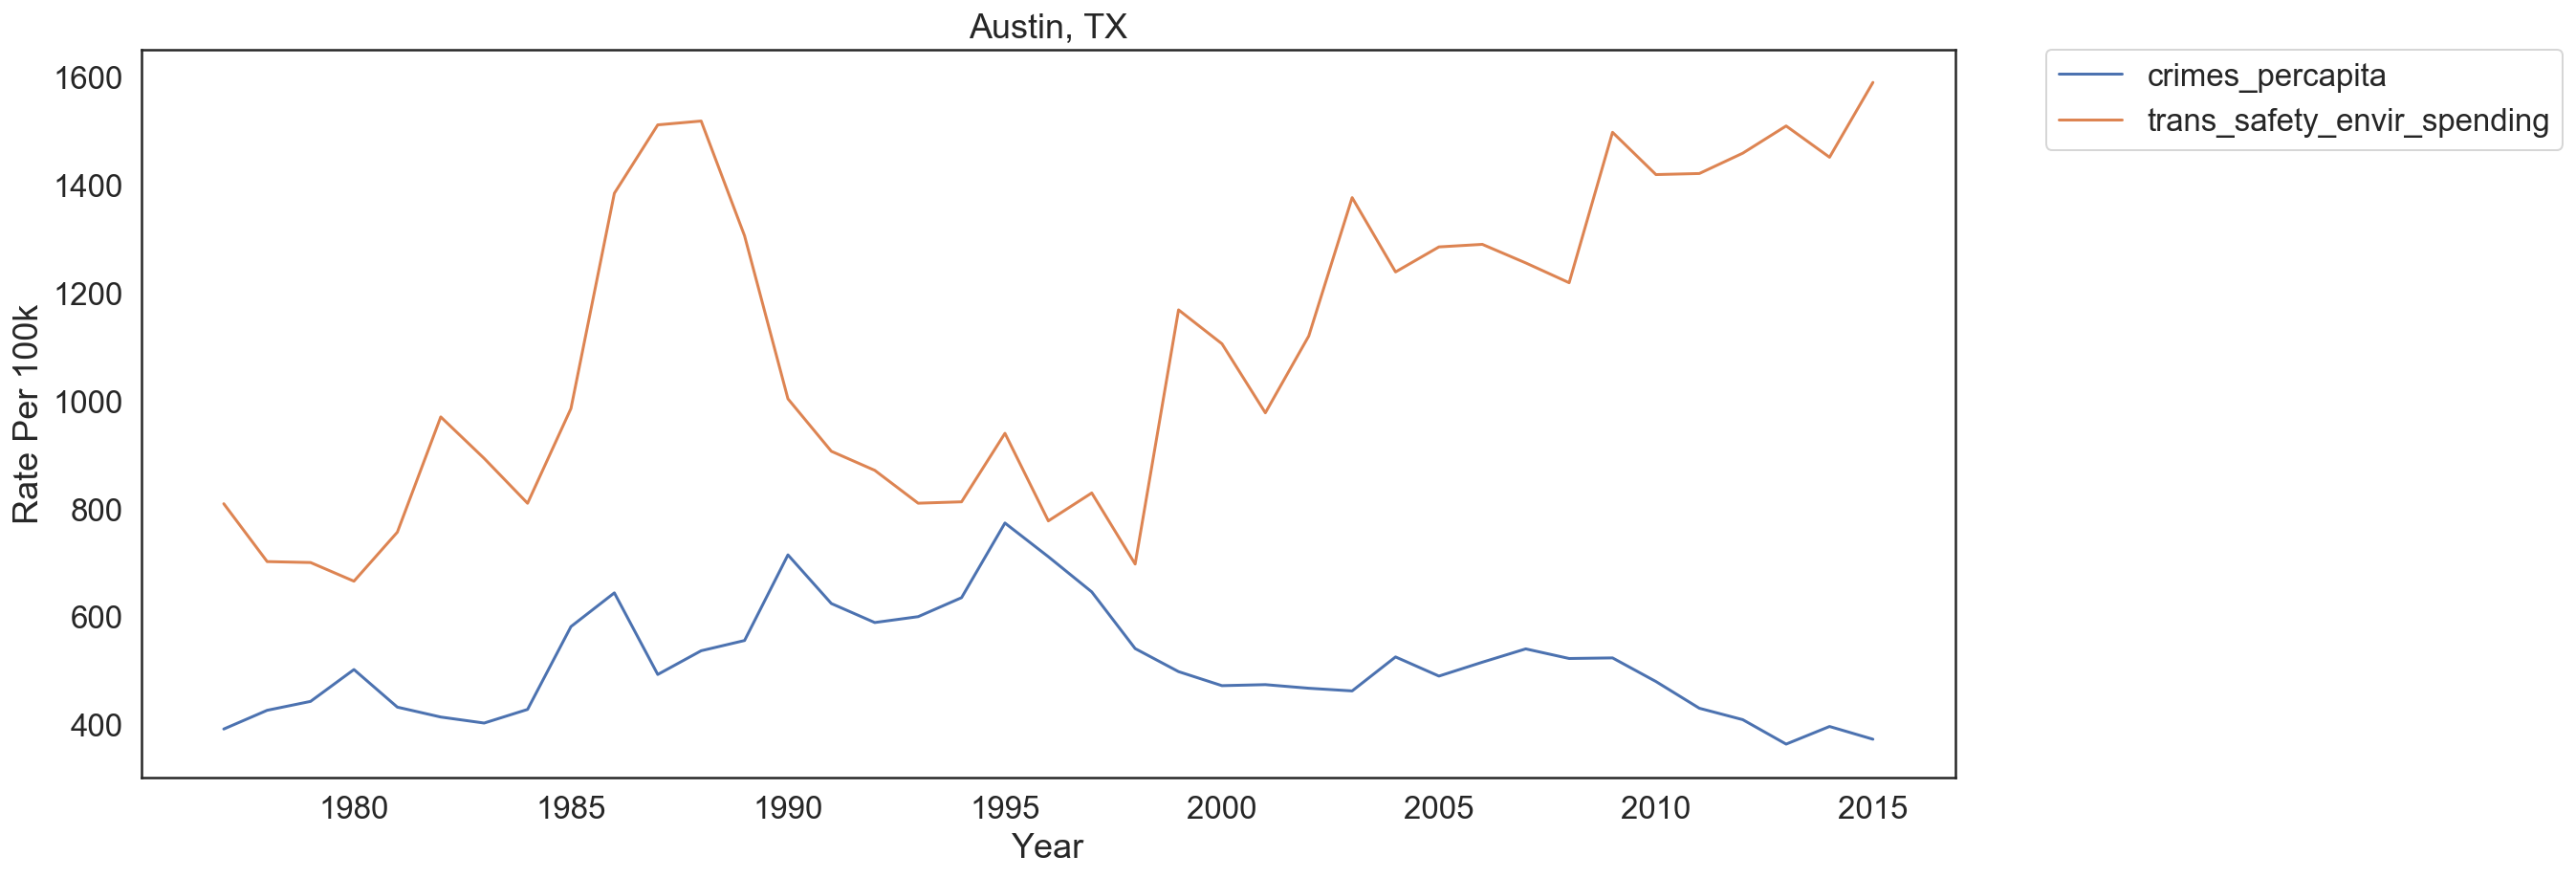

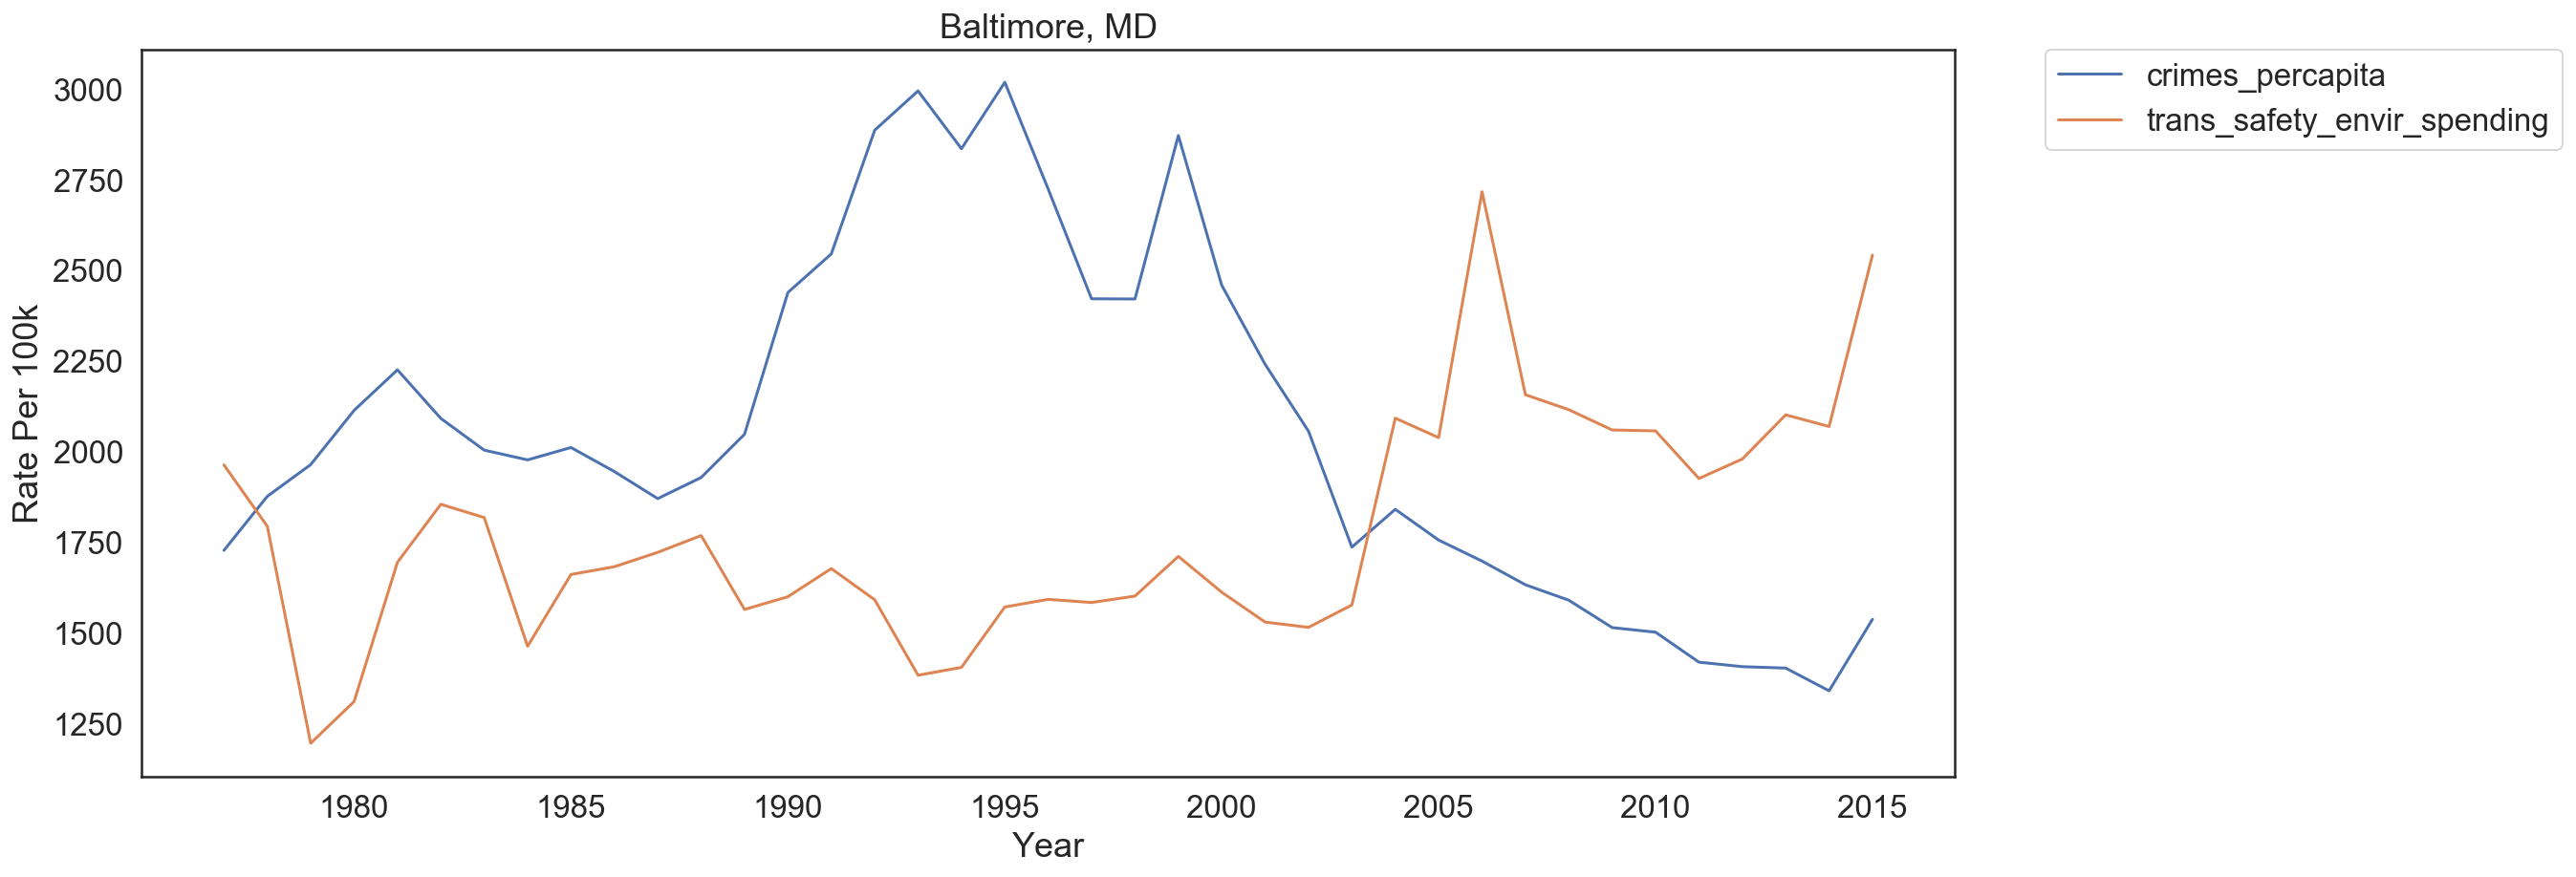

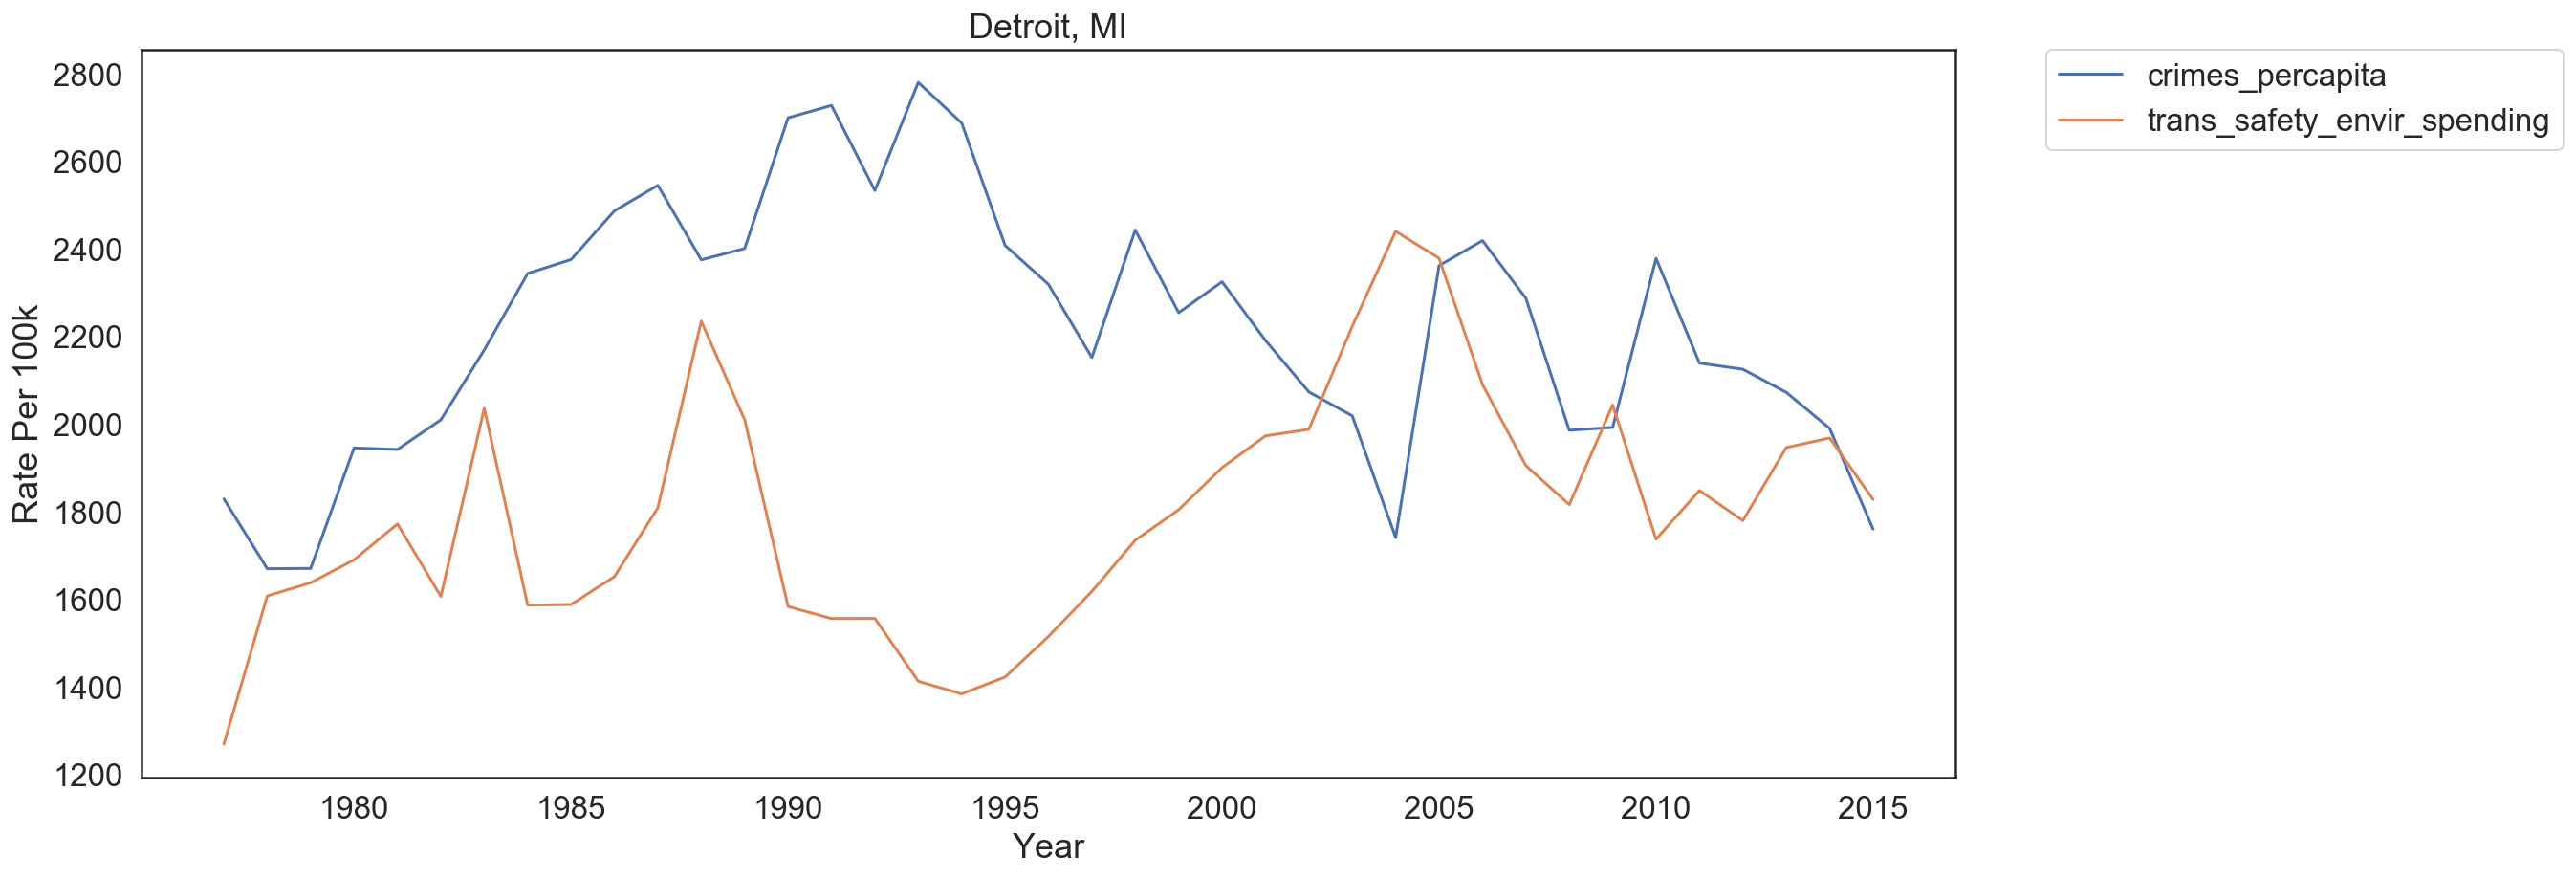

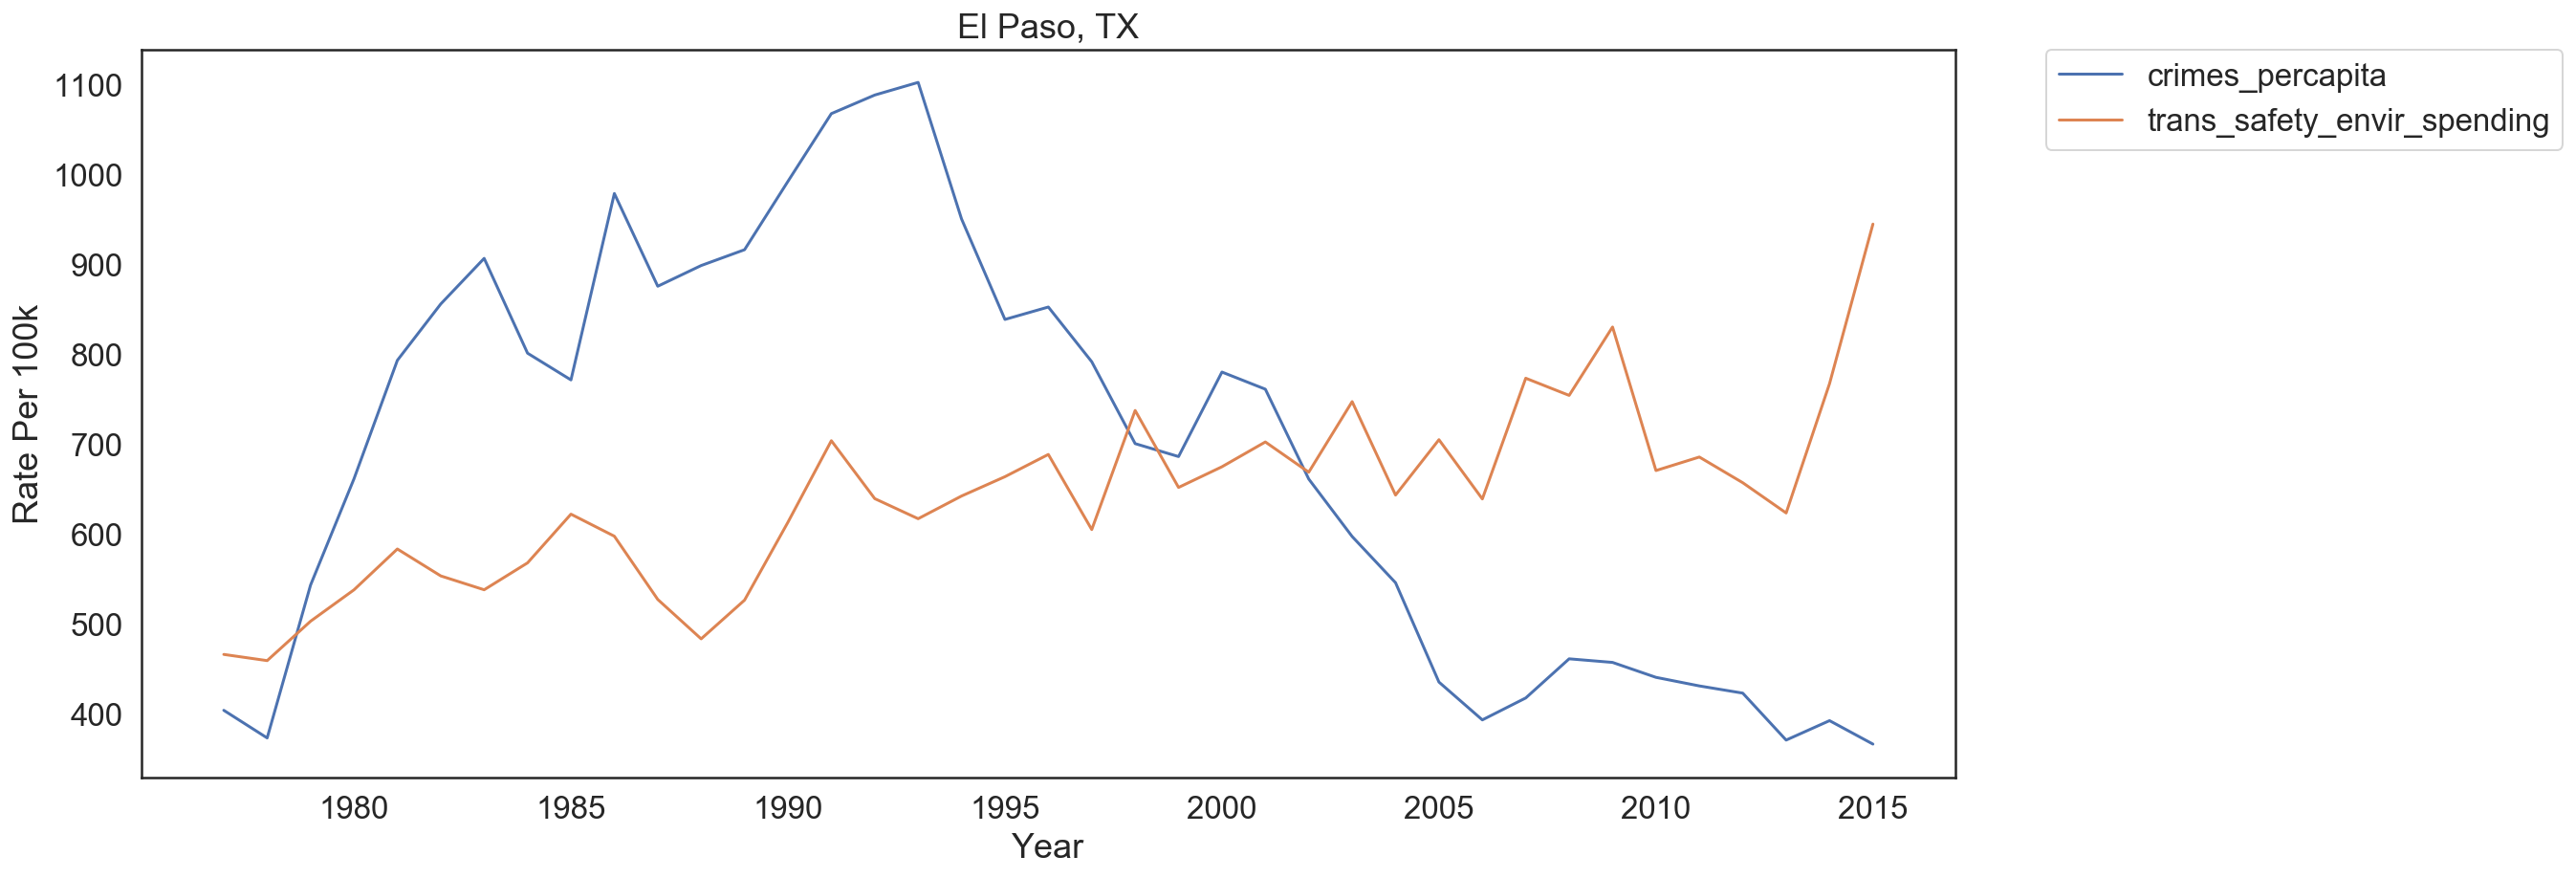

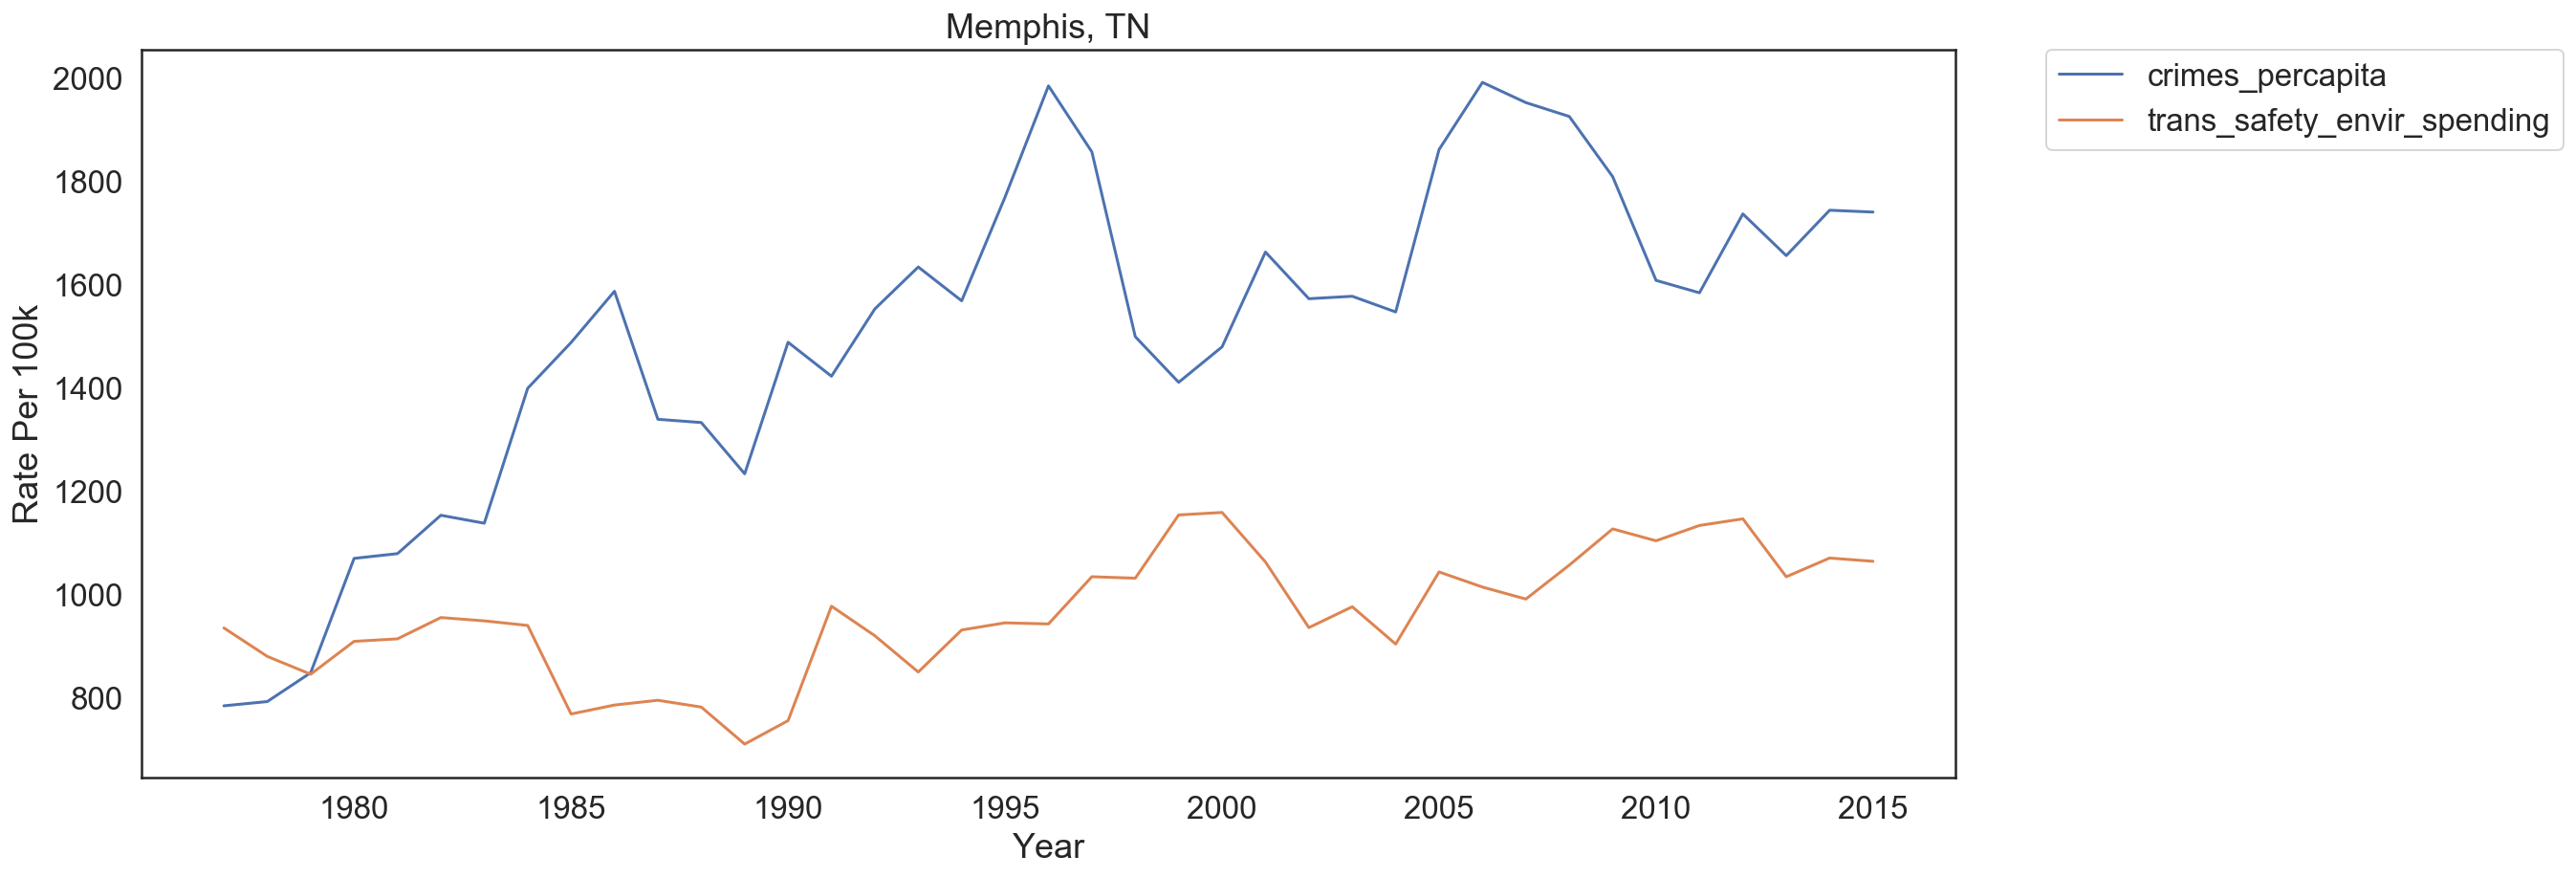

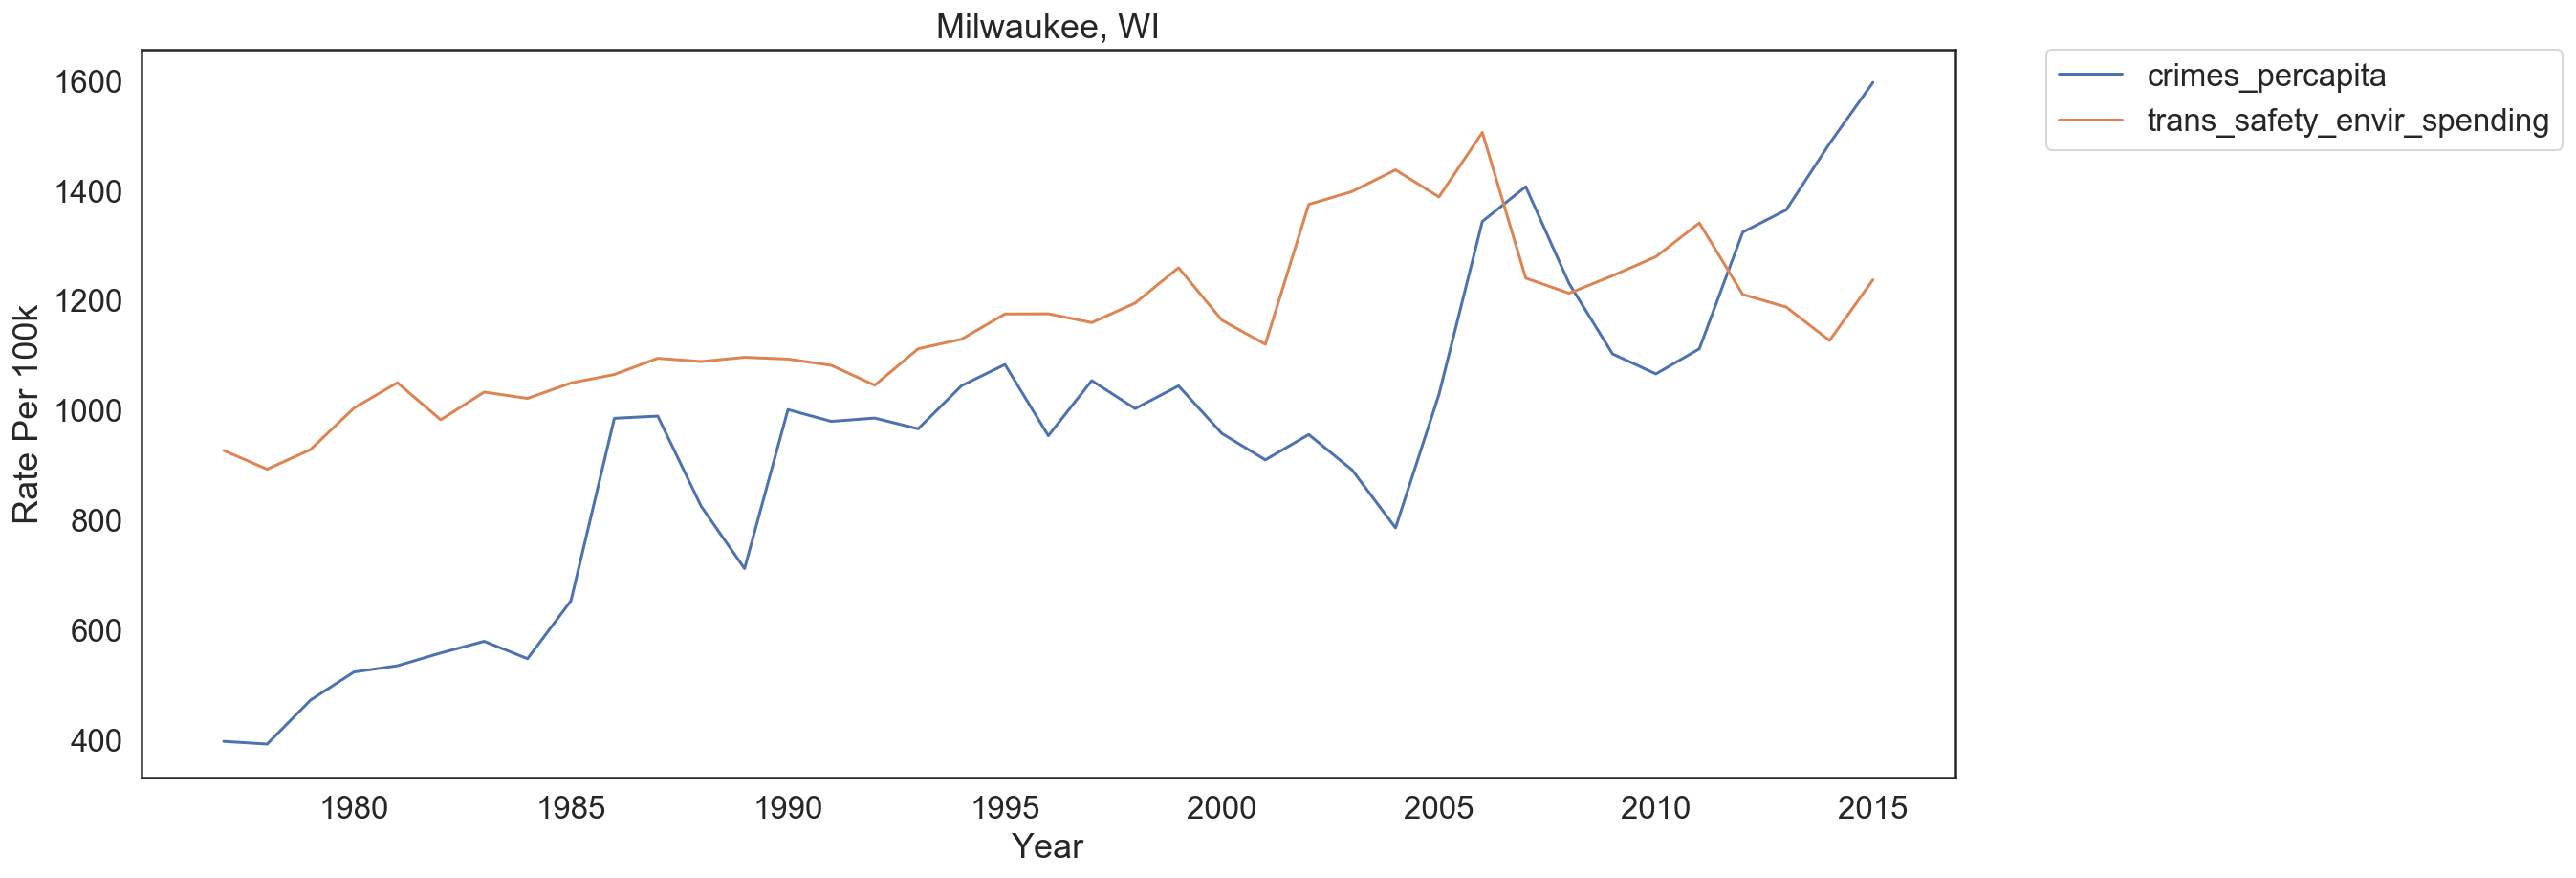

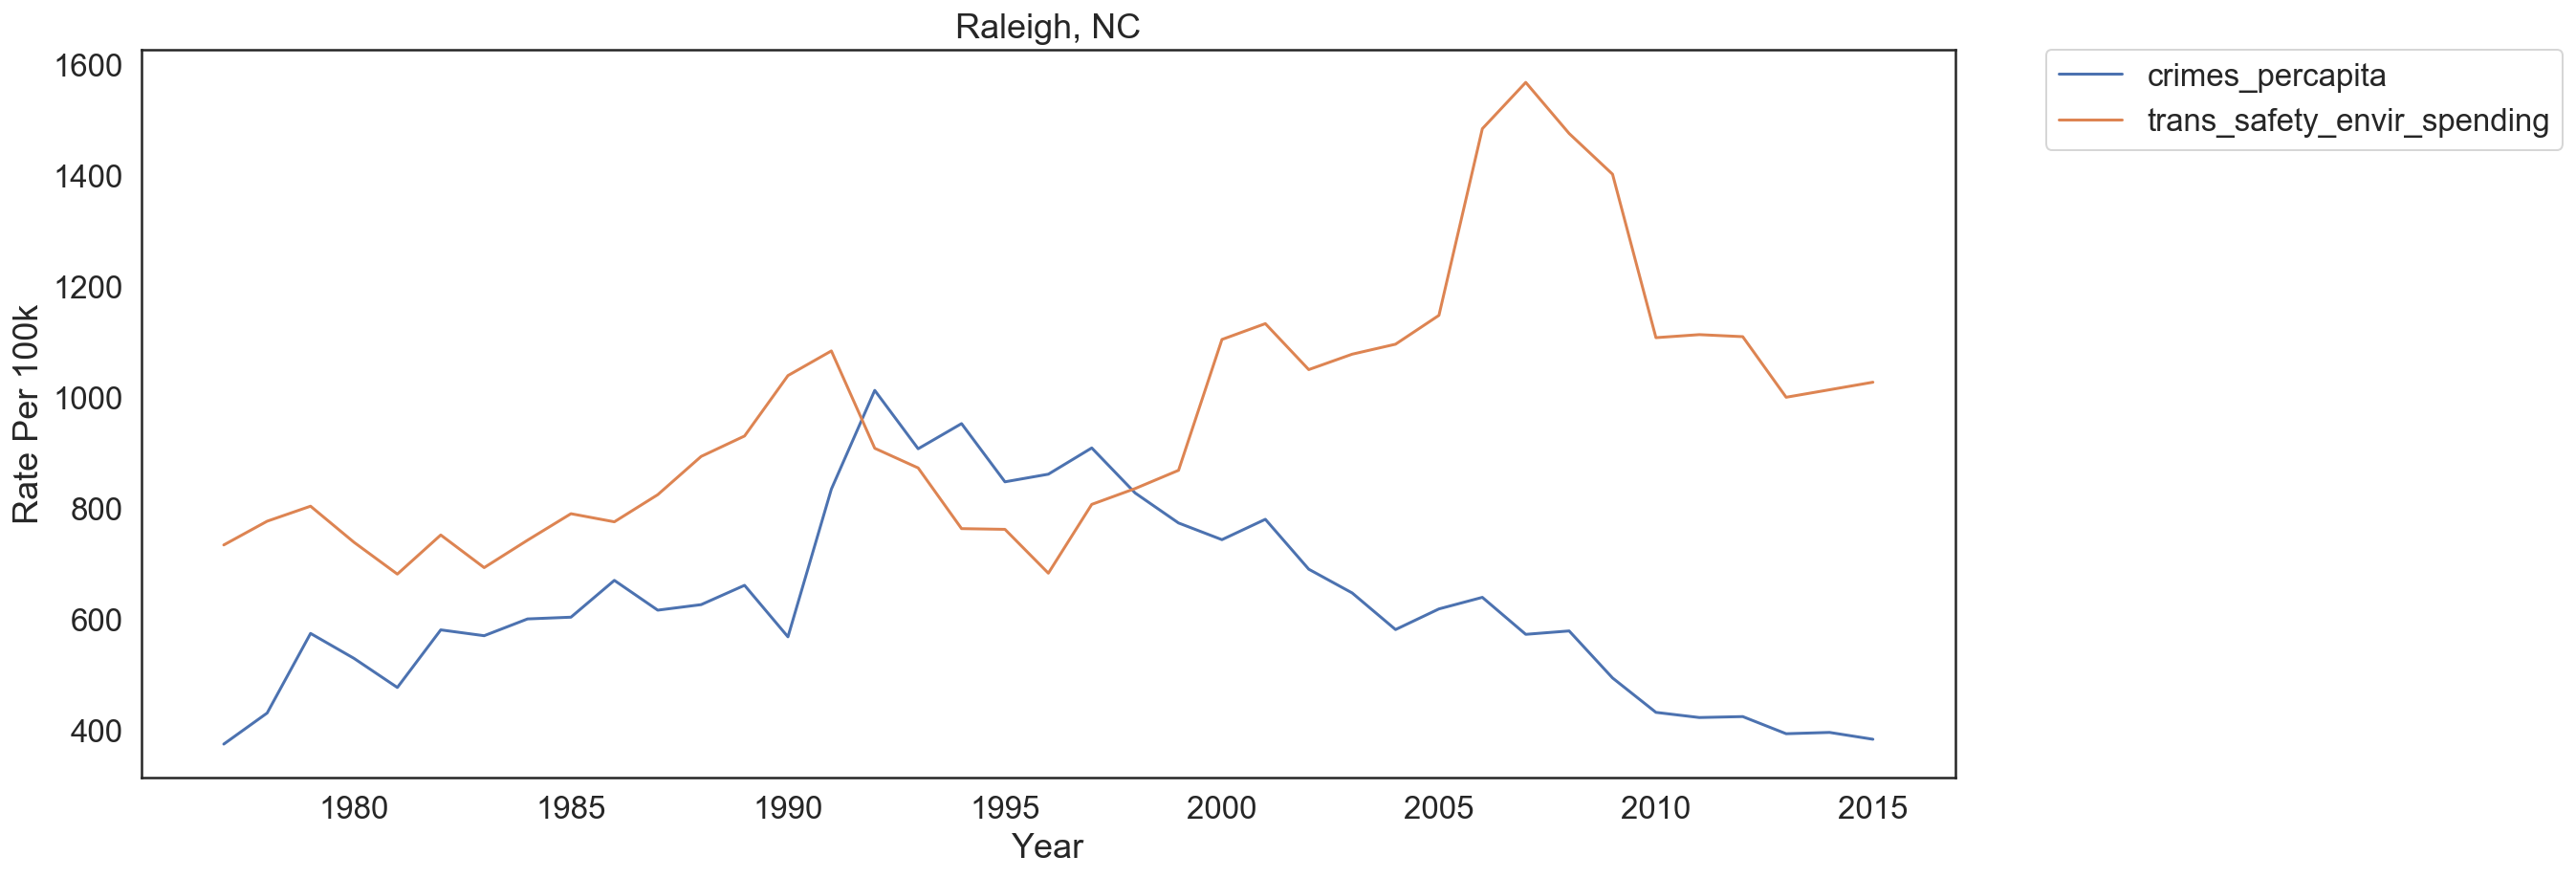

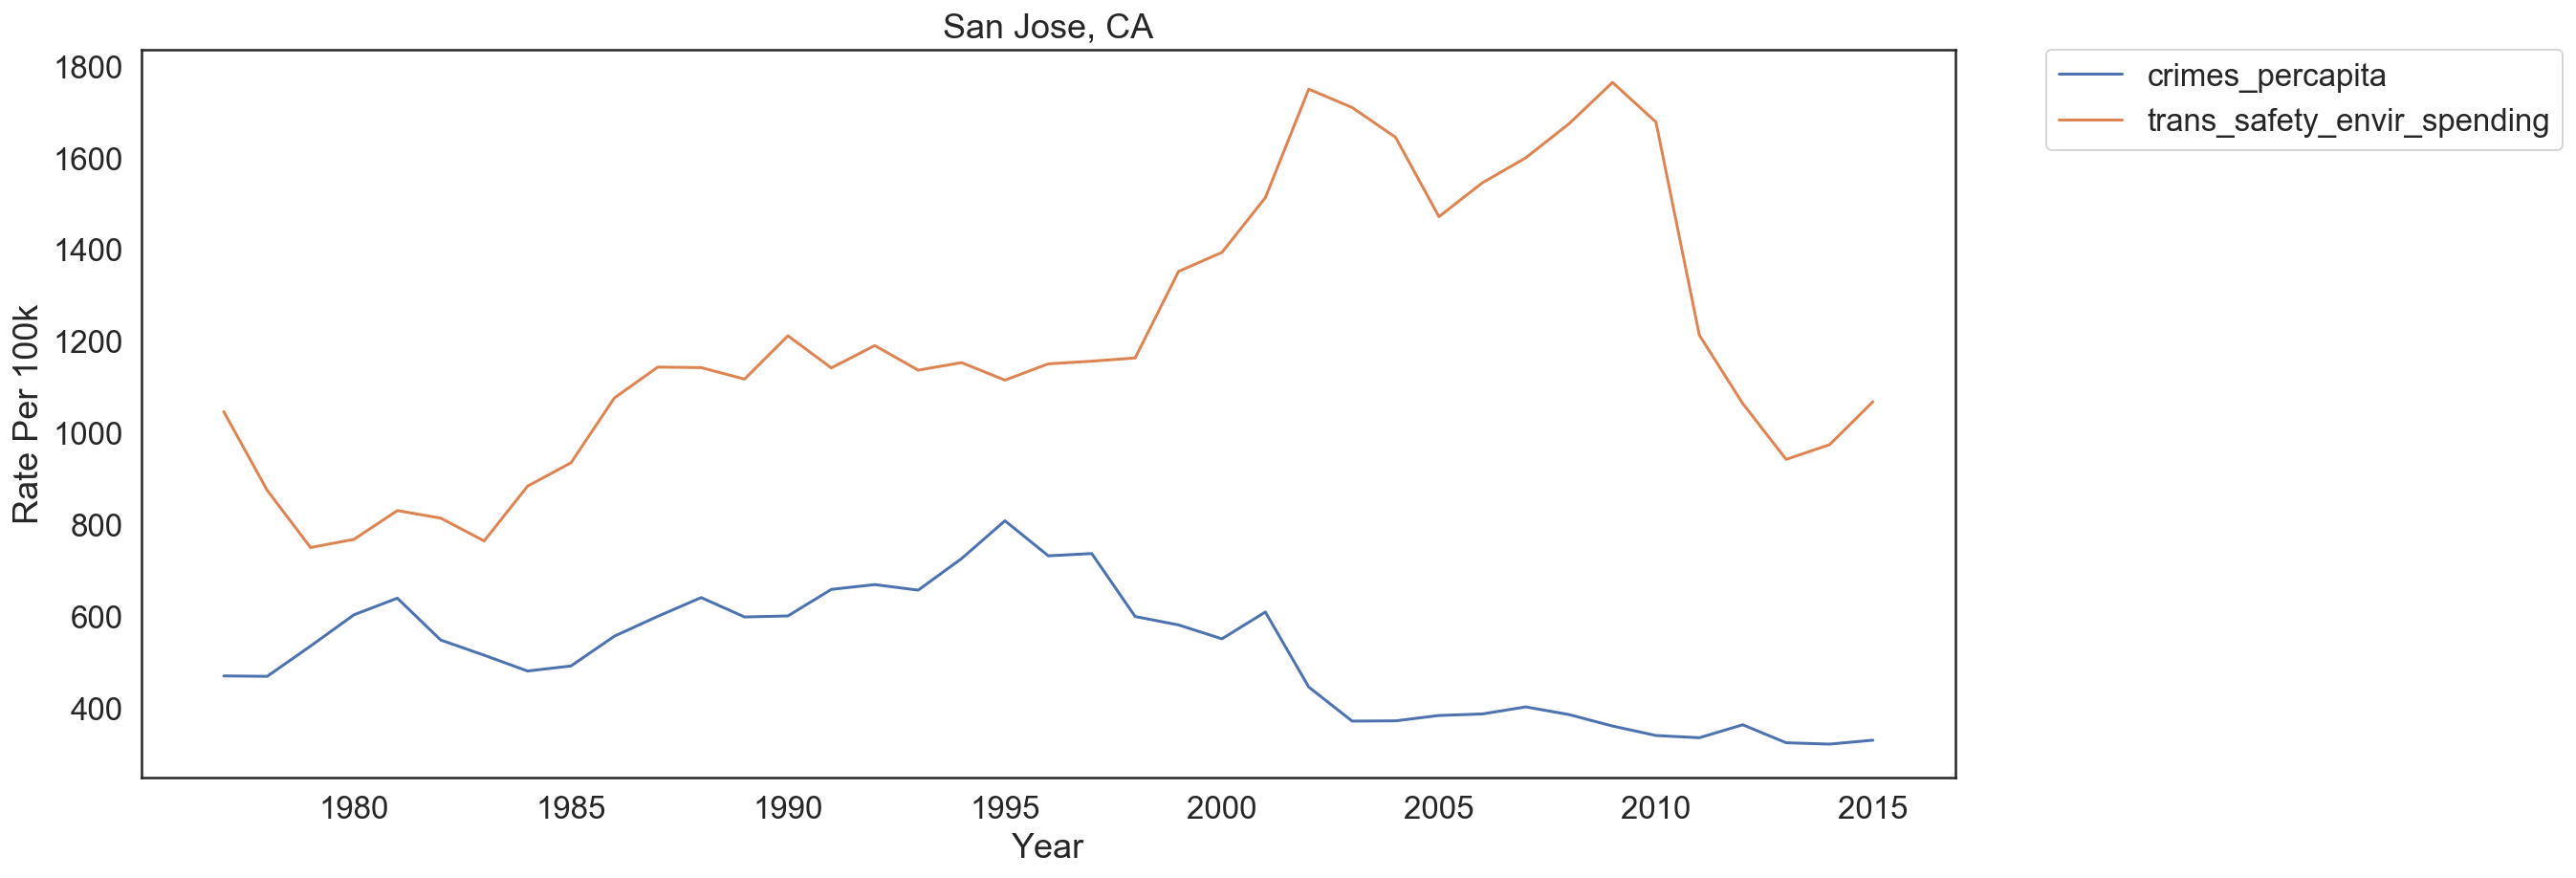

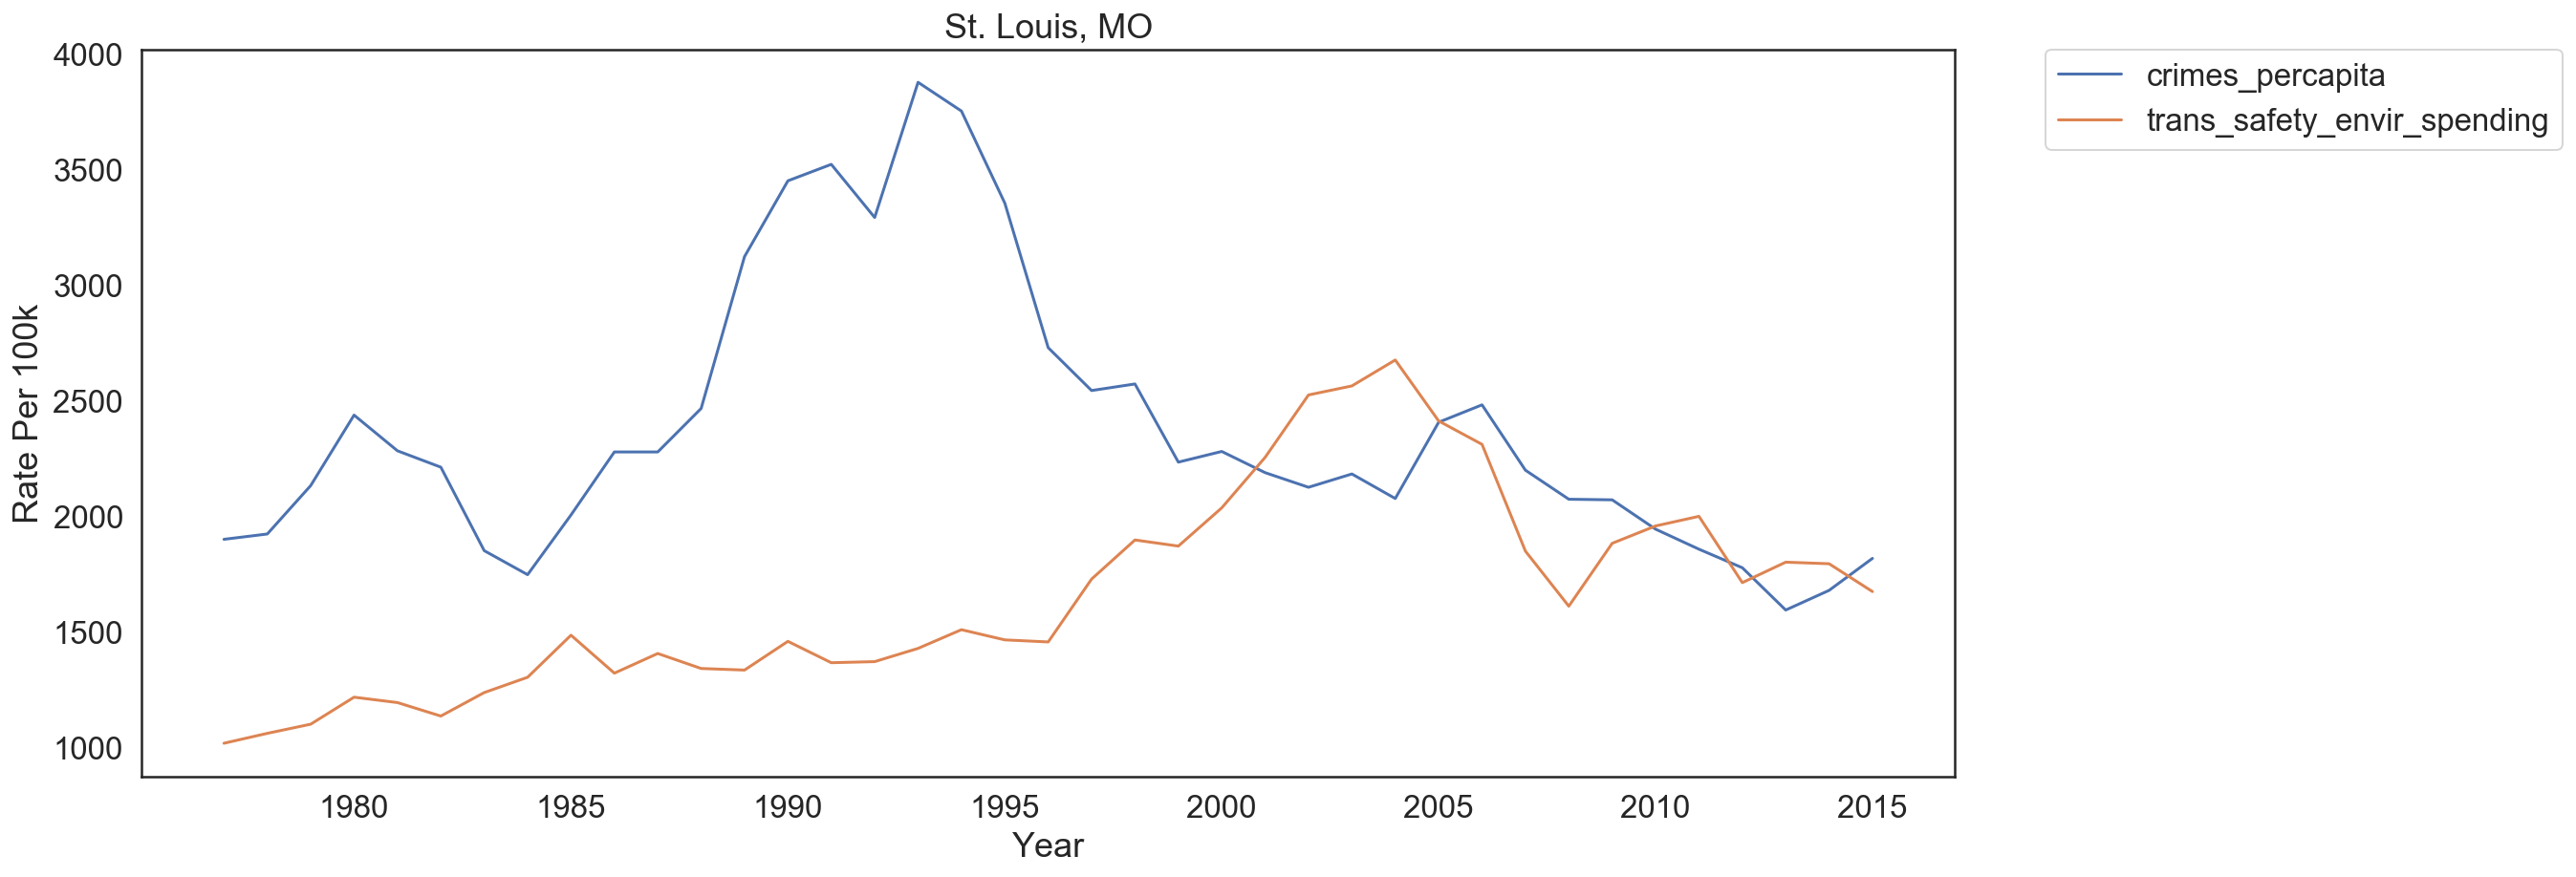

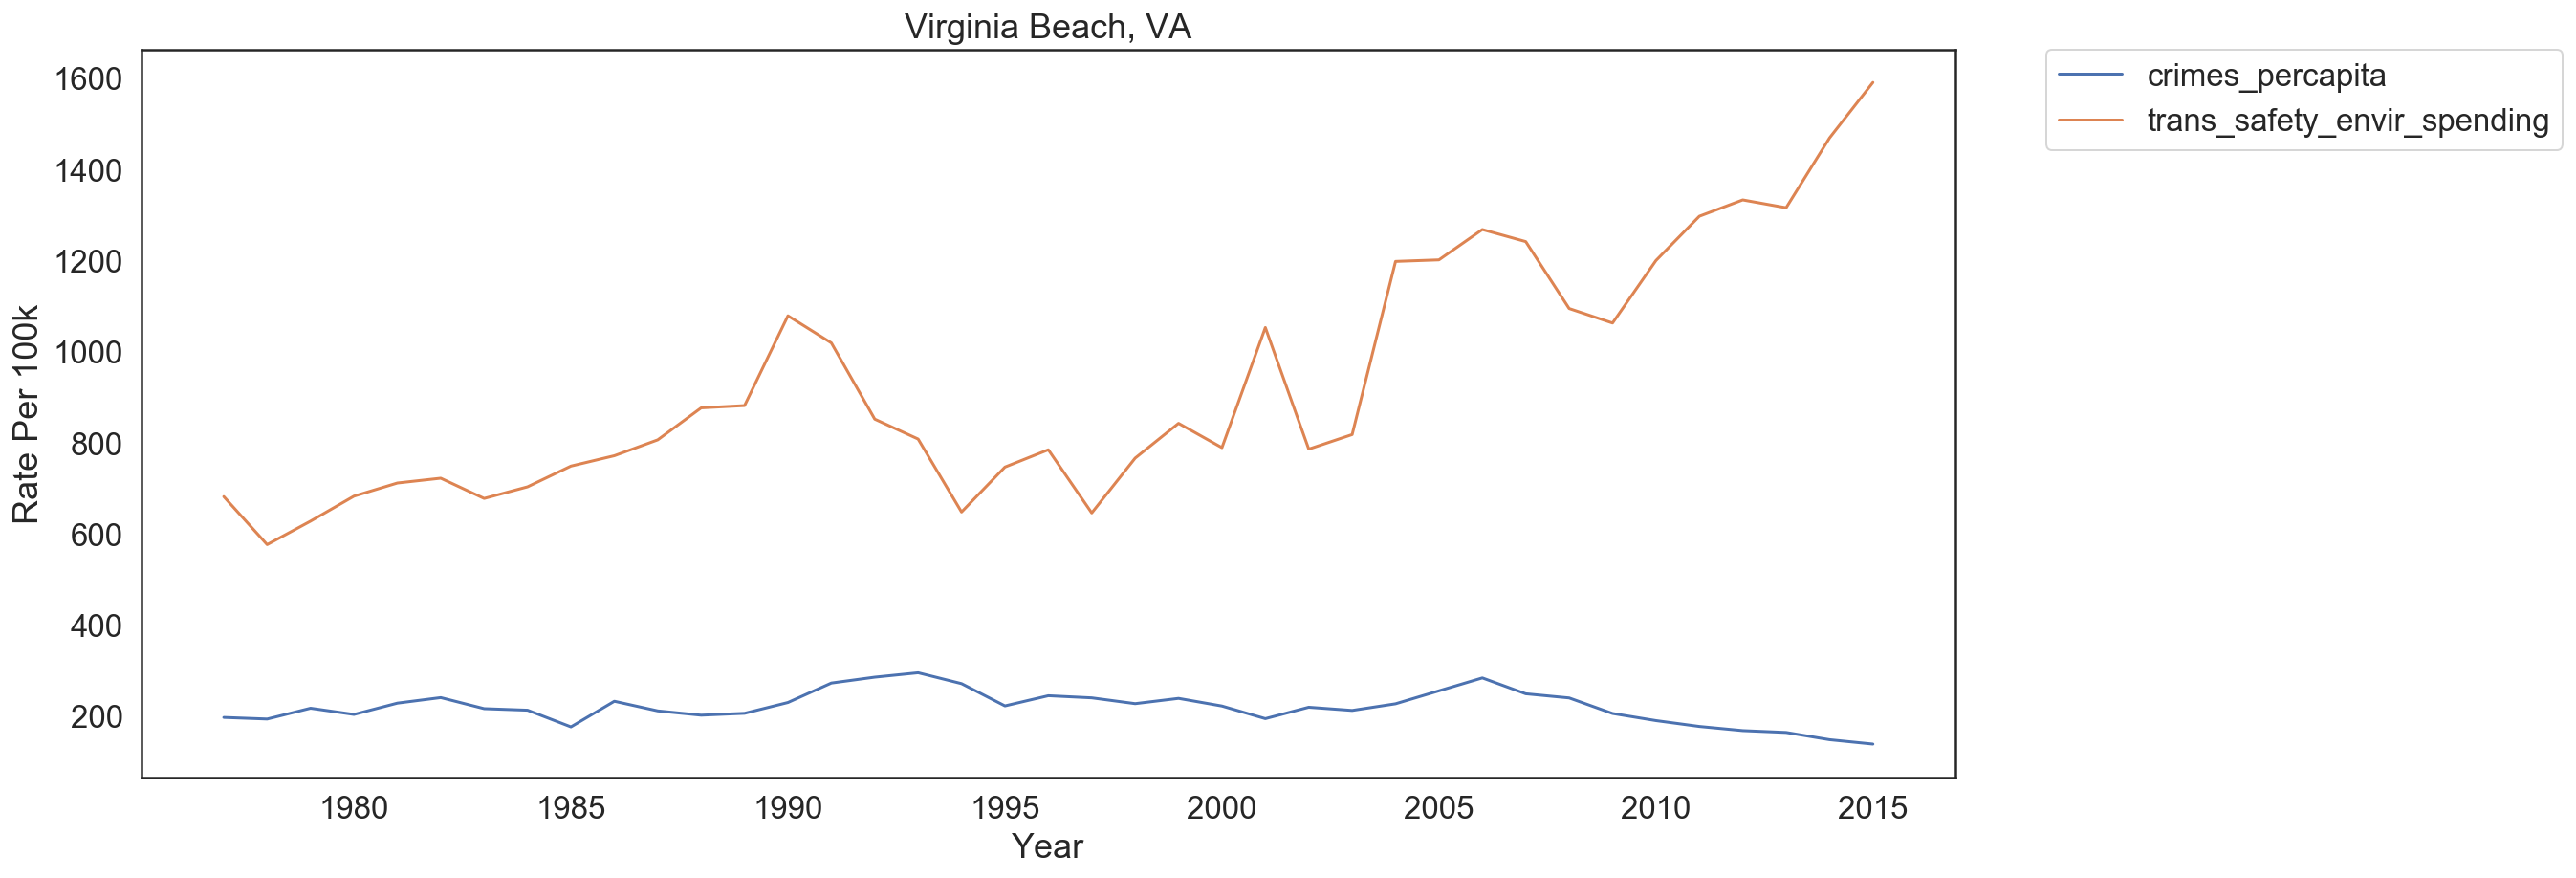

In [116]:
# Lineplots to see trends of crimes per capita and spending from our 3 categories over time for each city
# NOTE: y_label is incorrect, spending is NOT per 100k
for city_name in ranked_df['city_name'].unique():
    fig = ranked_df[ranked_df['city_name'] == city_name].plot(x='year', 
                                                        y=['crimes_percapita', 'trans_safety_envir_spending'],
                                                        title=city_name)
    fig.set_xlabel('Year')
    fig.set_ylabel('Rate Per 100k')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**Across our top 5 and bottom 5 cities, there doesn't seem to be a consistent trend of increased spending and decreased crimes per capita. Some cities show increases in crimes per capita in periods of low trans_safety_envir_spending, while some show no association between fluctuations in the two variables.** 

In [117]:
#Create 3D figure

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

# Scatter plot (year vs crimes per capita vs public safety spending)

#ax.scatter(ranked_df['year'], ranked_df['crimes_percapita'], ranked_df['public_safety_city'])
#ax.set_xlabel('Year', labelpad = 20)
#ax.set_ylabel('Crimes Per Capita', labelpad = 20)
#ax.set_zlabel('Public Safety Spending', labelpad = 10)

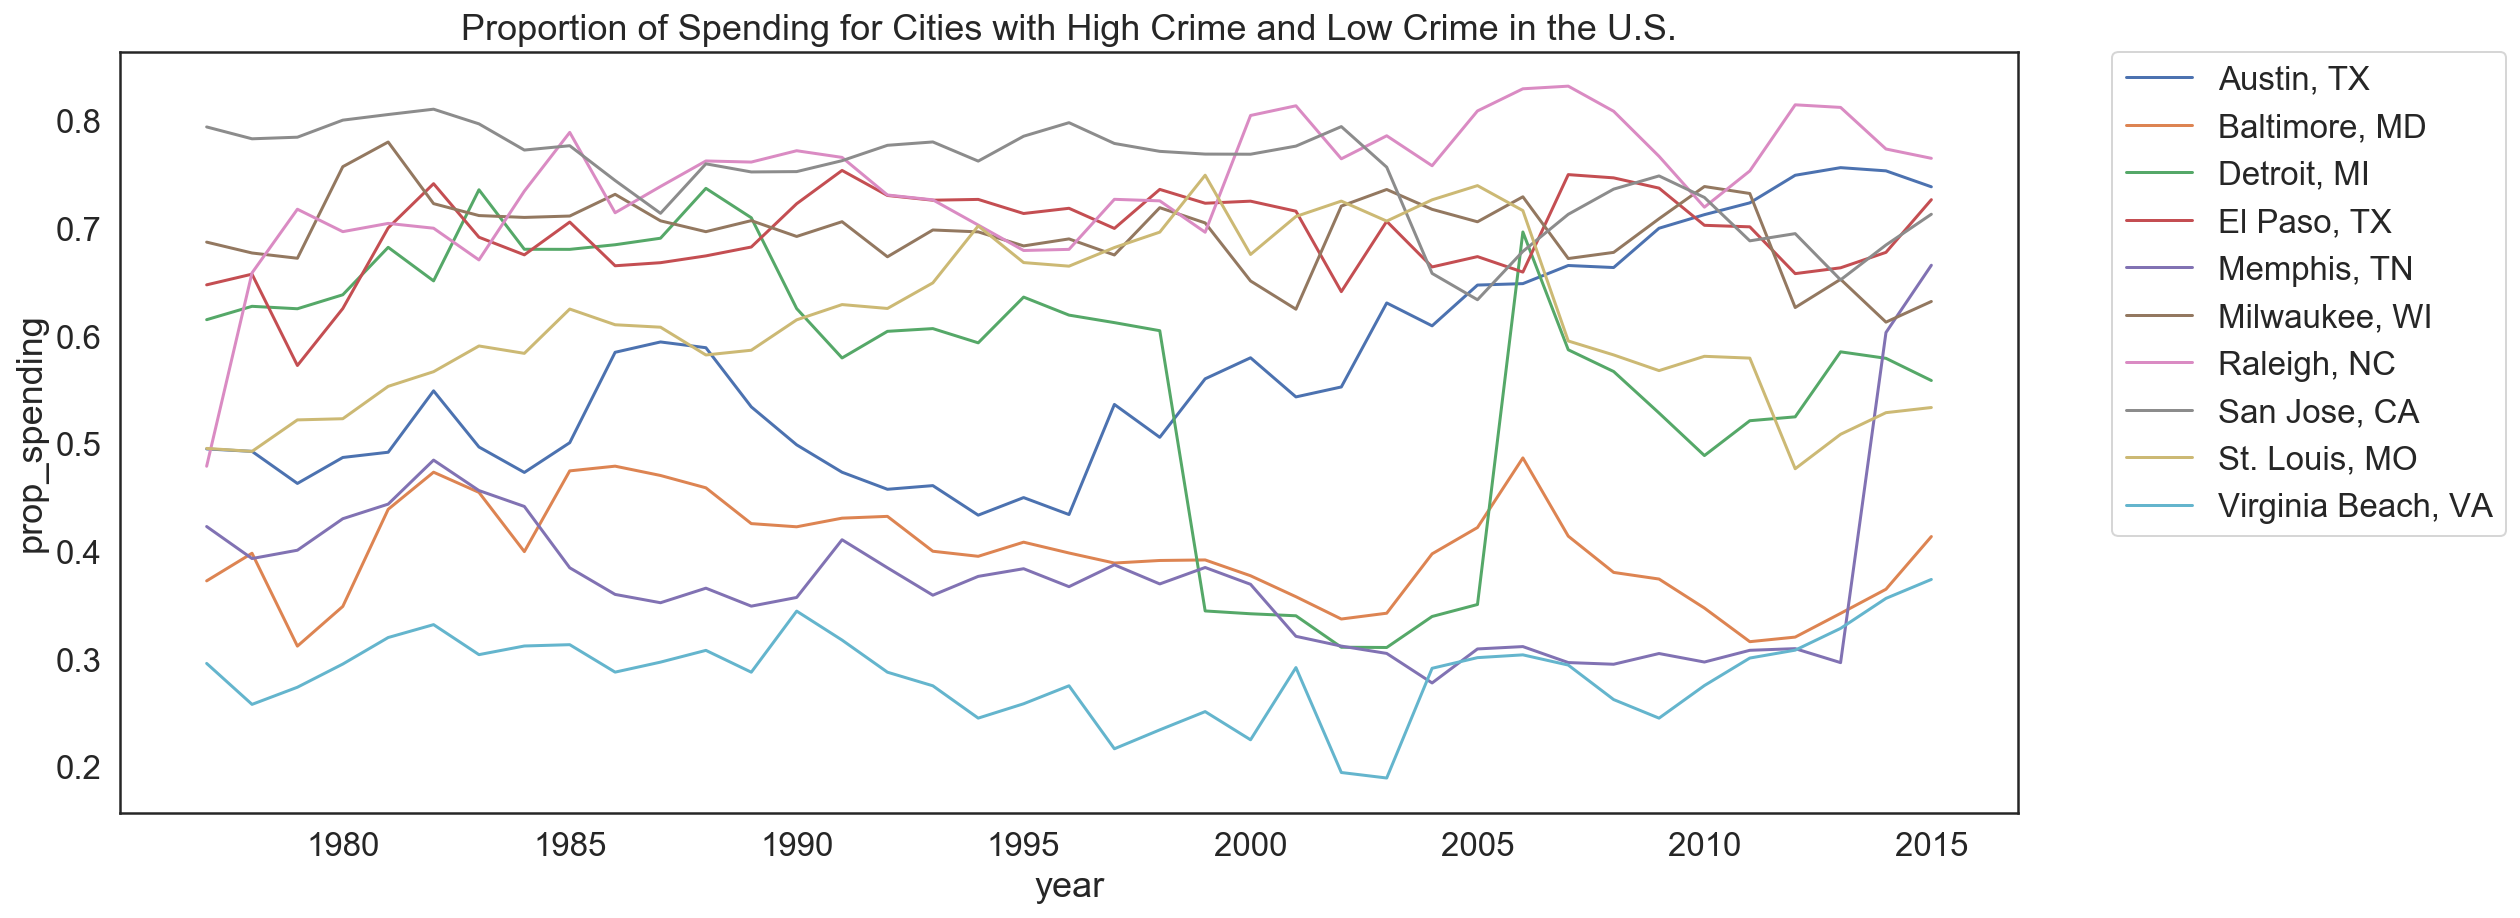

In [118]:
# Lineplot to show trend of proportion of spending over time for each city
sns.lineplot(x='year',y='prop_spending', hue='city_name', data=ranked_df);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Proportion of Spending for Cities with High Crime and Low Crime in the U.S.');

**Here, we can see how proportion of spending has changed over time for each city and observe periods of significant fluctuations. **

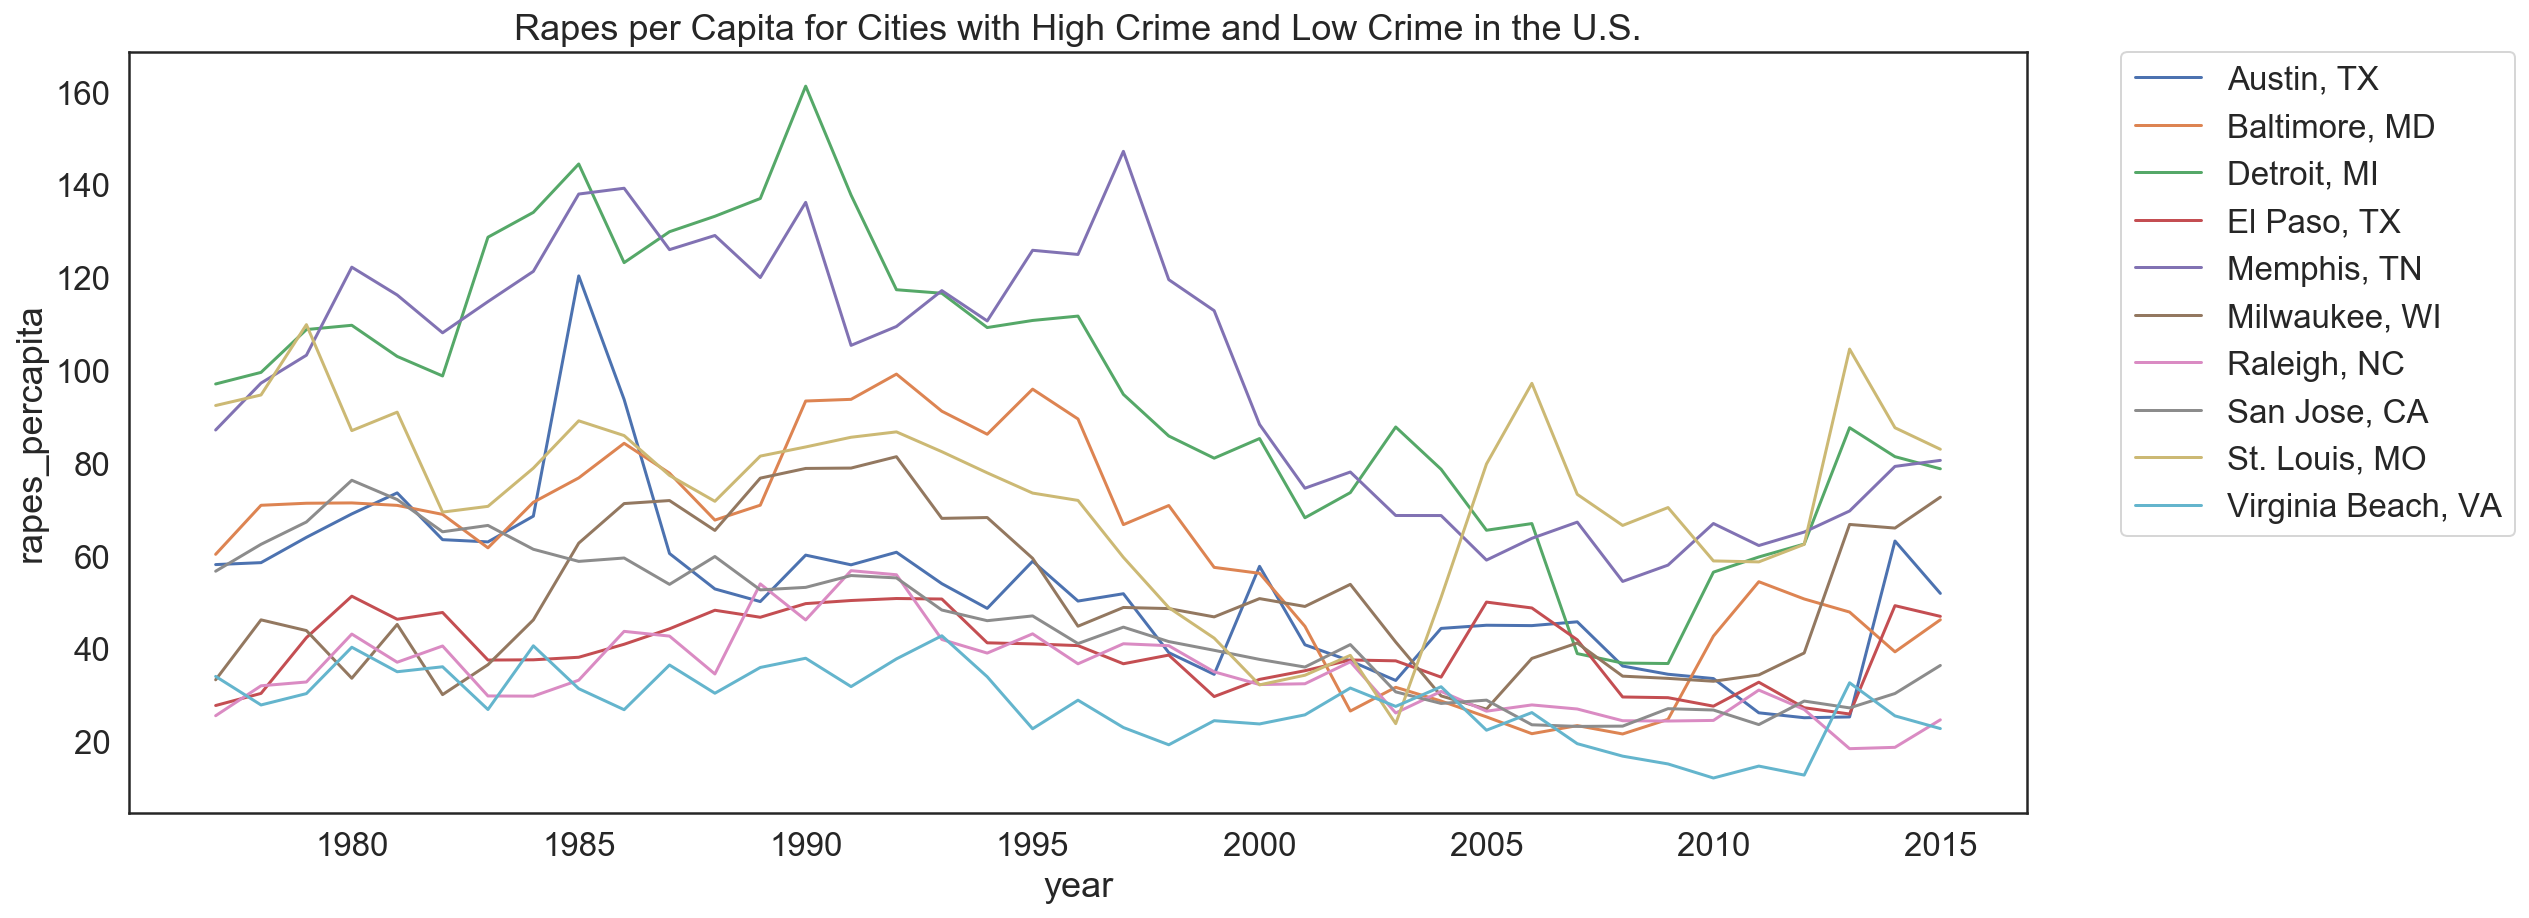

In [119]:
#Rapes per capita over time for each city
sns.lineplot(x='year',y='rapes_percapita', hue='city_name', data=ranked_df);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Rapes per Capita for Cities with High Crime and Low Crime in the U.S.');

**Here, we can see how rapes per capita has changed over time for each city and observe periods of significant fluctuations.**

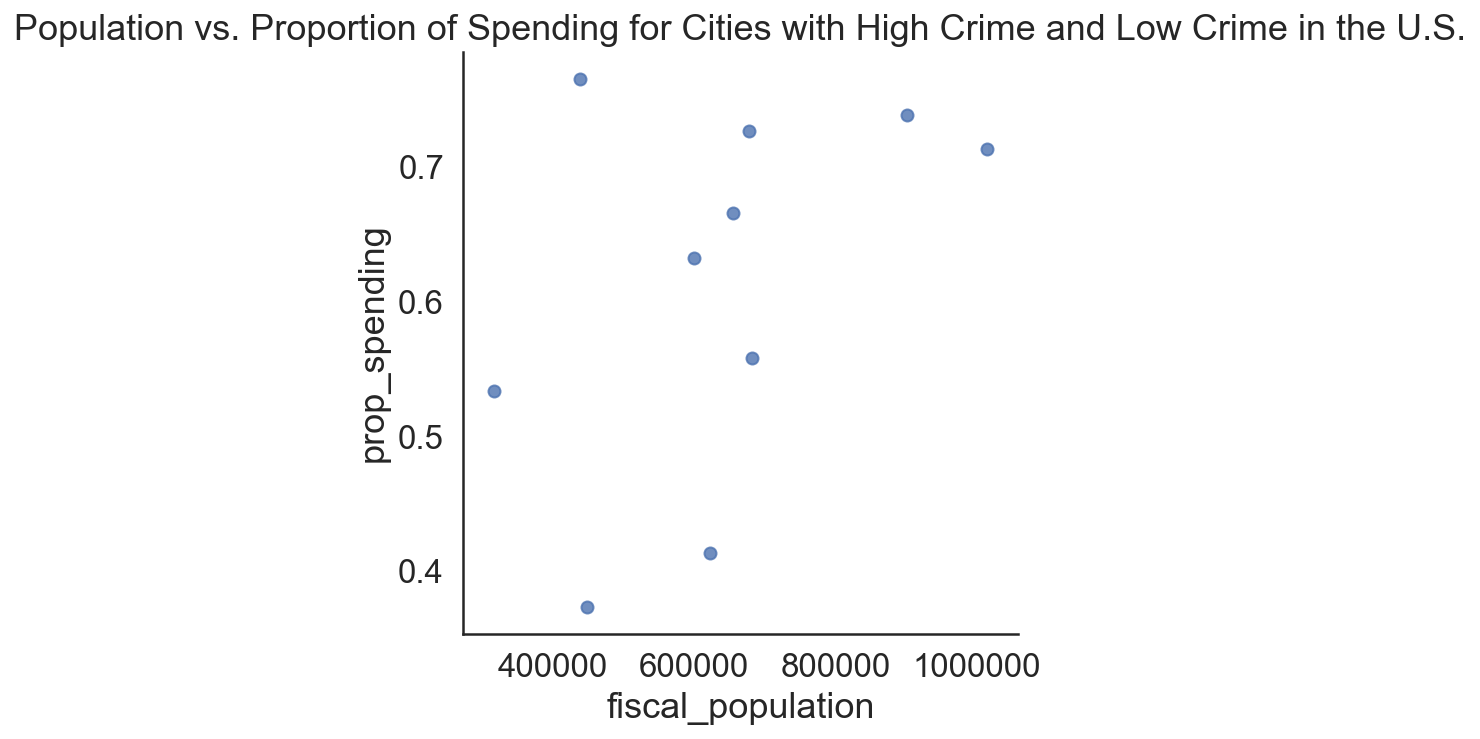

In [120]:
sns.lmplot(x='fiscal_population', y='prop_spending',
           data=ranked_df[ranked_df['year'] == 2015], fit_reg=False);
plt.title('Population vs. Proportion of Spending for Cities with High Crime and Low Crime in the U.S.');

**Looking at one year, there doesn't seem to be a strong relationship between population and the proportion of spending for our three categories combined.**

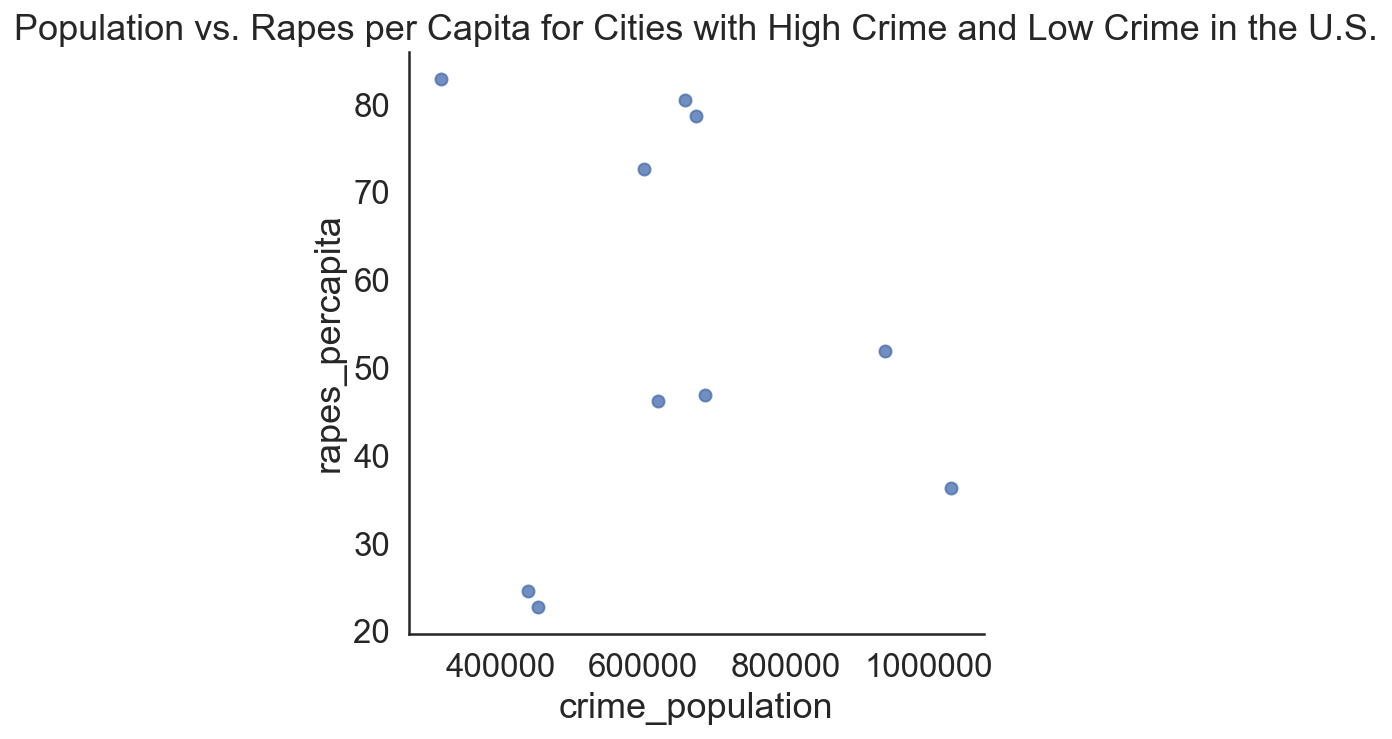

In [121]:
# scatterplot for year of 2015 to see relationship between population and rapes
sns.lmplot(x='crime_population', y='rapes_percapita', 
           data=ranked_df[ranked_df['year'] == 2015], fit_reg=False);
plt.title('Population vs. Rapes per Capita for Cities with High Crime and Low Crime in the U.S.');
#might need to take this out

**Looking at one year, there doesn't seem to be a strong relationship between population and the proportion of spending for our three categories combined. However, we noticed for 2015, our subset of data has a potential outlier that has low population but high rapes per capita. Additionally, there is a datapoint that has high population but relatively how rapes per capita.**

In [122]:
# Filter through data to find outlier of low population but high rapes per capita
ranked_df[ranked_df['year'] == 2015][ranked_df['rapes_percapita'] > 80]

year      city_name  crime_population  violent_crimes  rapes  \
384  2015    Memphis, TN          657936.0         11449.0  530.0   
388  2015  St. Louis, MO          317095.0          5762.0  263.0   

     crimes_percapita  rapes_percapita  fiscal_population  \
384           1740.14            80.55             655936   
388           1817.12            82.94             317395   

     spending_direct_city  spending_general_city  transportation_city  \
384               4815.87                1598.23                46.54   
388               3761.60                3137.09               493.65   

     public_safety_city  envir_housing_city crime_ranking  \
384              626.90              390.43         Top 5   
388             1003.56              176.24         Top 5   

     trans_safety_envir_spending  prop_spending  prop_rapes  
384                      1063.87       0.665655    0.046289  
388                      1673.45       0.533440    0.045644

In [123]:
# Filter through data to find datapoint of high population but relatively low rapes per capita
ranked_df[ranked_df['year'] == 2015][ranked_df['rapes_percapita'] < 40]

year           city_name  crime_population  violent_crimes  rapes  \
386  2015         Raleigh, NC          438363.0          1676.0  108.0   
387  2015        San Jose, CA         1031458.0          3400.0  375.0   
389  2015  Virginia Beach, VA          452797.0           626.0  103.0   

     crimes_percapita  rapes_percapita  fiscal_population  \
386            382.33            24.64             439347   
387            329.63            36.36            1014418   
389            138.25            22.75             448913   

     spending_direct_city  spending_general_city  transportation_city  \
386               1781.26                1341.24                77.32   
387               1876.38                1497.40               167.00   
389               4404.94                4255.16               403.12   

     public_safety_city  envir_housing_city crime_ranking  \
386              463.33              485.36      Bottom 5   
387              423.00              477.69      Bottom 5   
389              461.51              725.60      Bottom 5   

     trans_safety_envir_spending  prop_spending  prop_rapes  
386                      1026.01       0.764971    0.064447  
387                      1067.69       0.713029    0.110305  
389                      1590.23       0.373718    0.164557

In [124]:
# Might need to convert all fiscal spending variables by multiplying by 100,000 to get same "per capita" as crime
# Right now, per capita for fiscal literally means per person, not per 100,000 people

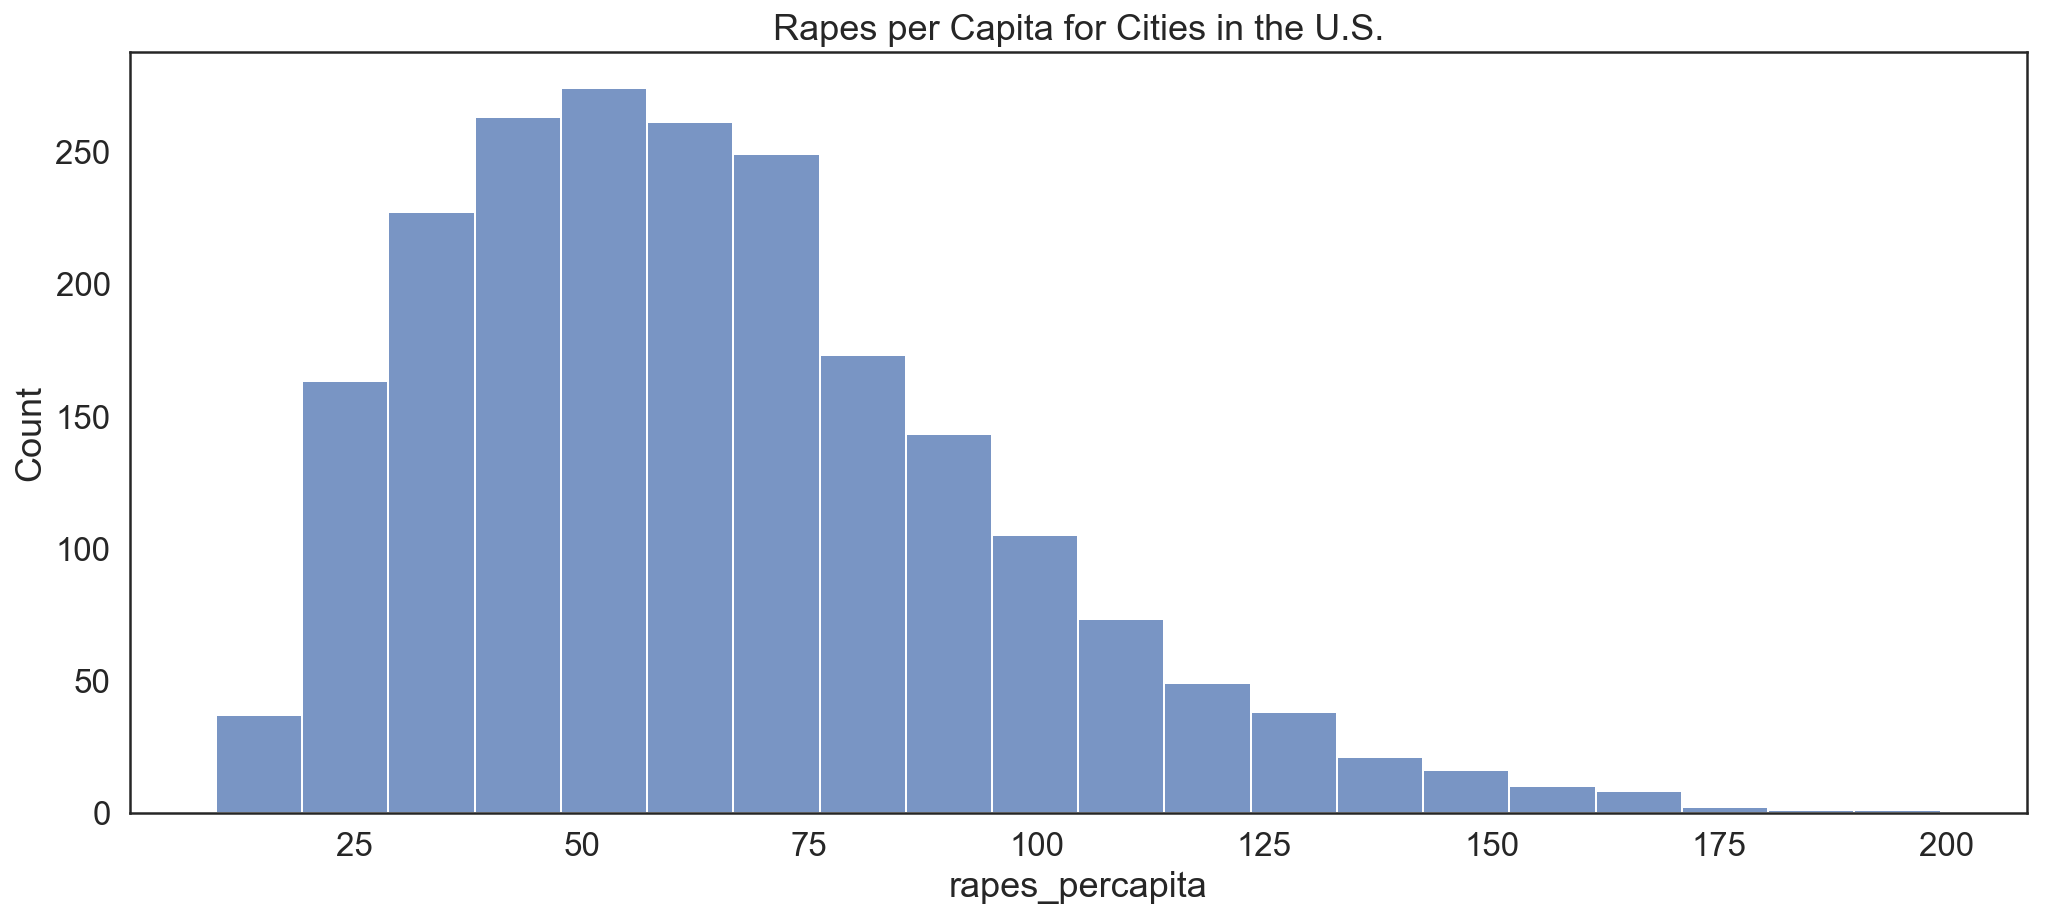

In [125]:
# Find distribution of rapes per capita from our entire merged_df dataset
sns.histplot(data=merged_df, x='rapes_percapita', bins=20, kde=False);
plt.title('Rapes per Capita for Cities in the U.S.');

**For all of our years, this variable shows a skewed right distribution.**

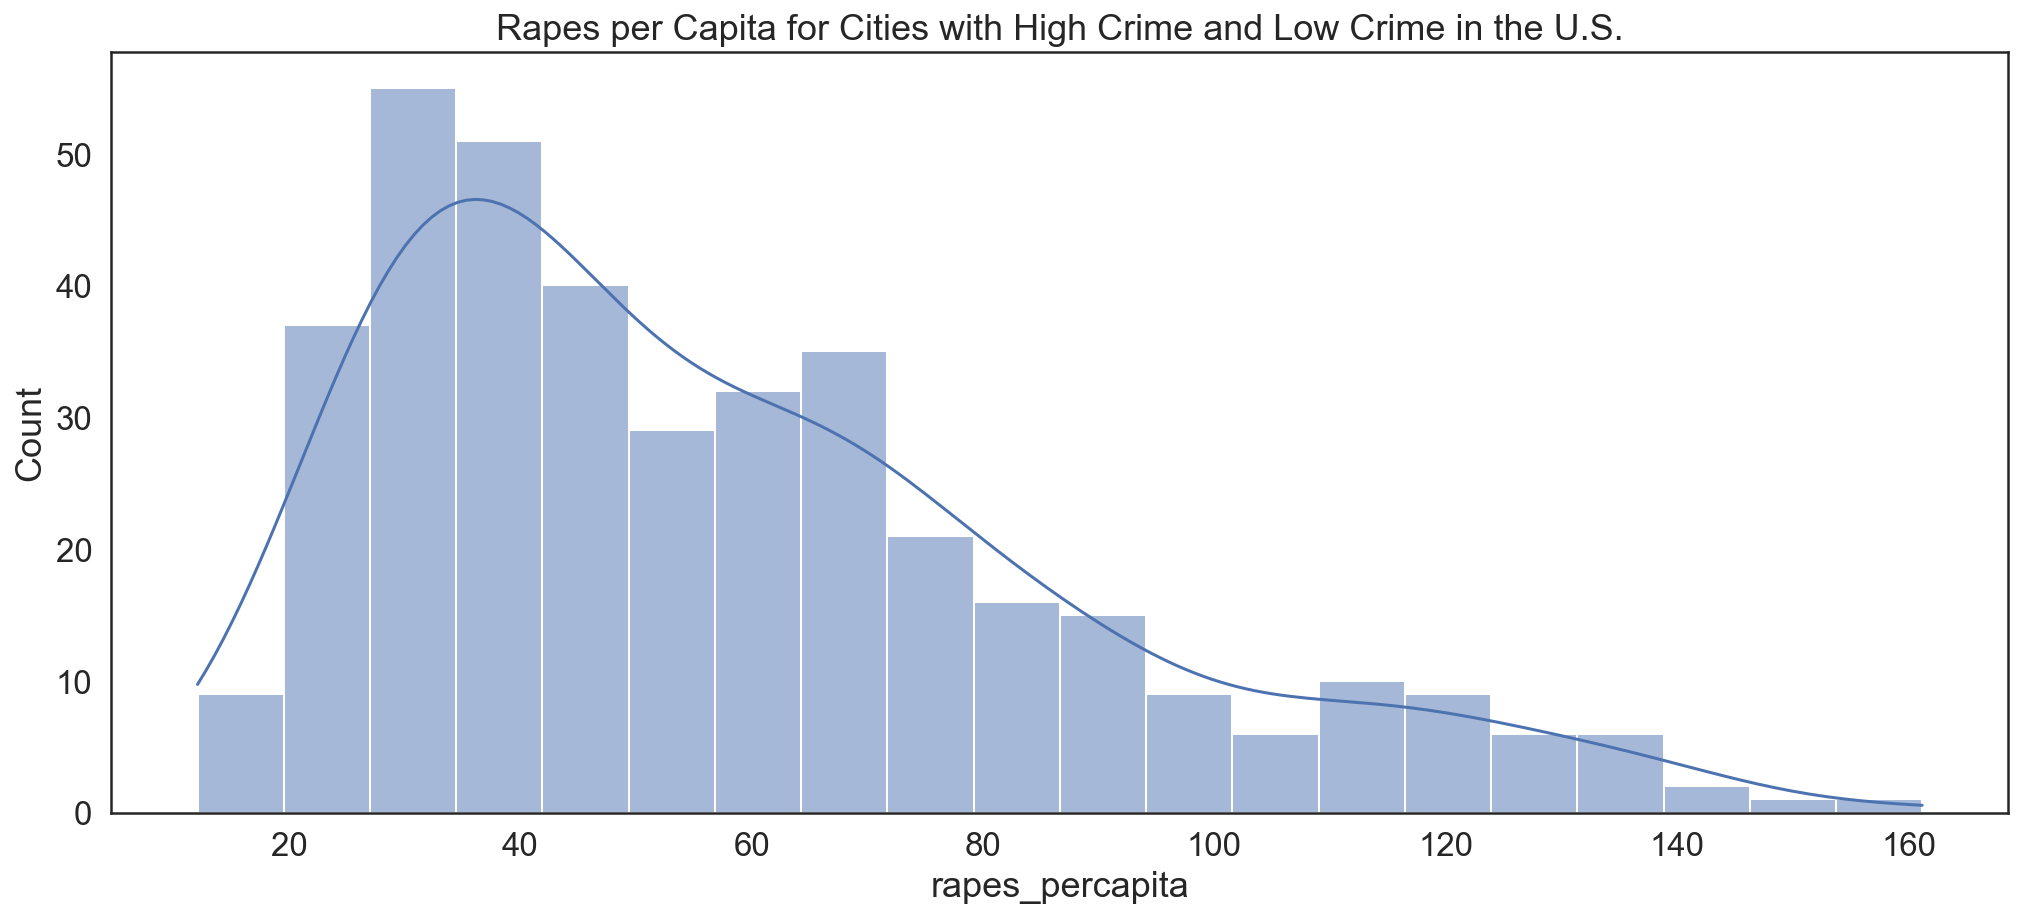

In [126]:
# Find distribution of rapes per capita from our subset of ranked cities
sns.histplot(data=ranked_df, x='rapes_percapita', bins=20, kde=True);
plt.title('Rapes per Capita for Cities with High Crime and Low Crime in the U.S.');

**For all of our years, this variable shows a skewed right distribution similar to the larger data set this subset is from.**

In [127]:
# Find the data point that had the most rapes per capita out of our subset ranked_df dataset
ranked_df[ranked_df['rapes_percapita'] > 150]

year    city_name  crime_population  violent_crimes   rapes  \
132  1990  Detroit, MI         1027974.0         27747.0  1657.0   

     crimes_percapita  rapes_percapita  fiscal_population  \
132           2699.19           161.19            1041375   

     spending_direct_city  spending_general_city  transportation_city  \
132               3408.64                2530.69                263.3   

     public_safety_city  envir_housing_city crime_ranking  \
132              687.45              631.84         Top 5   

     trans_safety_envir_spending  prop_spending  prop_rapes  
132                      1582.59       0.625359    0.059718

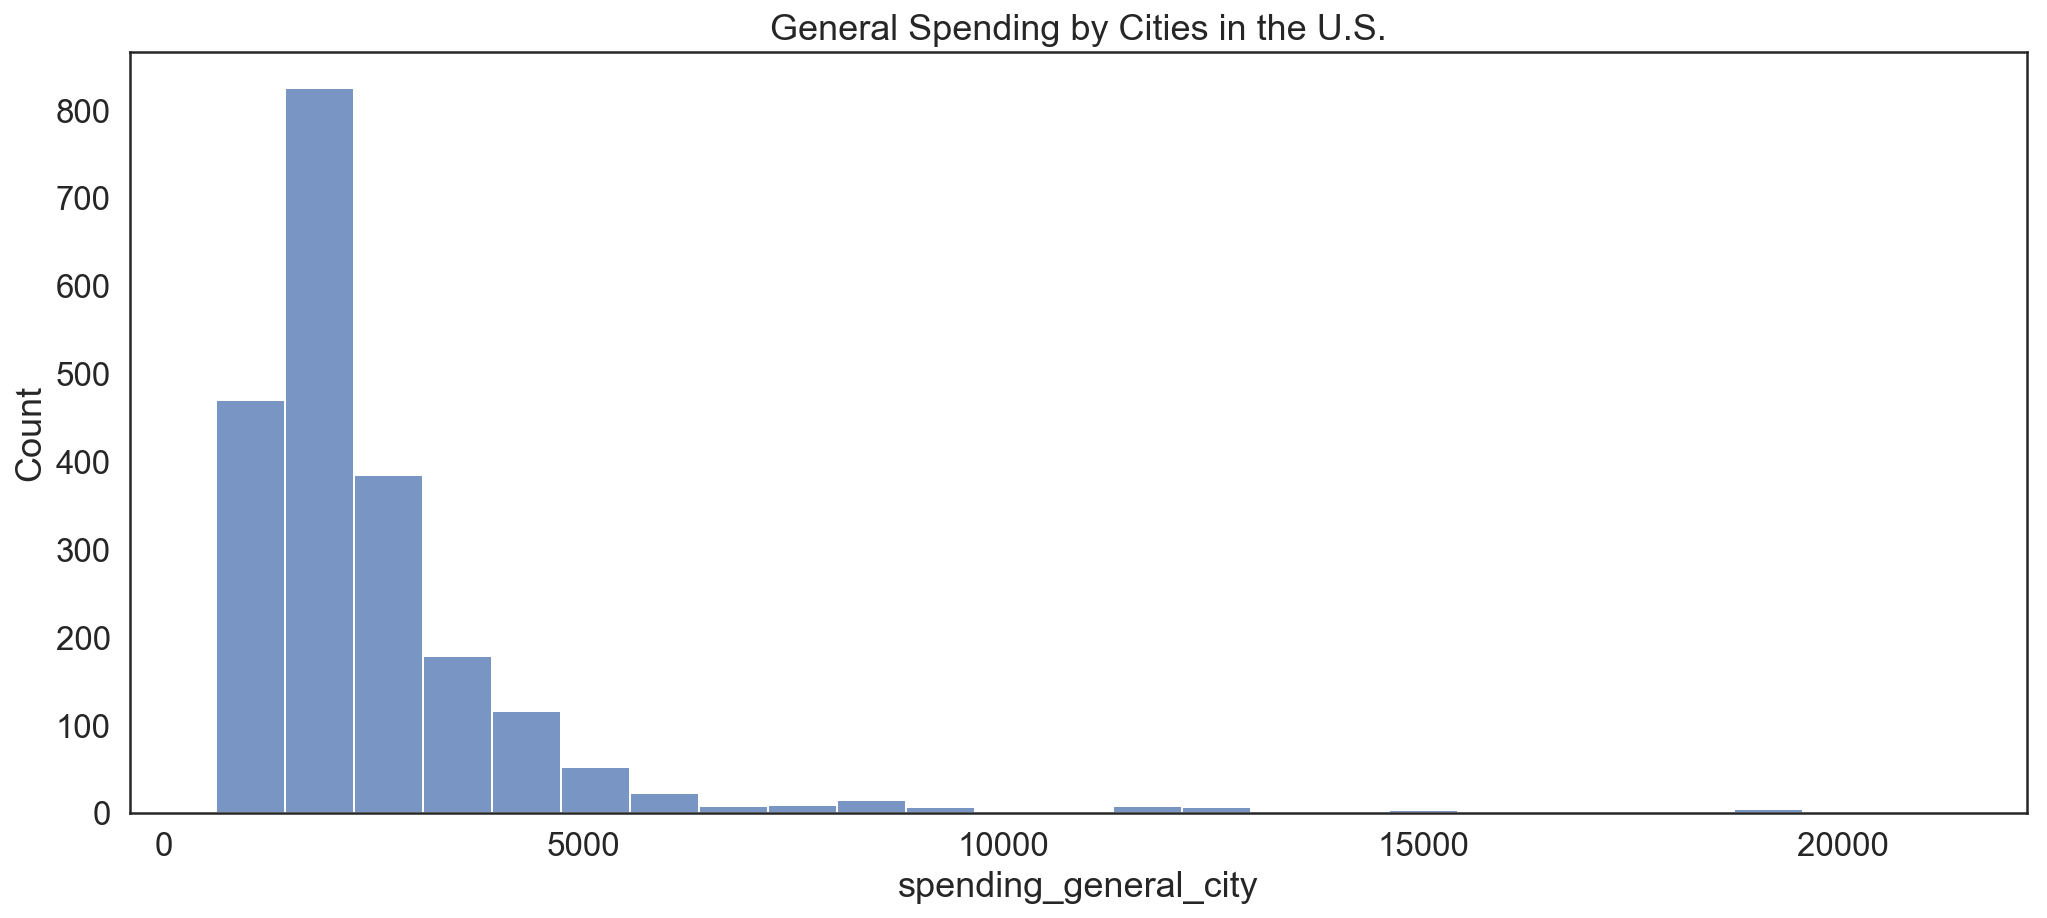

In [128]:
# Find distribution of general spending for our entire merged dataset
sns.histplot(data=merged_df, x='spending_general_city', bins=25, kde=False);
plt.title('General Spending by Cities in the U.S.');

**Interestingly, general spending is also a skewed right distribution for all cities and years from our merged dataset.**

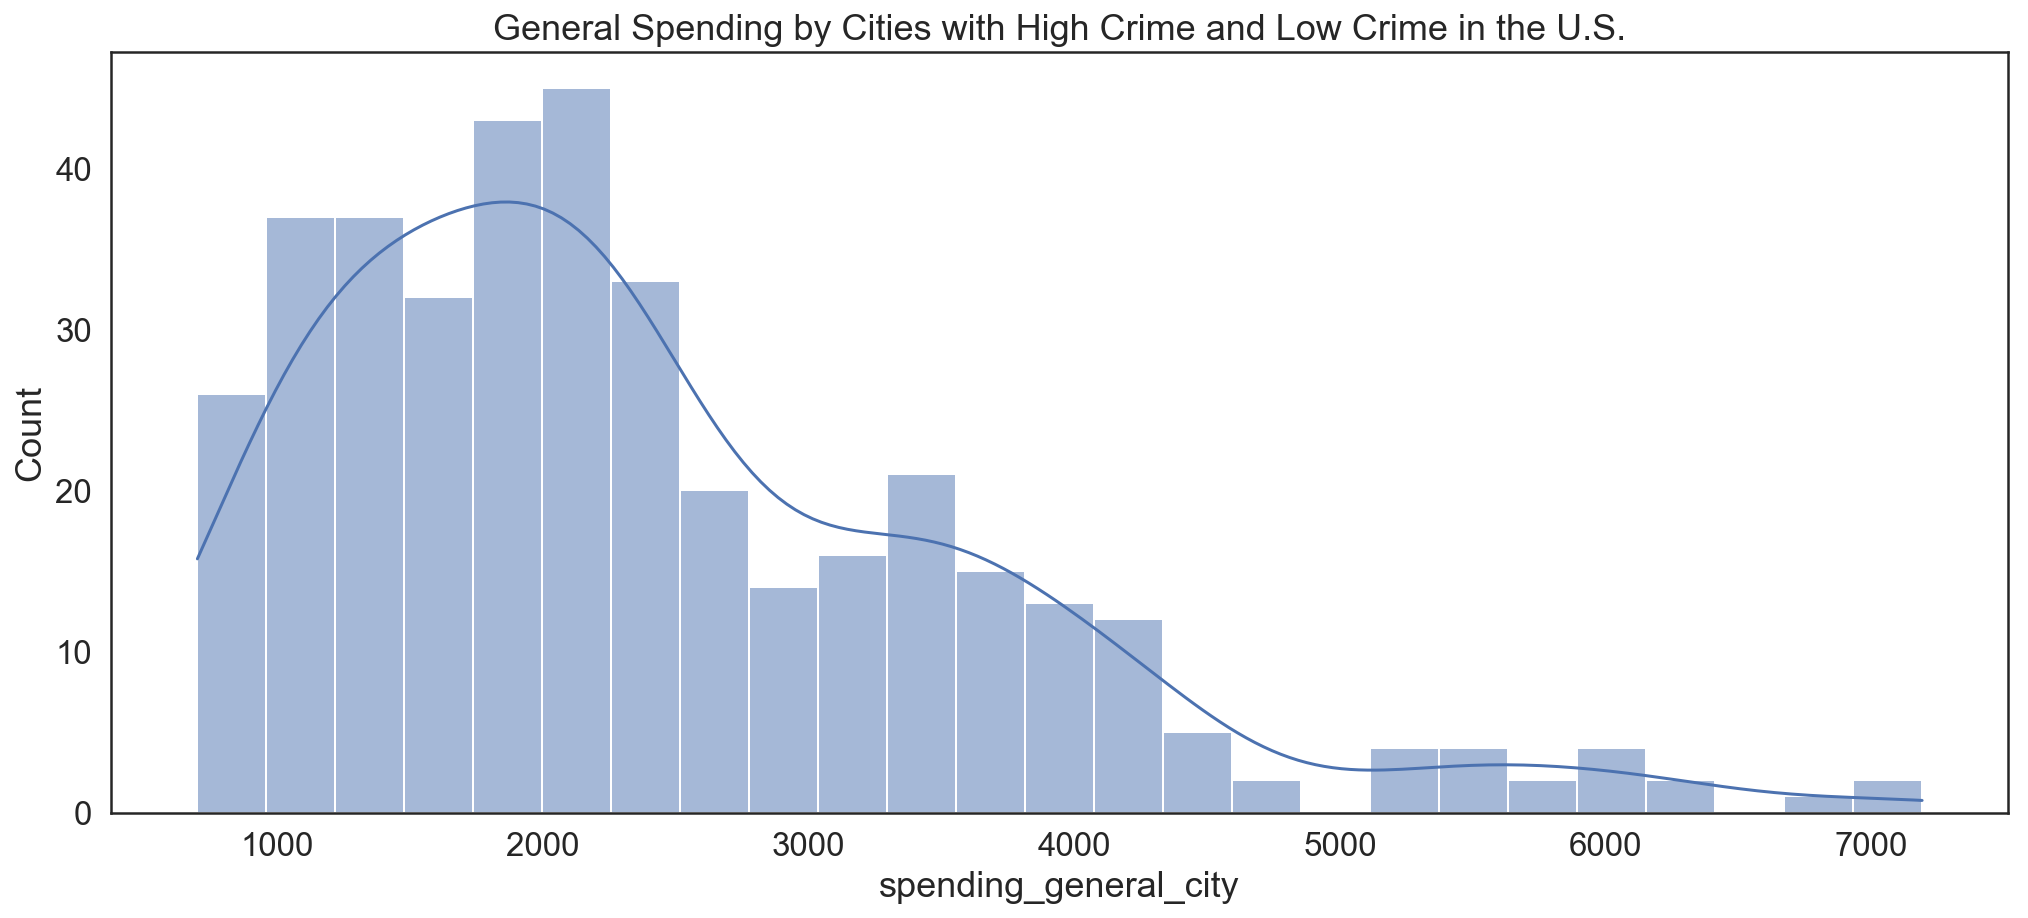

In [129]:
# Find distribution of general spending for our subset of ranked cities
sns.histplot(data=ranked_df, x='spending_general_city', bins=25, kde=True);
plt.title('General Spending by Cities with High Crime and Low Crime in the U.S.');

**In our subset of ranked cities, general spending for all years seems to be skewed right but slightly bimodal. The slight peak on the right end of the distribution may reflect the larger budgets of more populous cities. Moreover, we are studying 2 groups of cities(high crime vs. low crime) which might lead us to observe multiple peaks in the distribution.** 

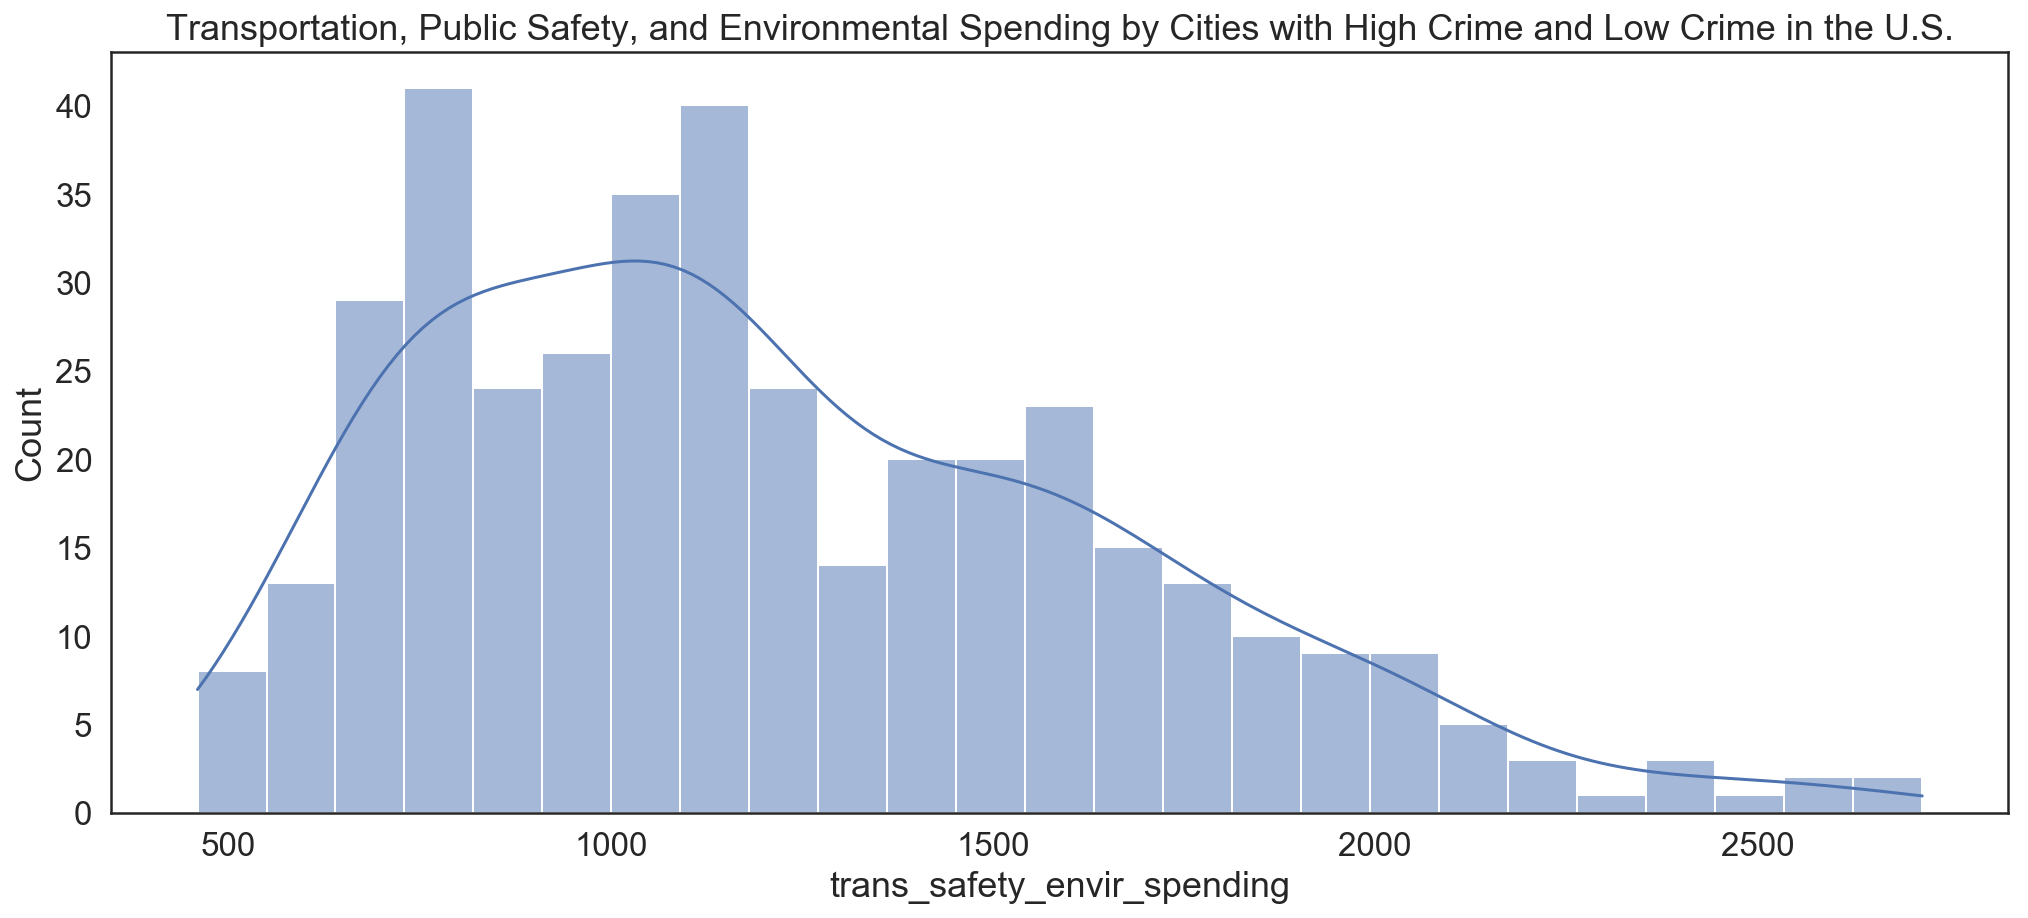

In [130]:
# Find distribution of combined category spending for our subset of ranked cities
sns.histplot(data=ranked_df, x='trans_safety_envir_spending', bins=25, kde=True);
plt.title('Transportation, Public Safety, and Environmental Spending by Cities with High Crime and Low Crime in the U.S.');

**In our subset of ranked cities, general spending for all years seems to be skewed right but slightly multimodal. This is likely a result of grouping cities with varying levels of crime and population, which would impact how much money is required and available for public service expenditures. ** 

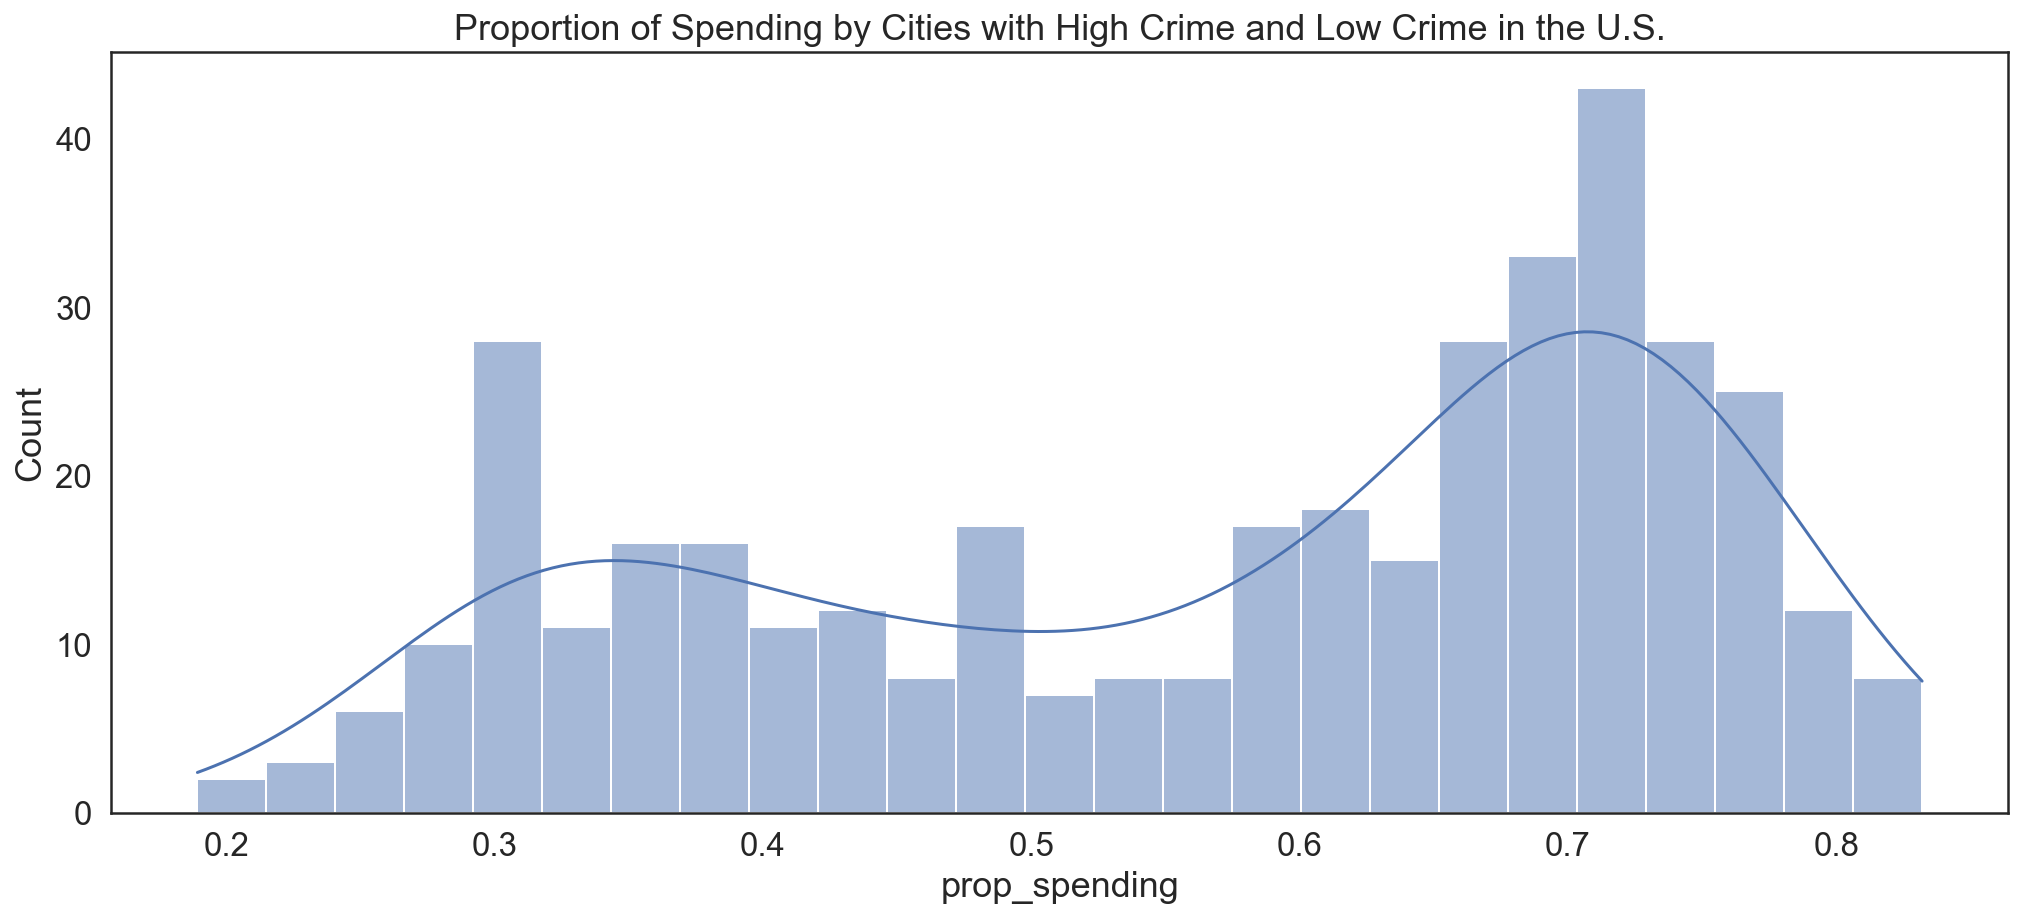

In [131]:
# Find distribution of proportional spending for our subset of ranked cities
sns.histplot(data=ranked_df, x='prop_spending', bins=25, kde=True);
plt.title('Proportion of Spending by Cities with High Crime and Low Crime in the U.S.');


**Interestingly, although our spending variables were skewed right, our proportional spending for all years in our subset of ranked cities seems to be bimodal and more concentrated to the right. Perhaps this shows that although some cities do not have large budgets, they are willing to spend a greater proportion of the budgets on our three categories of focus.**

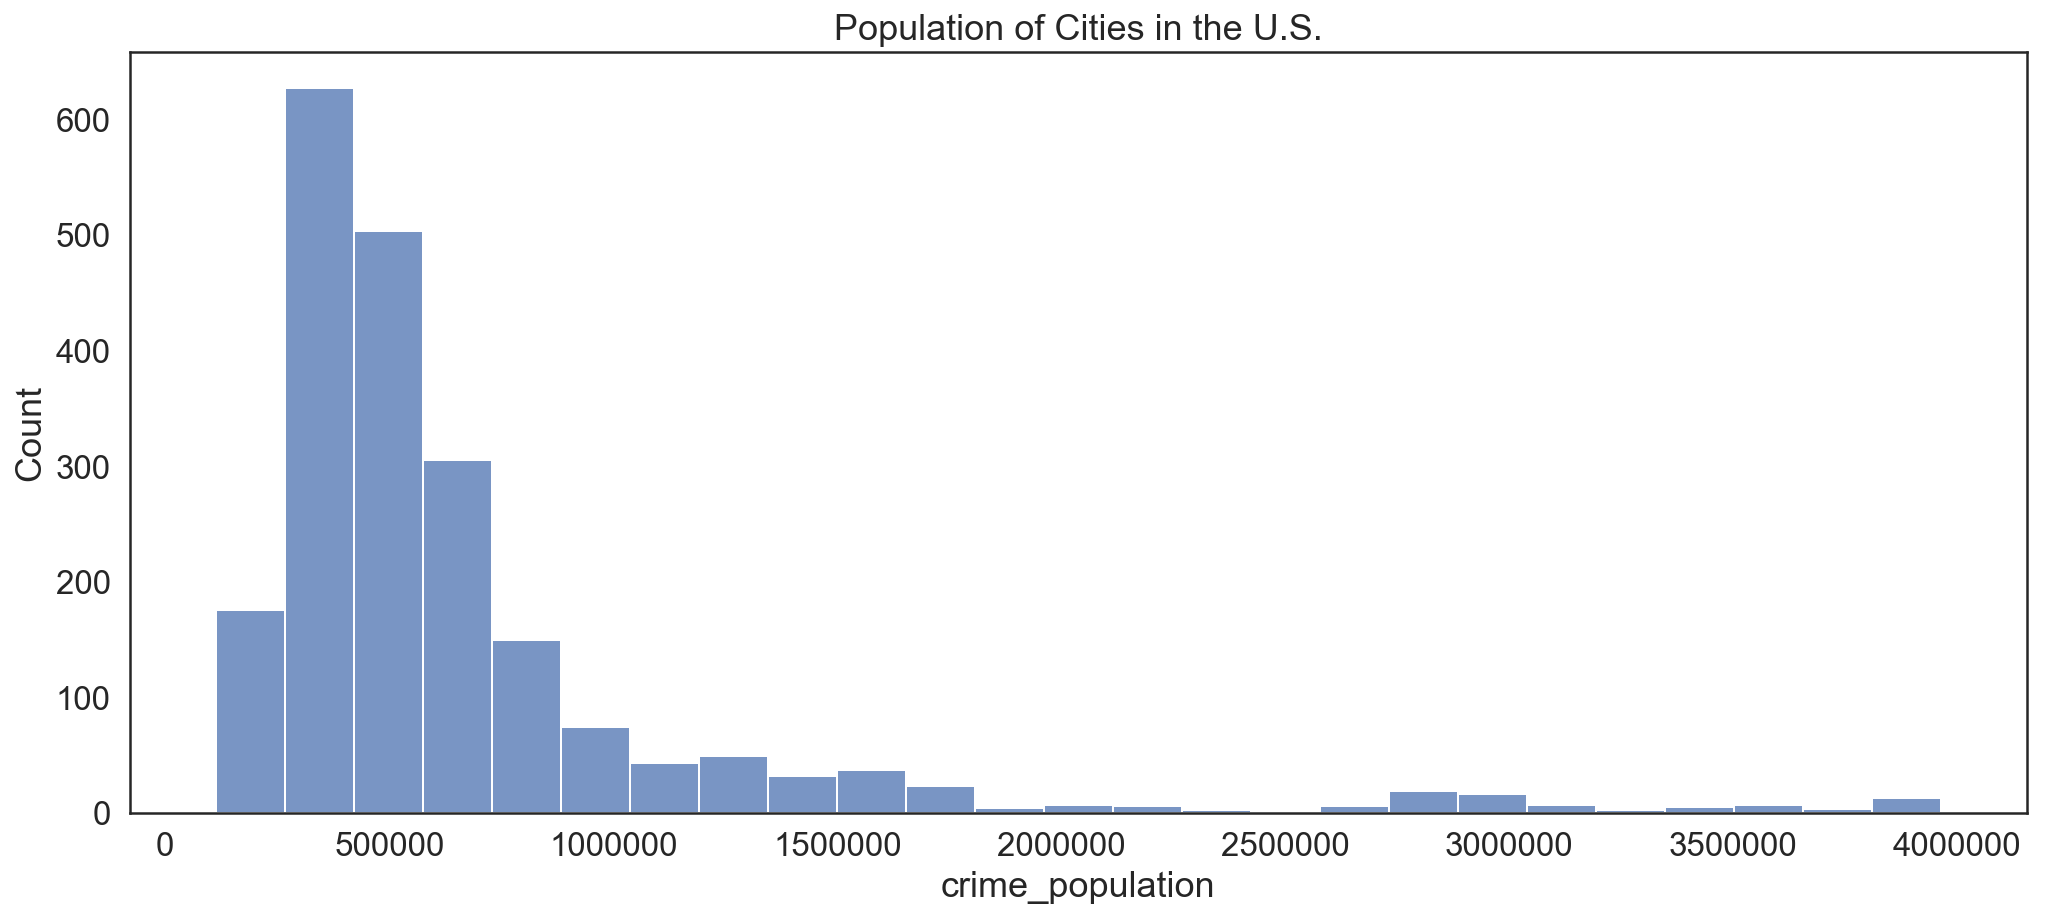

In [132]:
# Find distribution of population for our merged dataset
sns.histplot(data=merged_df, x='crime_population', bins=25, kde=False);
plt.title('Population of Cities in the U.S.');

**For our entire merged dataset, we see that the distribution of population for all years is skewed right.**

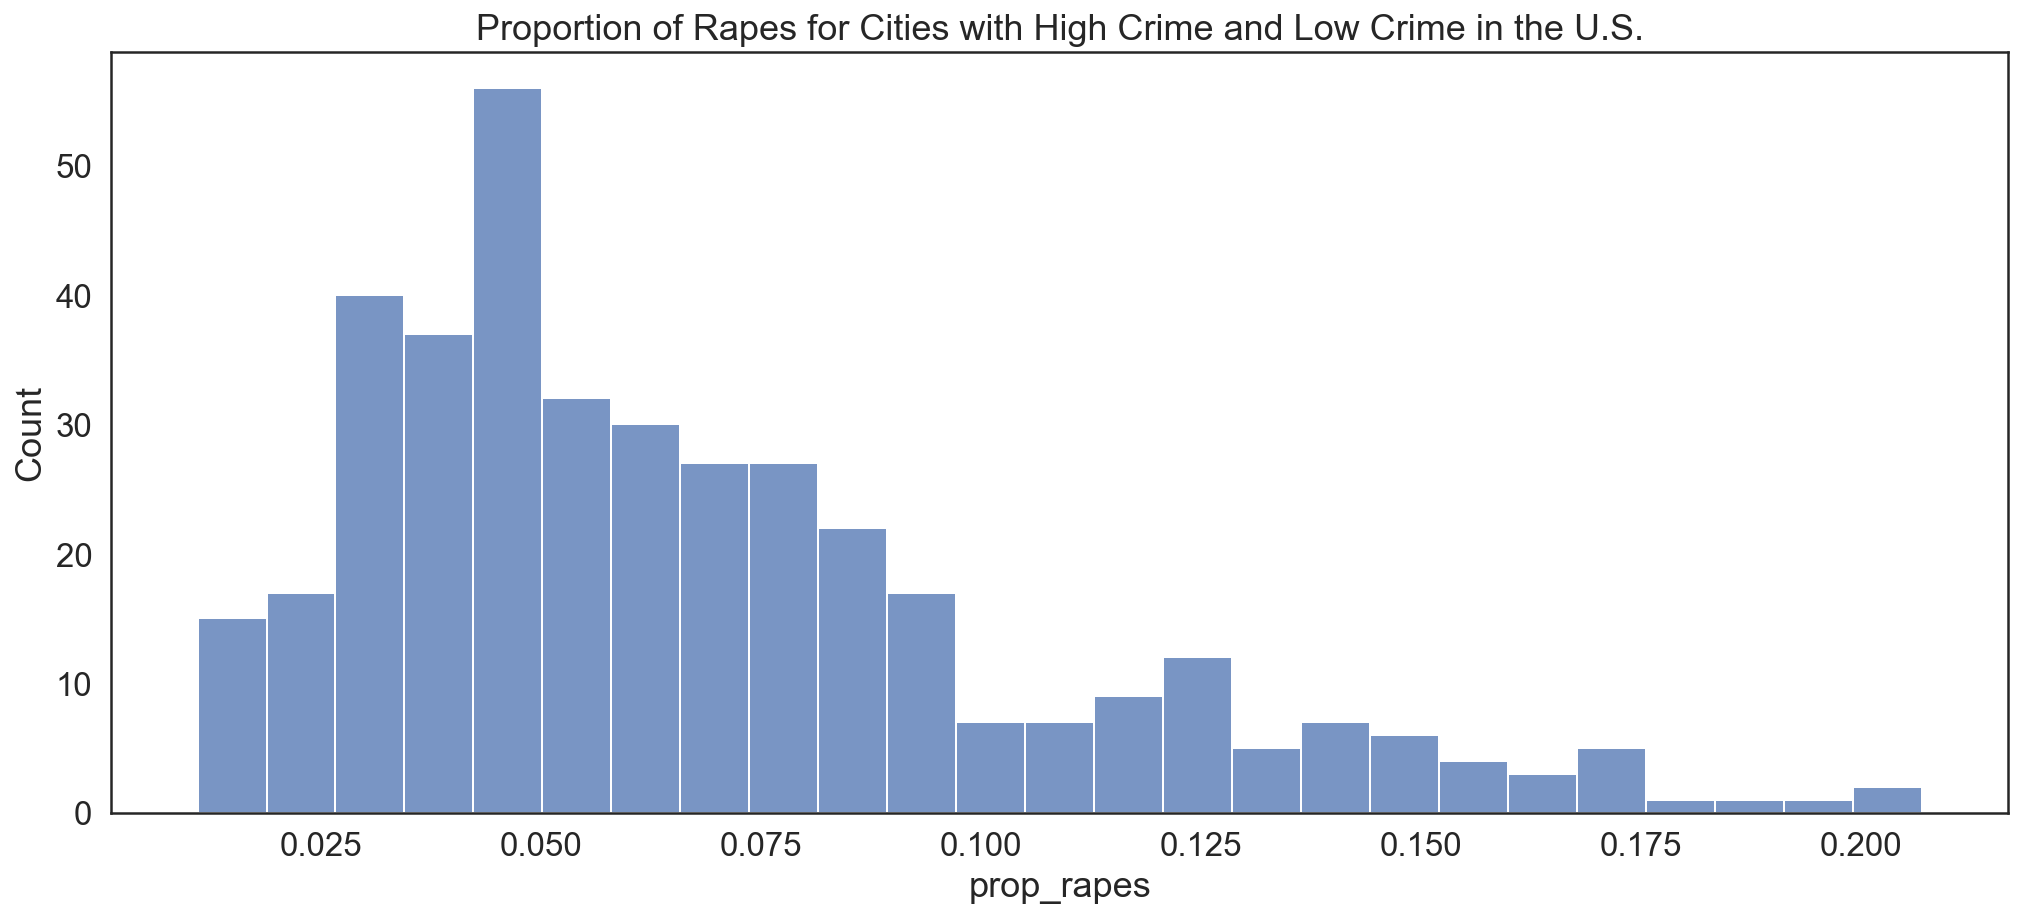

In [133]:
# Find distribution of proportion of rapes per capita for our subset of ranked cities
sns.histplot(data=ranked_df, x='prop_rapes', bins=25, kde=False);
plt.title('Proportion of Rapes for Cities with High Crime and Low Crime in the U.S.');

**For subset of ranked cities, we see that for all years, the proportion of rapes is skewed right.**

In [134]:
# Find the city and year that showed the highest proportion of rapes
ranked_df[ranked_df['prop_rapes'] > 0.2]

year   city_name  crime_population  violent_crimes  rapes  \
80  1985  Austin, TX          406469.0          2363.0  489.0   

    crimes_percapita  rapes_percapita  fiscal_population  \
80            581.35            120.3             417956   

    spending_direct_city  spending_general_city  transportation_city  \
80               4894.38                1968.28                94.04   

    public_safety_city  envir_housing_city crime_ranking  \
80              341.42              550.18      Bottom 5   

    trans_safety_envir_spending  prop_spending  prop_rapes  
80                       985.64       0.500762    0.206932

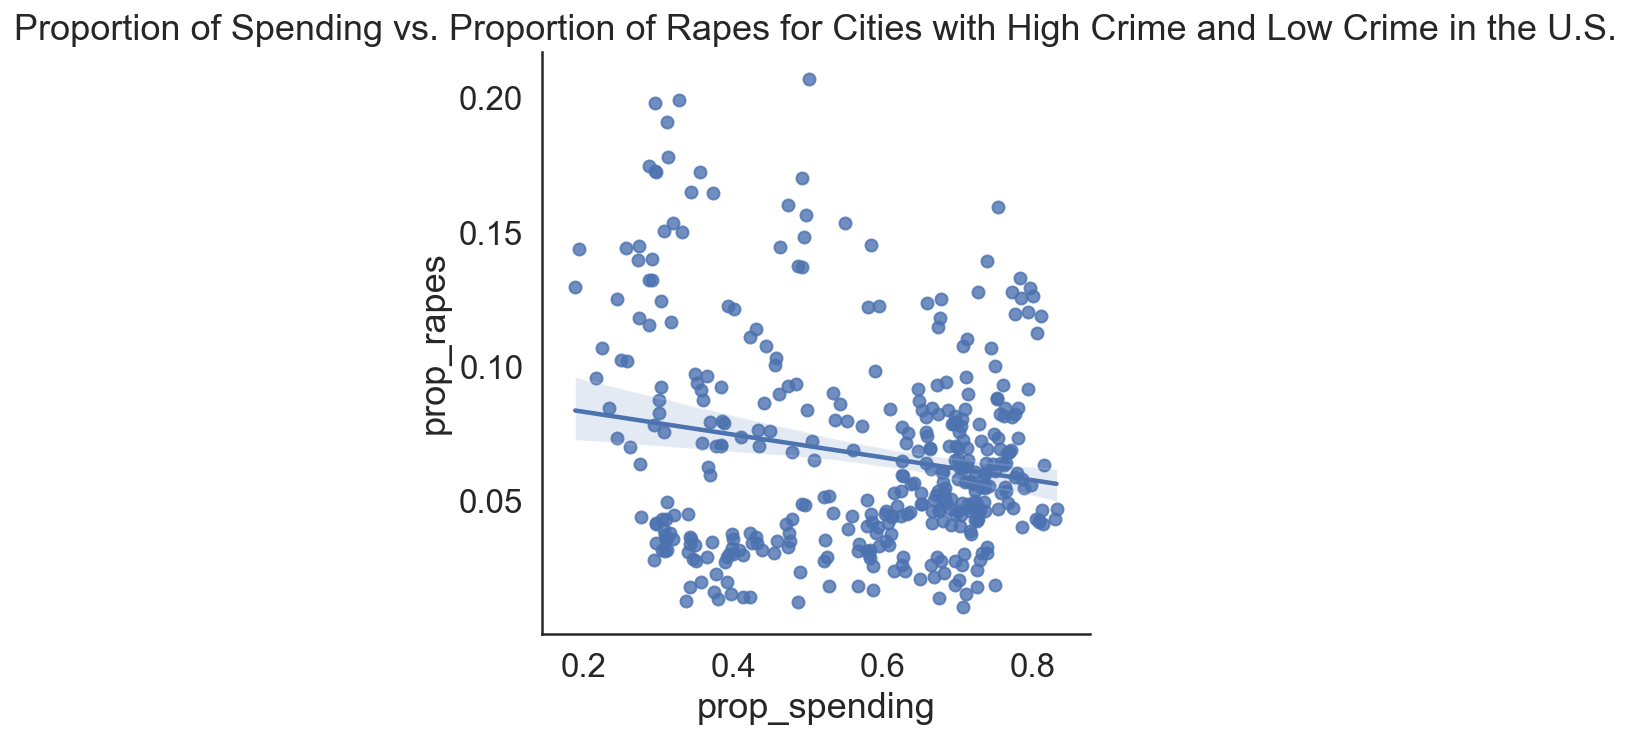

In [135]:
# Find relationship between proportion of spending and proportion of rapes
sns.lmplot(x='prop_spending', y='prop_rapes', 
           data=ranked_df, fit_reg=True);
plt.title('Proportion of Spending vs. Proportion of Rapes for Cities with High Crime and Low Crime in the U.S.');

**We didn't find a relationship. There seems to be a lot of variability. But there is somewhat of a cluster in the bottom right where higher proportion of spending and lower proportion of rapes exist.**

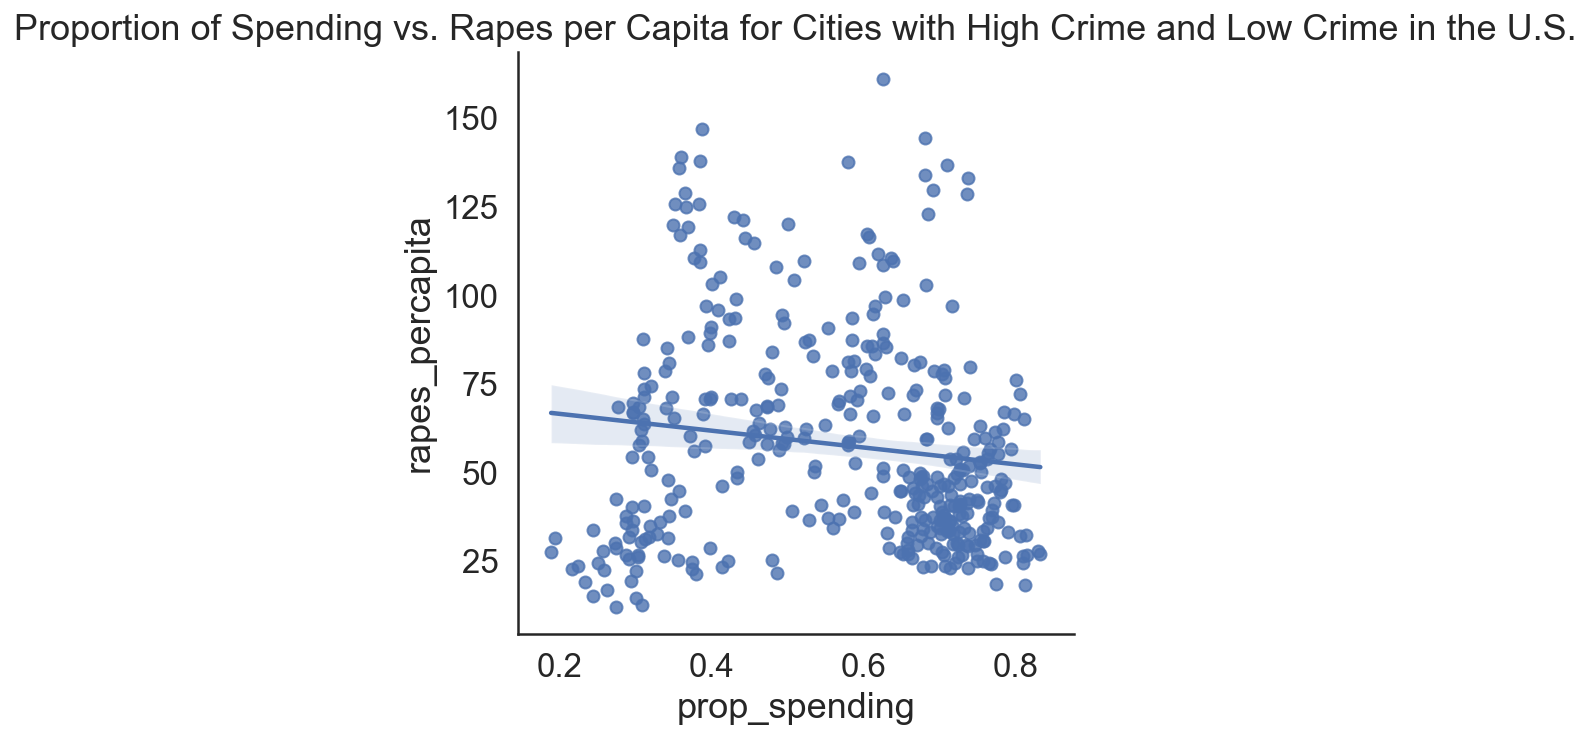

In [136]:
# Find relationship between proportion of spending and rapes per capita
sns.lmplot(x='prop_spending', y='rapes_percapita', 
           data=ranked_df, fit_reg=True);
plt.title('Proportion of Spending vs. Rapes per Capita for Cities with High Crime and Low Crime in the U.S.');

**We didn't find a relationship. There seems to be a lot of variability. But there is somewhat of a cluster in the bottom right where higher proportion of spending and lower rapes per capita exist. This data is not homoscedastic, so we cannot use linear regression to analyze the relationship between these variables. **

In [137]:
#outcome, predictors = patsy.dmatrices("rapes_percapita ~ prop_spending", ranked_df)

#mod_log = sm.OLS(outcome, predictors)

#res_log = mod_log.fit()

#print(res_log.summary())

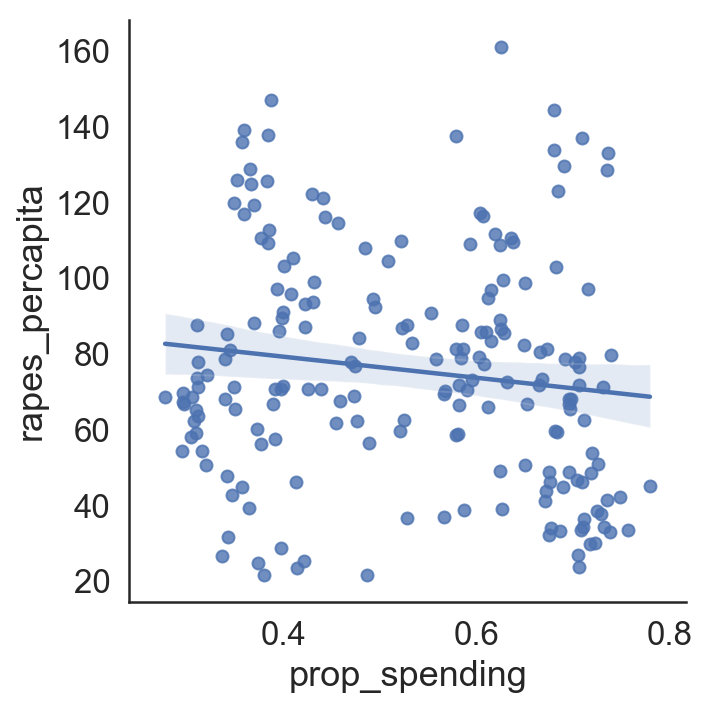

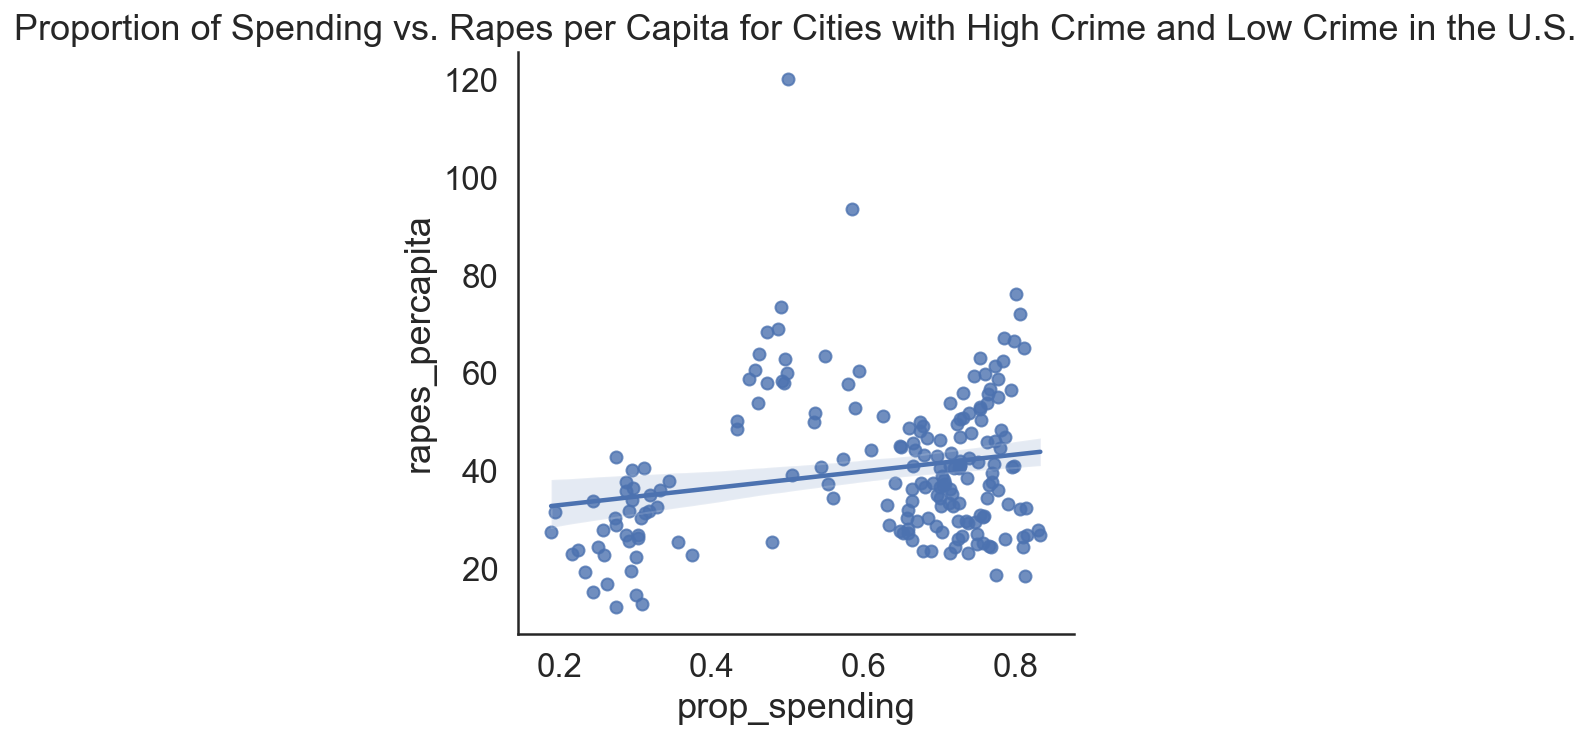

In [138]:
# Find relationship between proportion of spending and rapes per capita
top_df=ranked_df[ranked_df['crime_ranking']=='Top 5']
bot_df=ranked_df[ranked_df['crime_ranking']=='Bottom 5']
sns.lmplot(x='prop_spending', y='rapes_percapita', 
           data=top_df, fit_reg=True);
sns.lmplot(x='prop_spending', y='rapes_percapita', 
           data=bot_df, fit_reg=True);
plt.title('Proportion of Spending vs. Rapes per Capita for Cities with High Crime and Low Crime in the U.S.');

#top5 = ['Memphis, TN', 'Milwaukee, WI', 'Detroit, MI', 'Baltimore, MD', 'St. Louis, MO']
#bot5 = ['El Paso, TX', 'Virginia Beach, VA', 'San Jose, CA', 'Austin, TX', 'Raleigh, NC']
memphis_df = top_df[top_df['city_name'] == 'Memphis, TN']
milwaukee_df = top_df[top_df['city_name'] == 'Milwaukee, WI']
detroit_df = top_df[top_df['city_name'] == 'Detroit, MI']
baltimore_df = top_df[top_df['city_name'] == 'Baltimore, MD']
stlouis_df = top_df[top_df['city_name'] == 'St. Louis, MO']
elpaso_df = bot_df[bot_df['city_name'] == 'El Paso, TX']
virginiabeach_df = bot_df[bot_df['city_name'] == 'Virginia Beach, VA']
sanjose_df = bot_df[bot_df['city_name'] == 'San Jose, CA']
austin_df = bot_df[bot_df['city_name'] == 'Austin, TX']
raleigh_df = bot_df[bot_df['city_name'] == 'Raleigh, NC']
print(memphis_df)

#For each city, find the average of rapes per capita across all years
memphis_mean = memphis_df['rapes_percapita'].mean()
milwaukee_mean = milwaukee_df['rapes_percapita'].mean()
detroit_mean = detroit_df['rapes_percapita'].mean()
baltimore_mean = baltimore_df['rapes_percapita'].mean()
stlouis_mean = stlouis_df['rapes_percapita'].mean()
elpaso_mean = elpaso_df['rapes_percapita'].mean()
virginiabeach_mean = virginiabeach_df['rapes_percapita'].mean()
sanjose_mean = sanjose_df['rapes_percapita'].mean()
austin_mean = austin_df['rapes_percapita'].mean()
raleigh_mean = raleigh_df['rapes_percapita'].mean()

rapes_per_capita_means = [memphis_mean, milwaukee_mean, detroit_mean, baltimore_mean, stlouis_mean, elpaso_mean, virginiabeach_mean, sanjose_mean, austin_mean, raleigh_mean]
#print(memphis_mean, milwaukee_mean, detroit_mean, baltimore_mean, stlouis_mean, elpaso_mean, virginiabeach_mean, sanjose_mean, austin_mean, raleigh_mean)

In [139]:
merged_df.groupby('city_name').mean()

year  crime_population  violent_crimes  \
city_name                                                           
Albuquerque, NM     1996.000000      4.303646e+05     4522.538462   
Arlington, TX       1996.000000      2.870222e+05     1736.641026   
Atlanta, GA         1996.000000      4.377263e+05    10602.769231   
Aurora, CO          1996.000000      2.519665e+05     1960.256410   
Austin, TX          1996.000000      5.737322e+05     2902.410256   
Baltimore, MD       1996.000000      7.069892e+05    14624.435897   
Boston, MA          1996.000000      5.867663e+05     9047.743590   
Buffalo, NY         1996.000000      3.128731e+05     4036.487179   
Charlotte, NC       1996.000000      5.410556e+05     6419.974359   
Chicago, IL         1996.000000      2.876477e+06    48540.666667   
Cincinnati, OH      1995.918919      3.498316e+05     3750.810811   
Cleveland, OH       1995.500000      4.995786e+05     7432.000000   
Columbus, OH        1996.000000      6.665857e+05     5543.435897   
Dallas, TX          1996.000000      1.099664e+06    14758.179487   
Denver, CO          1996.000000      5.432856e+05     4126.717949   
Detroit, MI         1996.000000      9.915251e+05    21997.871795   
El Paso, TX         1996.000000      5.561922e+05     3746.000000   
Fresno, CA          1996.000000      3.749373e+05     3469.307692   
Houston, TX         1996.000000      1.876505e+06    20578.717949   
Indianapolis, IN    1996.000000      6.268503e+05     6941.230769   
Jacksonville, FL    1996.000000      7.008126e+05     7377.157895   
Kansas City, MO     1996.000000      4.518345e+05     7681.666667   
Las Vegas, NV       1996.000000      8.866487e+05     7688.512821   
Long Beach, CA      1996.000000      4.328484e+05     4342.666667   
Los Angeles, CA     1996.000000      3.526040e+06    49148.743590   
Louisville, KY      2009.000000      6.465003e+05     3878.153846   
Memphis, TN         1996.000000      6.510288e+05     9818.820513   
Mesa, AZ            1996.000000      3.275366e+05     1783.512821   
Miami, FL           1996.000000      3.838101e+05     9027.128205   
Milwaukee, WI       1996.000000      6.130047e+05     5747.538462   
Minneapolis, MN     1996.000000      3.748934e+05     4896.589744   
Nashville, TN       1996.000000      5.321570e+05     6773.102564   
New Orleans, LA     1996.000000      4.760280e+05     6658.128205   
Oakland, CA         1996.000000      3.799991e+05     6887.923077   
Omaha, NE           1996.000000      3.775346e+05     2810.897436   
Orlando, FL         1996.000000      1.838531e+05     3147.948718   
Philadelphia, PA    1996.000000      1.583371e+06    18814.256410   
Phoenix, AZ         1996.000000      1.164208e+06     9020.743590   
Pittsburgh, PA      1996.000000      3.647842e+05     3822.205128   
Portland, OR        1995.500000      4.744554e+05     5862.763158   
Raleigh, NC         1996.000000      2.643515e+05     1611.974359   
Sacramento, CA      1996.000000      3.858274e+05     3827.051282   
Salt Lake City, UT  1996.000000      1.774424e+05     1291.282051   
San Antonio, TX     1996.000000      1.081861e+06     6533.769231   
San Diego, CA       1996.000000      1.144797e+06     7717.923077   
San Francisco, CA   1996.000000      7.544844e+05     8726.282051   
San Jose, CA        1996.000000      8.225459e+05     4177.153846   
Seattle, WA         1996.000000      5.528260e+05     5024.358974   
St. Louis, MO       1996.000000      3.872863e+05     9225.333333   
Tampa, FL           1996.210526      3.070350e+05     5775.184211   
Tucson, AZ          1996.000000      4.473621e+05     3821.615385   
Tulsa, OK           1996.000000      3.805350e+05     3895.410256   
Virginia Beach, VA  1996.000000      3.864856e+05      848.948718   
Washington, DC      1996.000000      6.012632e+05    10534.205128   
Wichita, KS         1996.000000      3.255002e+05     2339.666667   

                          rapes  crimes_percapita  rapes_percapita  \
city_name              

In [140]:
merged_df = merged_df.assign(trans_safety_envir_spending = 
            merged_df['transportation_city'] + merged_df['public_safety_city'] + merged_df['envir_housing_city'])
merged_df = merged_df.assign(prop_spending = merged_df['trans_safety_envir_spending'] / merged_df['spending_general_city'])
merged_df['prop_transportation'] = merged_df['transportation_city'] / merged_df['spending_general_city']
merged_df['prop_safety'] = merged_df['public_safety_city'] / merged_df['spending_general_city']
merged_df['prop_envir'] = merged_df['envir_housing_city'] / merged_df['spending_general_city']
merged_df.head()

year        city_name  crime_population  violent_crimes  rapes  \
0  1977  Albuquerque, NM          292341.0          2390.0  207.0   
1  1977    Arlington, TX          112994.0           389.0   34.0   
2  1977      Atlanta, GA          440300.0          7595.0  510.0   
3  1977       Aurora, CO          137200.0           585.0   42.0   
4  1977       Austin, TX          321900.0          1260.0  187.0   

   crimes_percapita  rapes_percapita  fiscal_population  spending_direct_city  \
0            817.54            70.81             298857               1621.48   
1            344.27            30.09             126561                951.16   
2           1724.96           115.83             432676               2305.35   
3            426.38            30.61             117414               1282.81   
4            391.43            58.09             323480               3977.11   

   spending_general_city  transportation_city  public_safety_city  \
0                1332.47               155.69              365.35   
1                 682.70               104.25              147.94   
2                1909.13               419.71              422.03   
3                1052.78               182.76              266.74   
4                1634.83               114.04              239.83   

   envir_housing_city  trans_safety_envir_spending  prop_spending  \
0              333.59                       854.63       0.641388   
1              127.68                       379.87       0.556423   
2              383.15                      1224.89       0.641596   
3              213.21                       662.71       0.629486   
4              455.32                       809.19       0.494969   

   prop_transportation  prop_safety  prop_envir  
0             0.116843     0.274190    0.250355  
1             0.152703     0.216698    0.187022  
2             0.219844     0.221059    0.200694  
3             0.173598     0.253367    0.202521  
4             0.069756     0.146700    0.278512

In [141]:
restrict_years_df = merged_df[merged_df['year'] >= 1995]
restrict_years_df = restrict_years_df.groupby('city_name').mean()

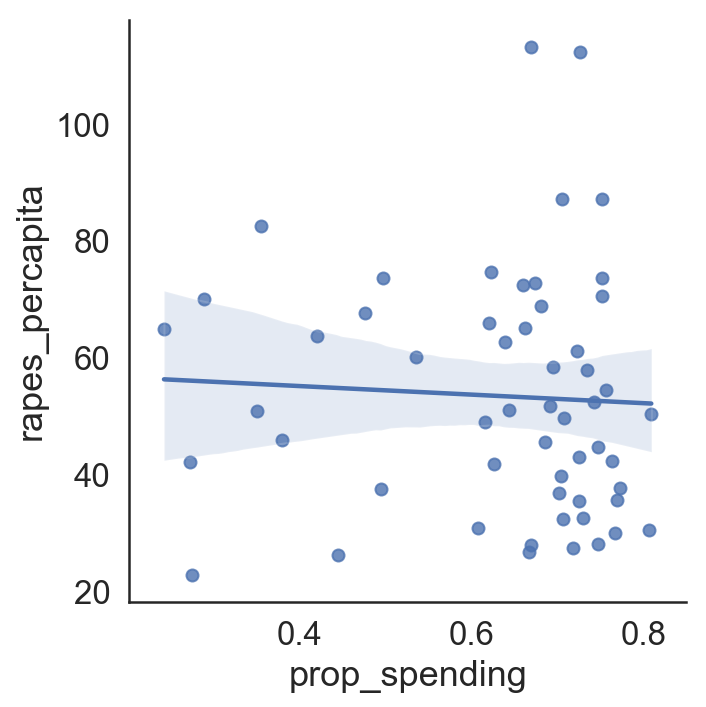

In [142]:
sns.lmplot(x='prop_spending', y='rapes_percapita', 
           data=restrict_years_df, fit_reg=True);

In [143]:
outcome, predictors = patsy.dmatrices("rapes_percapita ~ prop_spending", restrict_years_df)

mod_log = sm.OLS(outcome, predictors)

res_log = mod_log.fit()

print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:        rapes_percapita   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1528
Date:                Thu, 03 Jun 2021   Prob (F-statistic):              0.697
Time:                        15:53:44   Log-Likelihood:                -244.13
No. Observations:                  55   AIC:                             492.3
Df Residuals:                      53   BIC:                             496.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        58.1397     12.163      4.780

In [144]:
#proportion of individual categories, OLS report for each
#discussion will include considering confounding variables, which spending proportion might be more influential than the others
#include future directions 
#exploratory tangent: random forest model, which variable predicts rapes per capita...

In [145]:
outcome, predictors = patsy.dmatrices("rapes_percapita ~ prop_transportation", restrict_years_df)

mod_log = sm.OLS(outcome, predictors)

res_log = mod_log.fit()

print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:        rapes_percapita   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2985
Date:                Thu, 03 Jun 2021   Prob (F-statistic):              0.587
Time:                        15:53:44   Log-Likelihood:                -244.05
No. Observations:                  55   AIC:                             492.1
Df Residuals:                      53   BIC:                             496.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              50.6556    

In [146]:
outcome, predictors = patsy.dmatrices("rapes_percapita ~ prop_safety", restrict_years_df)

mod_log = sm.OLS(outcome, predictors)

res_log = mod_log.fit()

print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:        rapes_percapita   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.2388
Date:                Thu, 03 Jun 2021   Prob (F-statistic):              0.627
Time:                        15:53:44   Log-Likelihood:                -244.08
No. Observations:                  55   AIC:                             492.2
Df Residuals:                      53   BIC:                             496.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      58.9858     11.545      5.109      

In [147]:
outcome, predictors = patsy.dmatrices("rapes_percapita ~ prop_envir", restrict_years_df)

mod_log = sm.OLS(outcome, predictors)

res_log = mod_log.fit()

print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:        rapes_percapita   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6947
Date:                Thu, 03 Jun 2021   Prob (F-statistic):              0.408
Time:                        15:53:55   Log-Likelihood:                -243.85
No. Observations:                  55   AIC:                             491.7
Df Residuals:                      53   BIC:                             495.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.9091      8.167      7.335      0.0

Discussion thoughts:
- there are several factors that may impact rape rates 
- future studies can explore the impact of mental health investment/spending in cities with rapes per capita